In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [2]:
conn = sqlite3.connect('web-performance.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements

msm_id            timestamp  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716  2022-06-08_15_01_00   
1     ec2d9a45-57d7-46ec-a505-26427fb1aa48  2022-06-08_15_01_54   
2     a43c51c9-7361-47e7-8b05-95c7d2105c7f  2022-06-08_15_02_48   
3     4d5392b4-2eda-438c-b2d3-233007fecf79  2022-06-08_15_03_42   
4     00dc53ef-e9fa-45e6-af88-2804ef7f2a57  2022-06-08_15_04_36   
...                                    ...                  ...   
1448  669a2e98-415e-4d3e-b8c3-b583d8fef133  2022-06-09_13_32_00   
1449  4f178ba8-8458-495d-8f0e-754a58734d49  2022-06-09_13_32_55   
1450  907e8072-3a93-44d4-bd70-12862dfec30c  2022-06-09_13_33_49   
1451  a3d6174b-4a5f-4d58-8feb-1f30c1052a73  2022-06-09_13_34_43   
1452  6e9b6f63-0827-4964-b98f-a0ff02dc6572  2022-06-09_13_35_38   

     experiment_type error            website  
0                dsl          www.example.org  
1              cable          www.example.org  
2              fiber          www.example.org  
3                 4g          www.example.org  
4          4g-medium          www.example.org  
...              ...   ...                ...  
1448             dsl        www.wikipedia.org  
1449           cable        www.wikipedia.org  
1450           fiber        www.wikipedia.org  
1451              4g        www.wikipedia.org  
1452       4g-medium        www.wikipedia.org  

[1453 rows x 5 columns]

In [3]:
measurements.error.value_counts()

    1453
Name: error, dtype: int64

In [4]:
df_web_perf = pd.read_sql_query("SELECT * FROM web_performance_metrics", conn)
df_dns_perf = pd.read_sql_query("SELECT * FROM dns_metrics", conn)
df_lookups = pd.read_sql_query("SELECT * FROM lookups", conn)
conn.close()

In [5]:
df_web_perf = pd.merge(df_web_perf, measurements, on='msm_id')

In [6]:
df_web_perf.groupby(['website', 'is_warmup']).agg(plt=('loadEventStart', 'median'),fcp=('firstContentfulPaint', 'median'))

plt     fcp
website           is_warmup                 
www.example.org   0            72.20   84.00
                  1           186.25  192.25
www.instagram.com 0           315.10  103.20
                  1          1695.10  199.65
www.wikipedia.org 0           121.20   88.70
                  1           422.80  347.50

In [7]:
df_dns_perf_metrics = df_dns_perf.copy()

In [8]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)

df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]

df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])

df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [9]:
df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].groupby(['transport_protocol', 'is_warmup']).agg(lookup_dur=('duration','median'))

lookup_dur
transport_protocol is_warmup            
DoH                0          148.579734
DoQ                0          124.306323
DoUDP              0           44.125883

In [10]:
df_exchange_times = df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].copy()

In [11]:
df_dns_and_h3 = pd.merge(df_web_perf, df_lookups[['msm_id', 'elapsed', 'transport_protocol']], on='msm_id')


In [12]:
df_dns_and_h3['full_plt'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['loadEventStart']
df_dns_and_h3['full_fp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstPaint']
df_dns_and_h3['full_fcp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstContentfulPaint']

In [13]:
df_dns_and_h3['h3_description'] = 'H3 1-RTT'
df_dns_and_h3['h3_description'] = np.where(df_dns_and_h3['is_warmup'] == 0, 'H3 0-RTT', df_dns_and_h3['h3_description'])

In [14]:
df_dns_and_h3.h3_description.value_counts() #thrice the actual value because of join

H3 1-RTT    4359
H3 0-RTT    4359
Name: h3_description, dtype: int64

In [15]:
df_dns_and_h3.transport_protocol.value_counts() #twice the actual value because of join

DoQ      2906
DoH      2906
DoUDP    2906
Name: transport_protocol, dtype: int64

In [16]:
df_dns_and_h3.website.value_counts()

www.instagram.com    4320
www.example.org      2208
www.wikipedia.org    2190
Name: website, dtype: int64

In [17]:
df_dns_and_h3.experiment_type.value_counts()

dsl          1746
cable        1746
fiber        1746
4g           1740
4g-medium    1740
Name: experiment_type, dtype: int64

In [18]:
df_dns_and_h3['experiment_description'] = df_dns_and_h3.transport_protocol + ' + ' + df_dns_and_h3.h3_description

In [19]:
df_dns_and_h3['experiment_description'].value_counts()

DoQ + H3 1-RTT      1453
DoH + H3 1-RTT      1453
DoUDP + H3 1-RTT    1453
DoQ + H3 0-RTT      1453
DoH + H3 0-RTT      1453
DoUDP + H3 0-RTT    1453
Name: experiment_description, dtype: int64

dsl
count     74.000000
mean     311.671736
std        4.742886
min      300.184241
10%      307.891706
20%      309.049581
25%      309.139836
30%      309.336630
40%      310.321114
50%      310.985261
60%      311.407734
70%      311.810077
75%      312.488767
80%      312.646765
90%      320.801407
100%     325.297236
max      325.297236
Name: full_plt, dtype: float64
count     74.000000
mean     197.067682
std        1.027569
min      194.698201
10%      195.977186
20%      196.228143
25%      196.295625
30%      196.462918
40%      196.694742
50%      196.872206
60%      197.320203
70%      197.568384
75%      197.692952
80%      197.875152
90%      198.576234
100%     199.484710
max      199.484710
Name: full_plt, dtype: float64
count     74.000000
mean     335.855528
std        4.661356
min      324.359647
10%      331.965804
20%      333.424781
25%      333.668240
30%      333.783647
40%      334.478814
50%      335.024708
60%      335.455727
70%      336.009691
75%      336.5

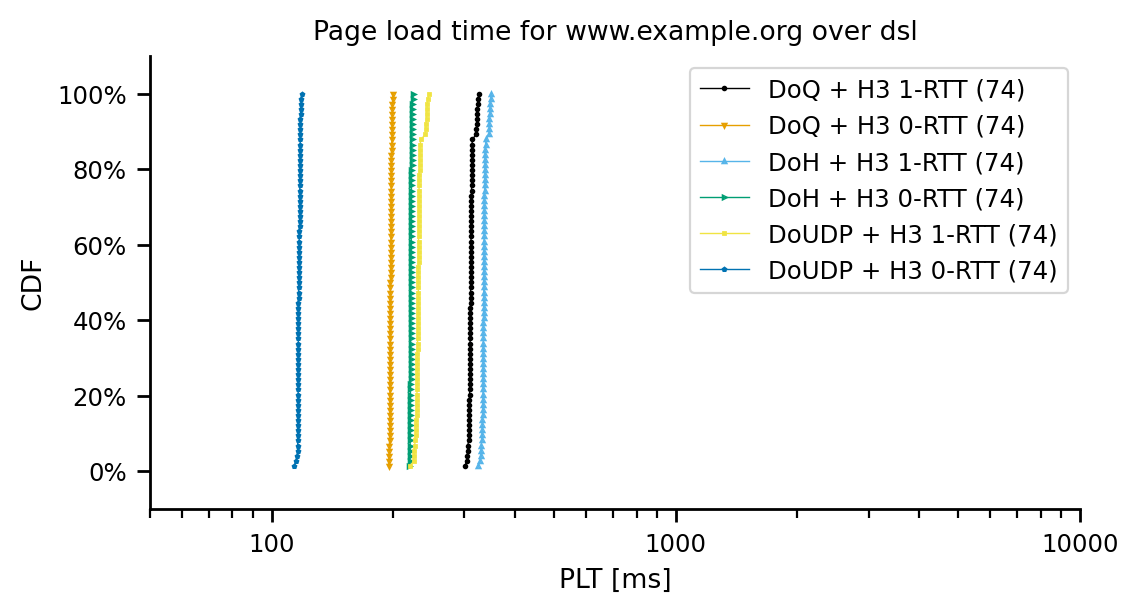

count     73.000000
mean     548.670978
std       25.628325
min      483.611711
10%      520.867841
20%      529.279274
25%      533.499693
30%      536.312386
40%      543.287779
50%      547.090505
60%      550.812724
70%      554.285834
75%      555.199844
80%      561.082346
90%      590.452143
100%     608.178503
max      608.178503
Name: full_plt, dtype: float64
count     73.000000
mean     241.203855
std       25.592898
min      217.660741
10%      220.923649
20%      221.762844
25%      221.962587
30%      222.349173
40%      222.745218
50%      223.475137
60%      225.328920
70%      268.562316
75%      273.644650
80%      274.438865
90%      277.138455
100%     288.520272
max      288.520272
Name: full_plt, dtype: float64
count     73.000000
mean     572.802338
std       25.530022
min      507.250190
10%      545.860858
20%      553.167213
25%      557.964072
30%      560.805724
40%      567.304448
50%      570.496998
60%      574.951189
70%      578.114433
75%      579.65704

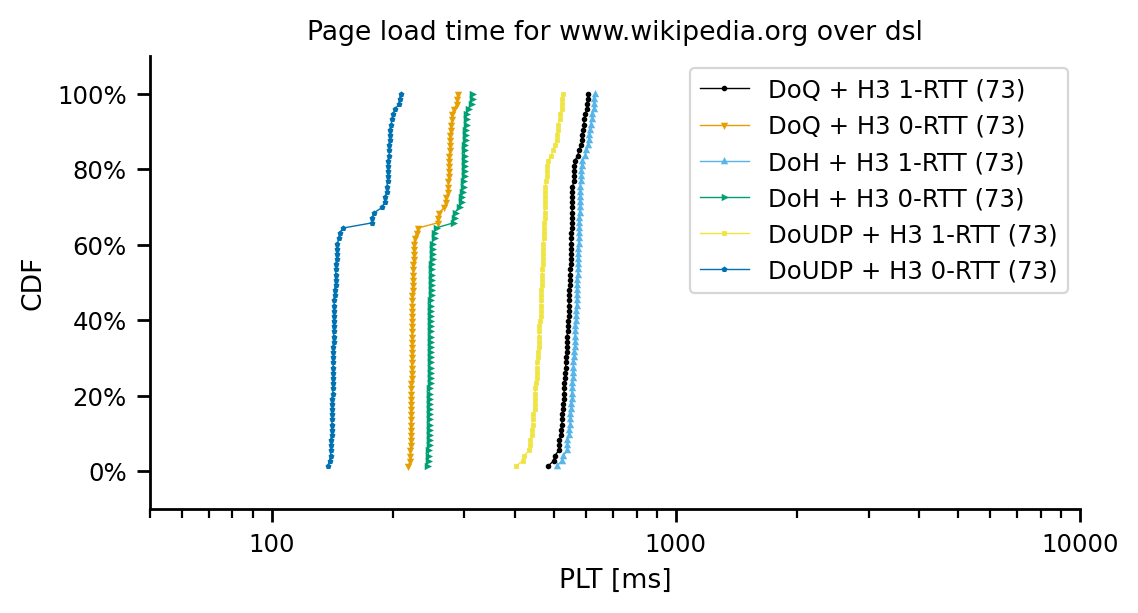

count     144.000000
mean     4680.589255
std         8.480879
min      4664.111522
10%      4670.594957
20%      4672.809352
25%      4674.074129
30%      4675.303396
40%      4677.184021
50%      4680.059207
60%      4682.337613
70%      4684.295696
75%      4685.695844
80%      4687.335359
90%      4691.602469
100%     4706.525727
max      4706.525727
Name: full_plt, dtype: float64
count    144.000000
mean     440.946894
std        6.659111
min      428.341473
10%      433.567585
20%      435.167643
25%      436.005741
30%      436.722655
40%      438.337106
50%      439.796412
60%      441.553001
70%      444.349648
75%      445.380716
80%      447.064569
90%      449.546795
100%     461.063948
max      461.063948
Name: full_plt, dtype: float64
count     144.000000
mean     4704.801204
std         8.491987
min      4688.430162
10%      4694.847743
20%      4696.732624
25%      4697.886777
30%      4699.208304
40%      4701.408145
50%      4704.547772
60%      4706.535551
70%      4

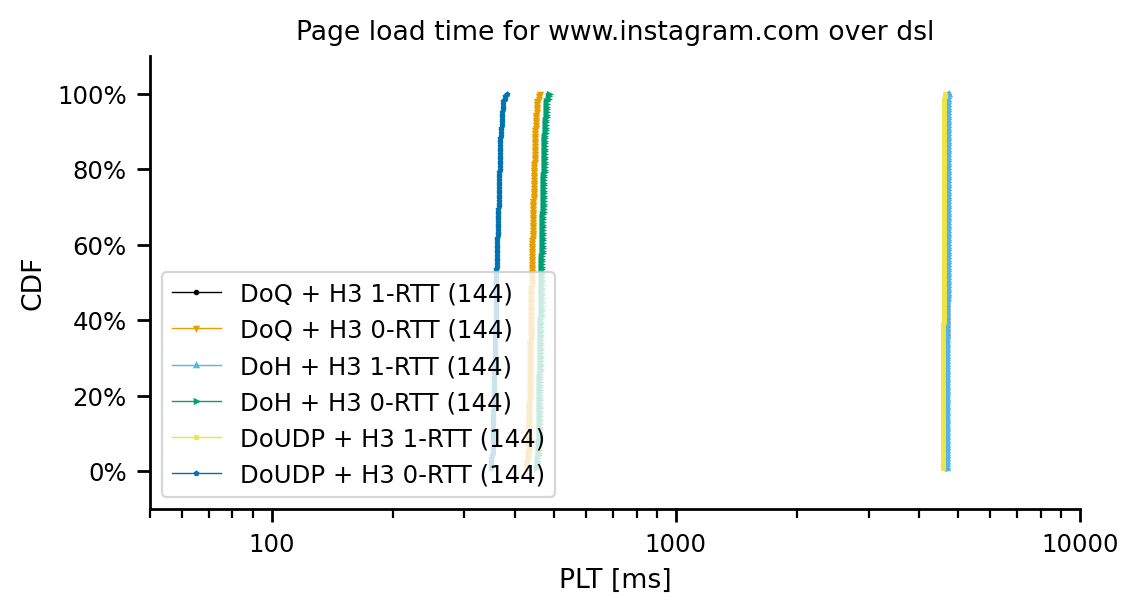

cable
count     74.000000
mean     195.039566
std        3.047782
min      184.020548
10%      192.070230
20%      193.445451
25%      194.196204
30%      194.572294
40%      195.127164
50%      195.818355
60%      196.248559
70%      196.739014
75%      196.960942
80%      197.148710
90%      197.538621
100%     199.916475
max      199.916475
Name: full_plt, dtype: float64
count     74.000000
mean     103.319296
std        0.844916
min      101.326085
10%      102.290896
20%      102.707943
25%      102.763468
30%      102.827217
40%      103.004592
50%      103.158568
60%      103.339057
70%      103.774818
75%      103.986819
80%      104.091617
90%      104.415178
100%     105.525883
max      105.525883
Name: full_plt, dtype: float64
count     74.000000
mean     218.504464
std        3.178606
min      207.434735
10%      215.028162
20%      217.022478
25%      217.455123
30%      218.258168
40%      218.763010
50%      219.304497
60%      219.775677
70%      220.231563
75%      220

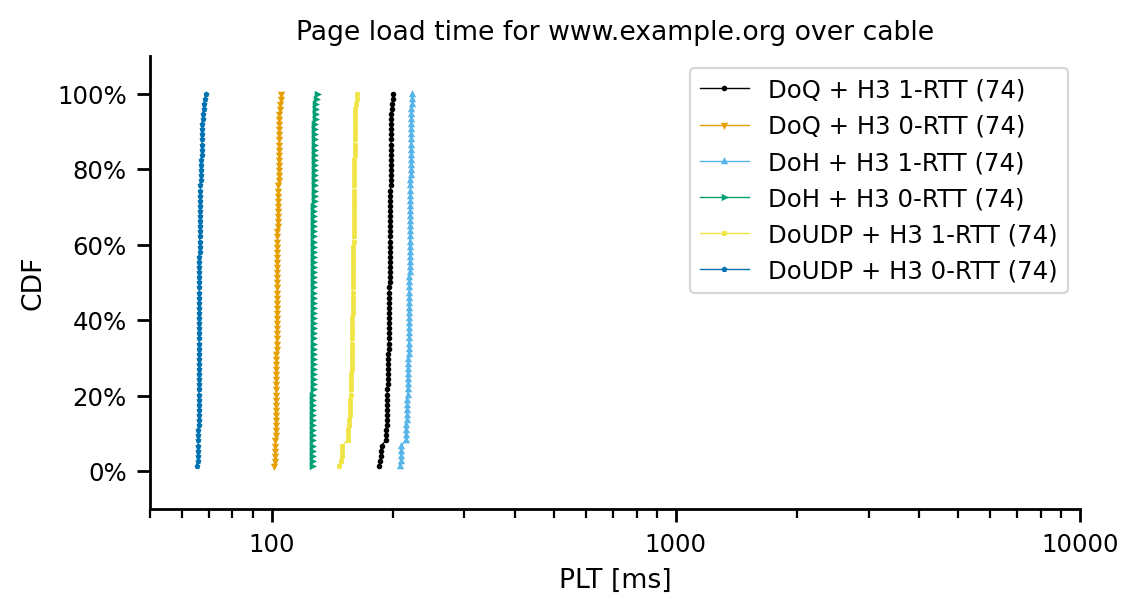

count     73.000000
mean     413.709563
std       16.867382
min      357.178960
10%      391.945618
20%      402.110266
25%      406.480850
30%      409.886135
40%      413.459372
50%      415.793284
60%      417.790395
70%      422.190486
75%      425.230386
80%      426.743397
90%      432.406615
100%     448.303892
max      448.303892
Name: full_plt, dtype: float64
count     73.000000
mean     151.405454
std       25.571049
min      123.913469
10%      127.523243
20%      128.218771
25%      128.689728
30%      128.987255
40%      130.735995
50%      133.235717
60%      170.267339
70%      175.360128
75%      178.513000
80%      179.304150
90%      184.530747
100%     195.551968
max      195.551968
Name: full_plt, dtype: float64
count     73.000000
mean     437.122077
std       16.919961
min      380.619845
10%      415.284990
20%      425.370226
25%      430.559820
30%      432.703372
40%      436.952909
50%      438.774643
60%      441.534326
70%      445.987814
75%      449.12514

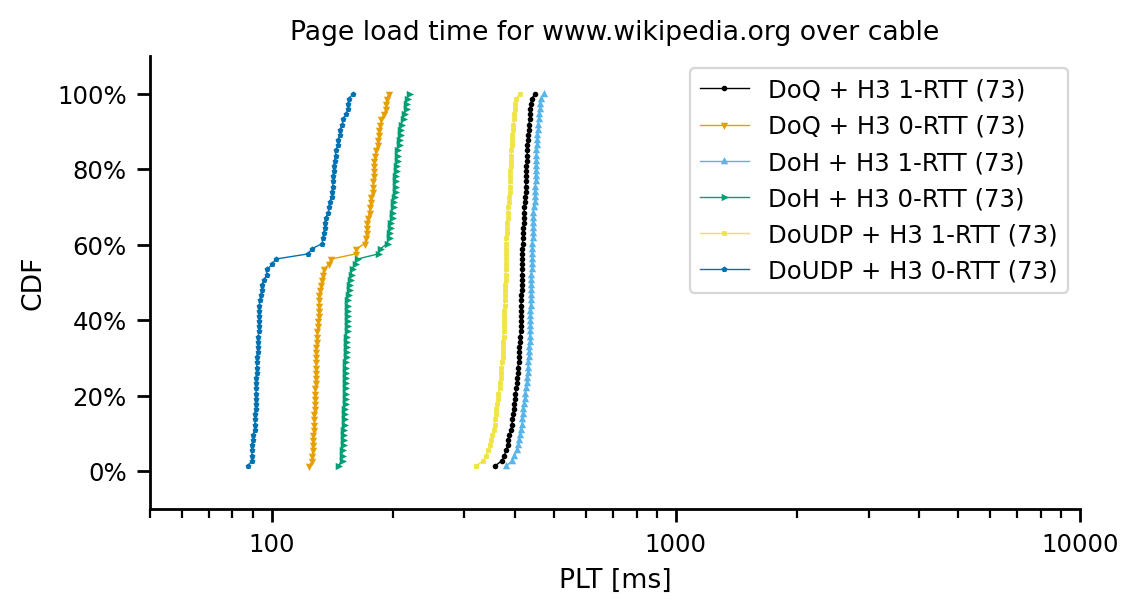

count    144.000000
mean     807.257672
std        7.170977
min      787.310488
10%      798.255772
20%      800.692785
25%      801.978273
30%      803.377180
40%      805.626754
50%      808.050490
60%      809.190313
70%      811.159514
75%      811.889425
80%      813.163810
90%      816.463052
100%     827.793060
max      827.793060
Name: full_plt, dtype: float64
count    144.000000
mean     252.792394
std        4.753539
min      244.818897
10%      246.847532
20%      248.415409
25%      248.727553
30%      249.181267
40%      251.033029
50%      252.357531
60%      253.707927
70%      255.570311
75%      256.490196
80%      257.343357
90%      258.946132
100%     265.106719
max      265.106719
Name: full_plt, dtype: float64
count    144.000000
mean     830.799667
std        7.145122
min      811.171514
10%      821.681215
20%      824.188790
25%      825.231479
30%      827.051435
40%      829.059446
50%      831.490776
60%      832.674924
70%      834.548219
75%      835.74939

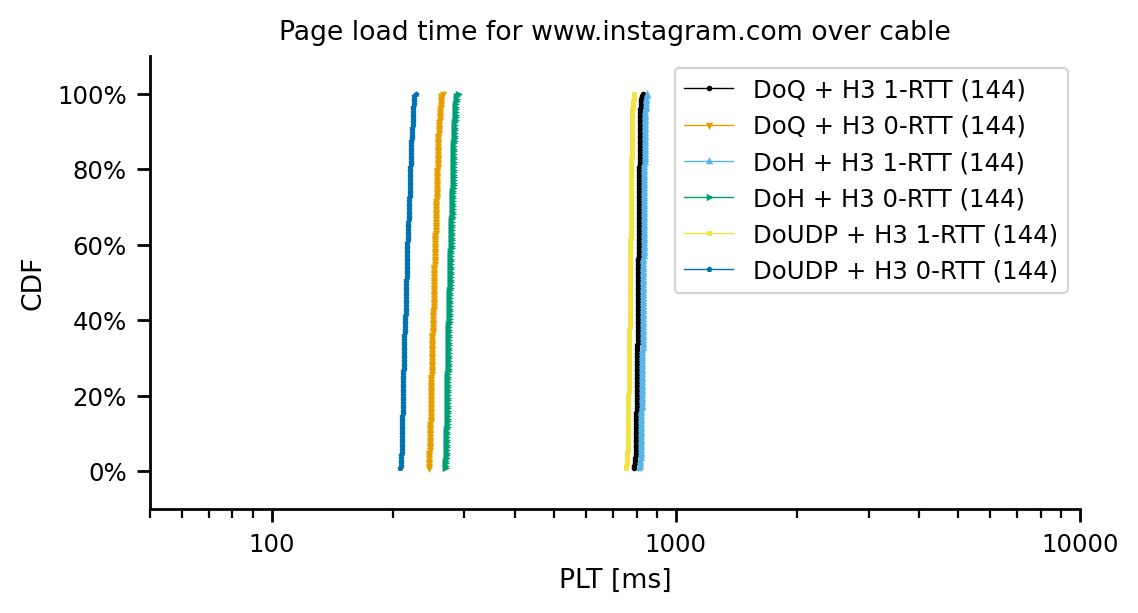

fiber
count     74.000000
mean     145.594751
std        3.756008
min      136.780924
10%      141.829504
20%      143.238989
25%      143.736473
30%      143.967452
40%      144.595225
50%      145.233291
60%      145.607749
70%      146.731858
75%      146.919271
80%      147.267167
90%      152.551026
100%     154.511316
max      154.511316
Name: full_plt, dtype: float64
count    74.000000
mean     70.227183
std       1.338508
min      66.776271
10%      68.549221
20%      69.463845
25%      69.525137
30%      69.731085
40%      69.915740
50%      70.195102
60%      70.342209
70%      70.605275
75%      71.199868
80%      71.315702
90%      71.861374
100%     73.409215
max      73.409215
Name: full_plt, dtype: float64
count     74.000000
mean     159.657220
std        3.671993
min      152.120518
10%      156.140727
20%      157.321562
25%      157.453350
30%      157.735454
40%      158.629922
50%      159.105577
60%      159.864391
70%      160.531707
75%      160.972021
80%      

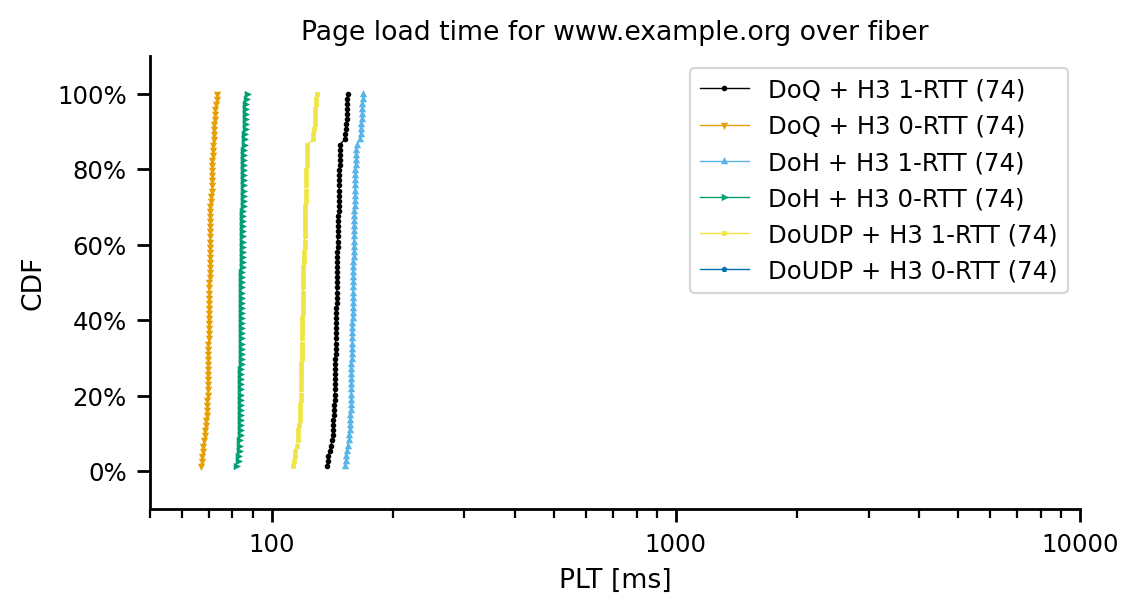

count     73.000000
mean     354.554281
std       21.414932
min      301.556608
10%      324.017836
20%      335.872784
25%      344.318662
30%      348.472607
40%      352.697673
50%      357.607013
60%      364.790197
70%      367.623753
75%      369.811215
80%      373.053737
90%      377.147058
100%     395.092832
max      395.092832
Name: full_plt, dtype: float64
count     73.000000
mean     114.404966
std       23.673624
min       91.384061
10%       94.818223
20%       95.838521
25%       96.300502
30%       96.721873
40%       97.720051
50%       99.020415
60%      103.011335
70%      134.063474
75%      135.396537
80%      142.071888
90%      147.876755
100%     172.011215
max      172.011215
Name: full_plt, dtype: float64
count     73.000000
mean     368.337528
std       21.392296
min      312.218612
10%      339.491649
20%      350.322634
25%      358.371260
30%      362.284150
40%      366.018606
50%      372.527134
60%      378.436575
70%      381.822185
75%      383.19034

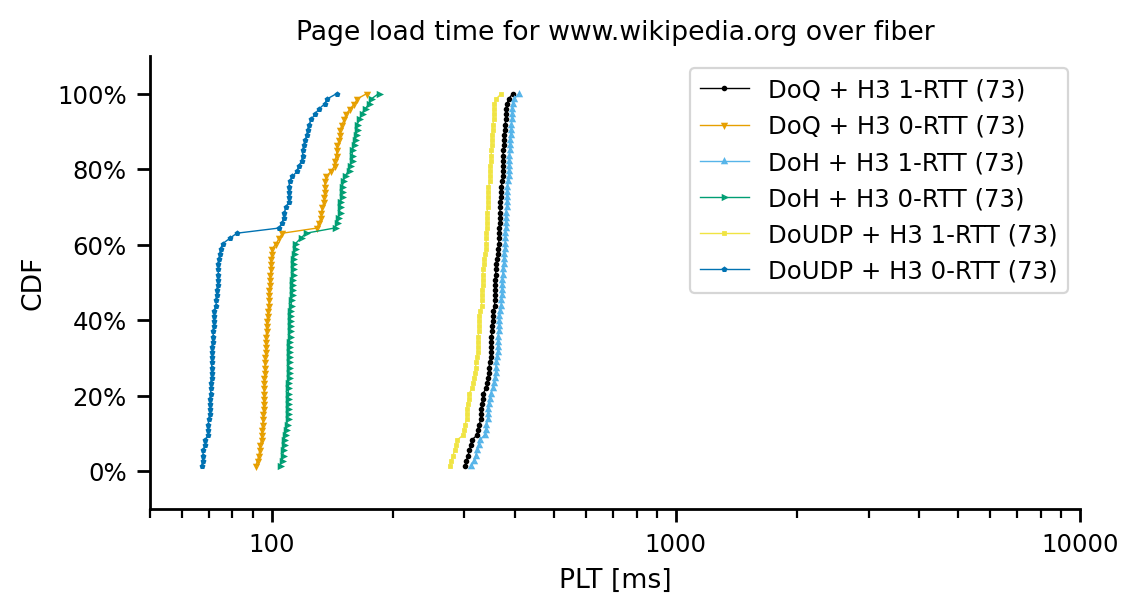

count    144.000000
mean     880.669798
std        7.863623
min      861.502321
10%      871.741785
20%      873.366514
25%      874.498062
30%      875.422740
40%      878.140938
50%      880.061252
60%      882.587590
70%      885.515394
75%      887.212261
80%      888.082922
90%      890.604230
100%     901.795615
max      901.795615
Name: full_plt, dtype: float64
count    144.000000
mean     212.435076
std        5.167295
min      202.014674
10%      206.529020
20%      208.025220
25%      208.710893
30%      209.275272
40%      210.662120
50%      211.581219
60%      213.074200
70%      214.714092
75%      215.552878
80%      216.212832
90%      219.960559
100%     227.070709
max      227.070709
Name: full_plt, dtype: float64
count    144.000000
mean     894.556124
std        7.742221
min      876.232742
10%      884.785283
20%      887.639824
25%      888.866238
30%      889.667892
40%      891.885622
50%      893.787619
60%      896.679970
70%      899.165078
75%      900.83791

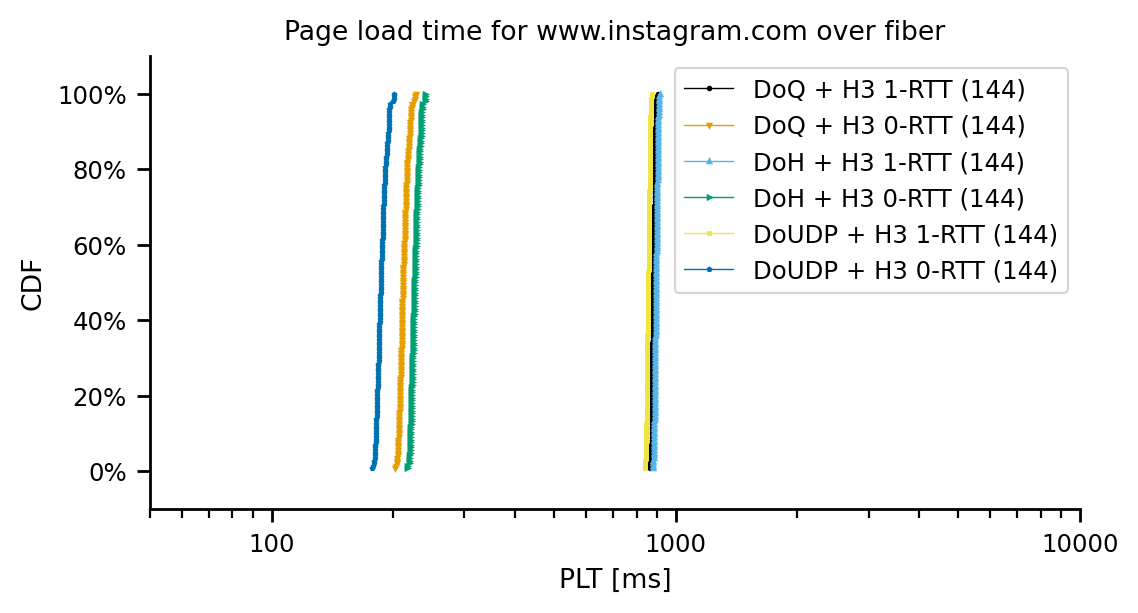

4g
count     73.000000
mean     462.338947
std        3.438704
min      442.502366
10%      459.657471
20%      460.755553
25%      461.173567
30%      461.691537
40%      462.558458
50%      462.969308
60%      463.392554
70%      463.749380
75%      463.966943
80%      464.617207
90%      465.564577
100%     467.666959
max      467.666959
Name: full_plt, dtype: float64
count     73.000000
mean     303.337577
std        1.166659
min      299.473331
10%      302.043709
20%      302.384459
25%      302.566959
30%      302.637471
40%      302.850943
50%      303.475936
60%      303.622651
70%      303.895592
75%      304.002157
80%      304.331584
90%      304.748570
100%     306.006050
max      306.006050
Name: full_plt, dtype: float64
count     73.000000
mean     553.073955
std        3.420664
min      533.114615
10%      551.029413
20%      551.407937
25%      552.176088
30%      552.330128
40%      553.005235
50%      553.545812
60%      554.071101
70%      554.458556
75%      554.59

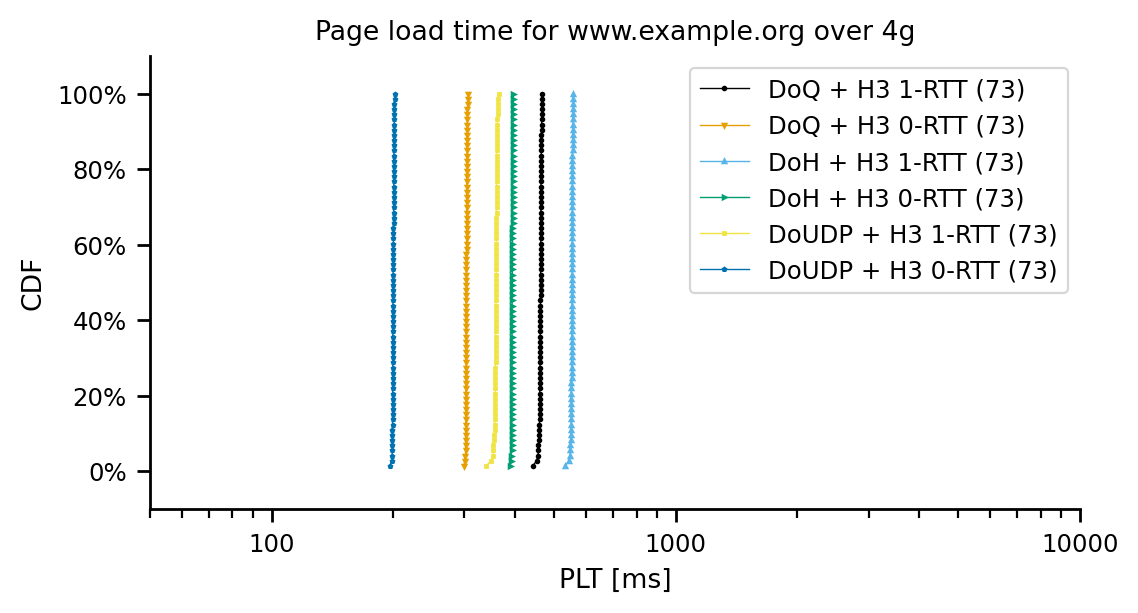

count     73.000000
mean     777.211348
std       32.410984
min      701.336436
10%      728.429787
20%      749.034469
25%      755.487480
30%      768.115241
40%      778.222399
50%      783.467660
60%      791.764181
70%      797.448553
75%      803.668380
80%      807.858641
90%      812.760453
100%     829.543307
max      829.543307
Name: full_plt, dtype: float64
count     73.000000
mean     350.231896
std       26.030694
min      324.448796
10%      327.956596
20%      328.906476
25%      329.539371
30%      329.978820
40%      330.908059
50%      332.087626
60%      339.642988
70%      374.886130
75%      378.356248
80%      382.070579
90%      386.397058
100%     398.428203
max      398.428203
Name: full_plt, dtype: float64
count     73.000000
mean     868.098098
std       32.286213
min      791.580619
10%      818.680229
20%      839.705089
25%      846.479585
30%      859.199181
40%      869.186197
50%      873.054114
60%      882.571179
70%      889.296746
75%      894.03820

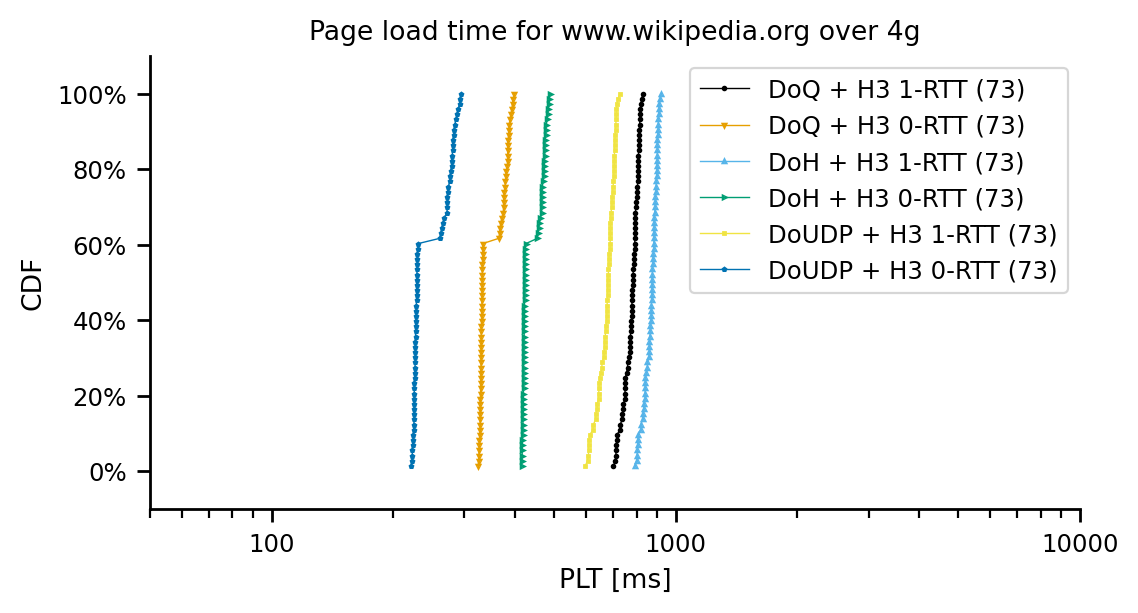

count     144.000000
mean     1891.533348
std         9.957608
min      1868.872319
10%      1880.284491
20%      1883.141501
25%      1884.640281
30%      1886.337888
40%      1888.663685
50%      1891.030276
60%      1893.361034
70%      1895.605423
75%      1897.013089
80%      1898.053579
90%      1902.506612
100%     1942.691838
max      1942.691838
Name: full_plt, dtype: float64
count    144.000000
mean     523.376404
std        4.178571
min      514.747148
10%      518.988849
20%      519.836809
25%      520.127856
30%      520.676775
40%      521.683752
50%      522.502393
60%      523.642712
70%      525.250476
75%      525.895675
80%      527.015466
90%      530.021399
100%     533.362202
max      533.362202
Name: full_plt, dtype: float64
count     144.000000
mean     1982.467406
std        10.119330
min      1958.190634
10%      1971.496743
20%      1973.964538
25%      1975.535205
30%      1977.533873
40%      1979.393902
50%      1982.136064
60%      1984.302300
70%      1

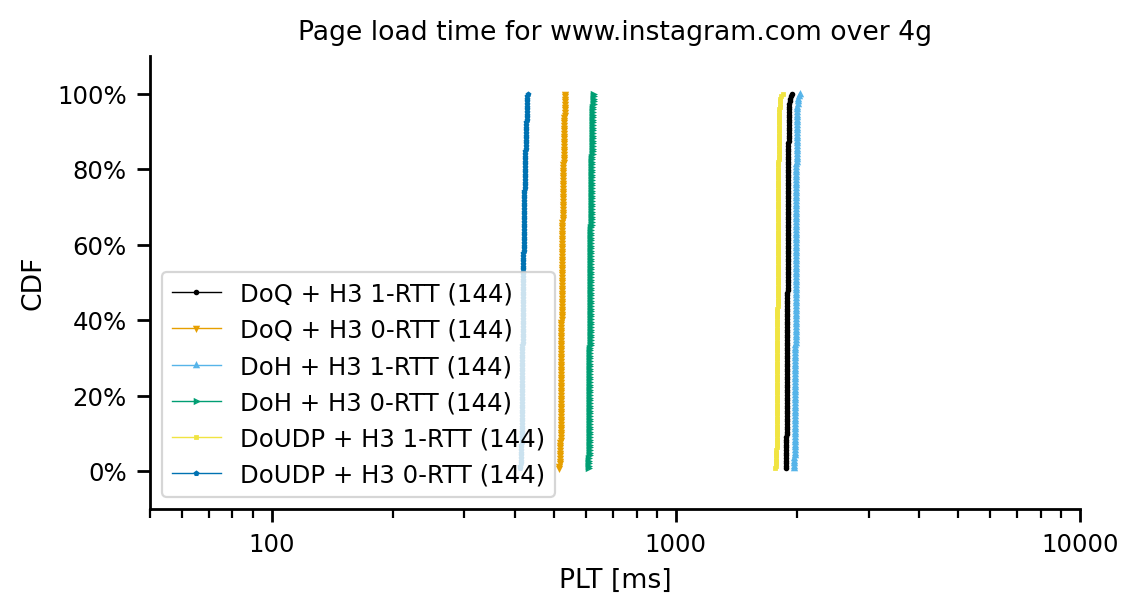

4g-medium
count     73.000000
mean     519.929858
std        3.620297
min      508.185984
10%      516.105453
20%      518.262895
25%      518.434110
30%      519.112099
40%      519.665107
50%      520.313856
60%      520.883074
70%      521.339647
75%      521.584369
80%      522.300936
90%      523.367769
100%     532.008160
max      532.008160
Name: full_plt, dtype: float64
count     73.000000
mean     347.329858
std        1.037192
min      343.885029
10%      346.248954
20%      346.420015
25%      346.551864
30%      346.643767
40%      347.075413
50%      347.458341
60%      347.530901
70%      347.744894
75%      347.950818
80%      348.253931
90%      348.833751
100%     349.129881
max      349.129881
Name: full_plt, dtype: float64
count     73.000000
mean     620.778888
std        3.748668
min      609.578902
10%      615.130901
20%      618.714079
25%      619.077272
30%      619.774275
40%      620.521527
50%      621.156539
60%      621.963391
70%      622.597978
75%     

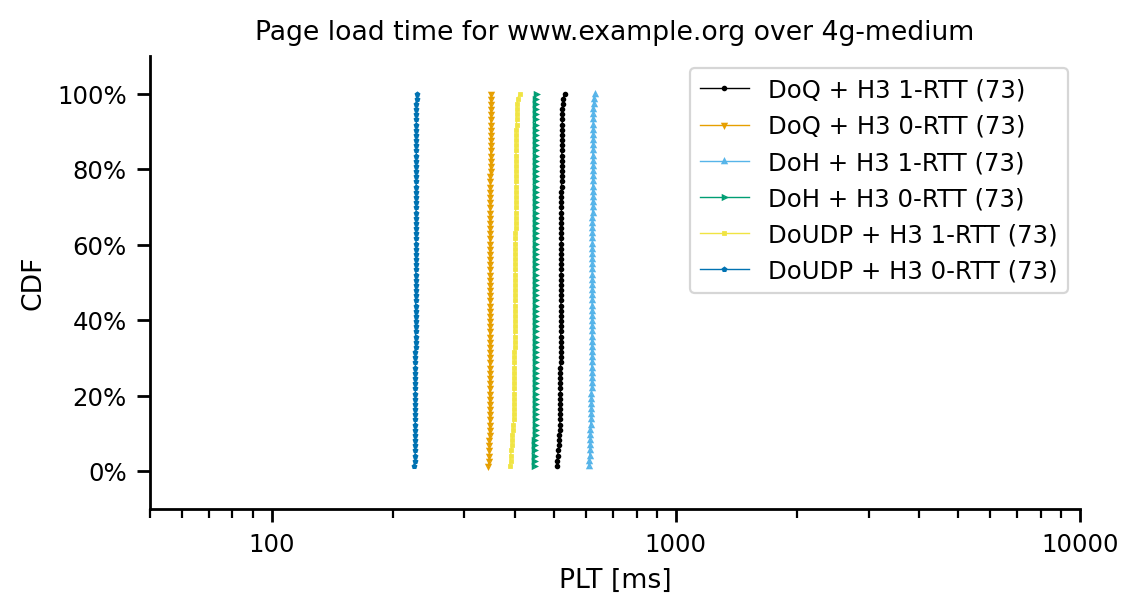

count     73.000000
mean     851.753643
std       28.214690
min      782.941623
10%      817.433121
20%      833.803891
25%      837.072327
30%      839.140918
40%      847.713947
50%      853.376382
60%      861.637946
70%      865.764219
75%      870.735132
80%      878.176058
90%      883.714394
100%     917.058305
max      917.058305
Name: full_plt, dtype: float64
count     73.000000
mean     388.586520
std       24.412848
min      364.348610
10%      370.534599
20%      371.495350
25%      372.123687
30%      372.546248
40%      373.661655
50%      374.425028
60%      375.259651
70%      393.852697
75%      416.437022
80%      420.370795
90%      425.908661
100%     443.544763
max      443.544763
Name: full_plt, dtype: float64
count      73.000000
mean      952.988164
std        28.392594
min       883.507383
10%       918.631241
20%       935.155383
25%       938.764979
30%       940.257045
40%       947.738746
50%       952.988786
60%       963.230899
70%       967.461414
75%   

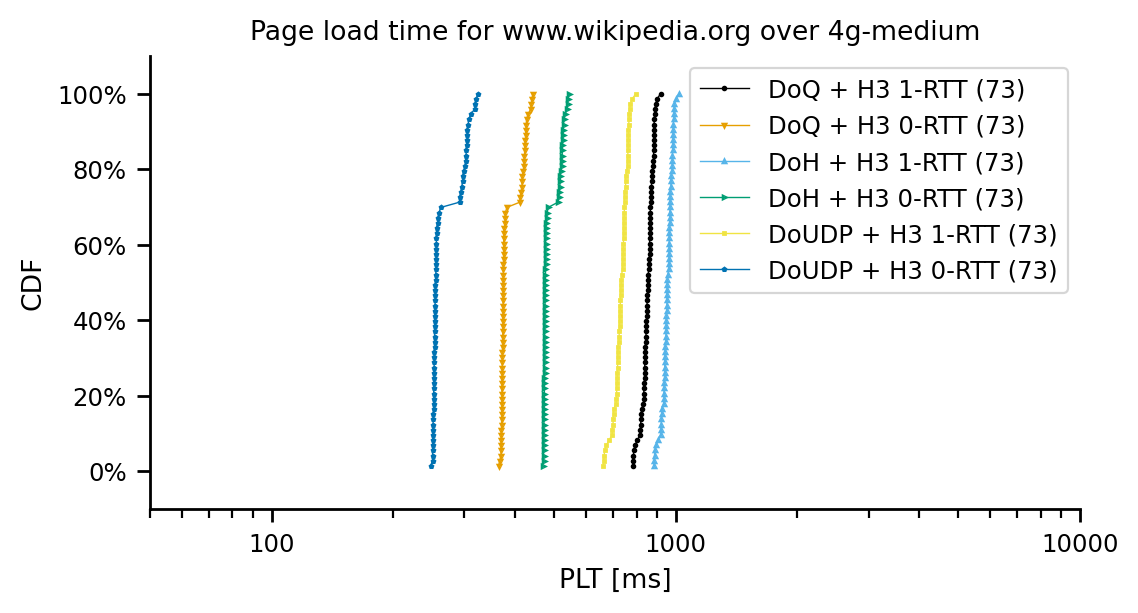

count     144.000000
mean     2623.021762
std         9.555041
min      2599.971030
10%      2610.931169
20%      2614.960636
25%      2615.892201
30%      2618.932248
40%      2620.486089
50%      2623.072340
60%      2625.459075
70%      2627.363453
75%      2630.381083
80%      2631.361515
90%      2635.853550
100%     2645.953927
max      2645.953927
Name: full_plt, dtype: float64
count    144.000000
mean     586.276623
std        5.046247
min      576.070612
10%      580.599644
20%      582.253689
25%      582.803278
30%      583.178479
40%      583.996796
50%      585.172745
60%      586.446560
70%      588.833100
75%      590.069472
80%      591.205565
90%      592.916147
100%     605.283099
max      605.283099
Name: full_plt, dtype: float64
count     144.000000
mean     2724.083411
std         9.602395
min      2700.792684
10%      2710.882727
20%      2715.574962
25%      2717.412012
30%      2719.368041
40%      2721.395953
50%      2724.383775
60%      2726.636854
70%      2

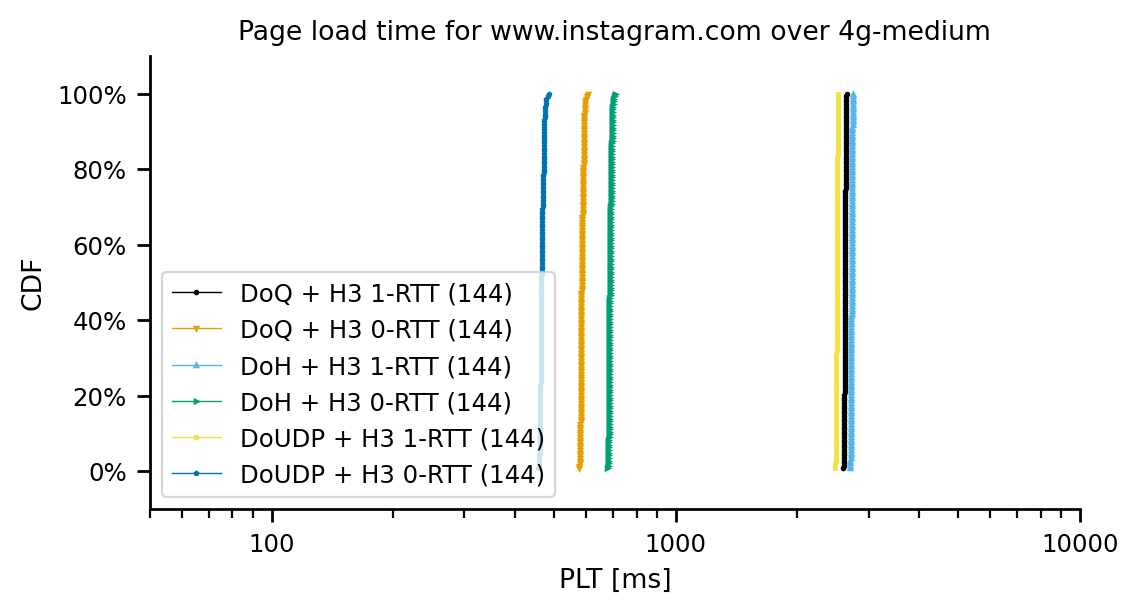

In [20]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

dsl
count     74.000000
mean     317.959574
std        4.756646
min      310.141222
10%      313.389800
20%      314.558872
25%      315.073307
30%      315.715170
40%      316.433739
50%      316.974263
60%      317.488646
70%      318.238257
75%      318.616704
80%      318.994249
90%      327.515069
100%     331.397236
max      331.397236
Name: full_fcp, dtype: float64
count     74.000000
mean     207.585250
std        3.478305
min      201.196947
10%      202.638735
20%      203.575959
25%      204.001723
30%      204.860823
40%      207.247080
50%      208.755036
60%      209.199930
70%      209.945704
75%      210.251149
80%      210.403961
90%      211.743870
100%     213.498995
max      213.498995
Name: full_fcp, dtype: float64
count     74.000000
mean     342.143365
std        4.664904
min      334.277740
10%      337.843077
20%      339.438048
25%      339.663697
30%      340.044772
40%      340.564461
50%      341.199561
60%      341.586957
70%      342.269635
75%      342.5

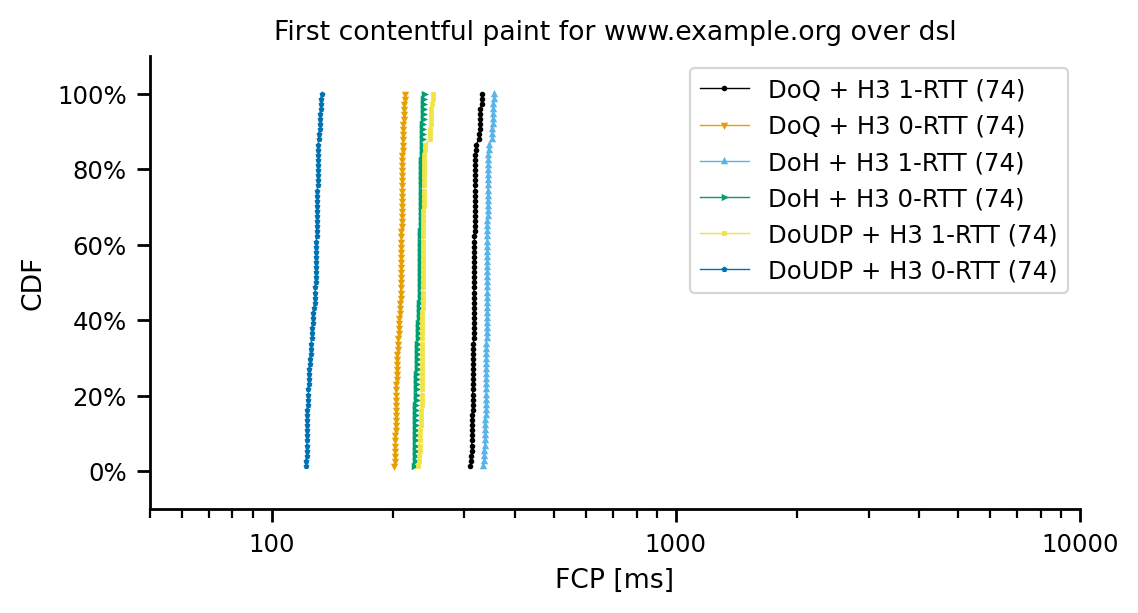

count     73.000000
mean     437.846321
std       41.852634
min      376.781120
10%      406.701441
20%      410.054857
25%      411.652393
30%      412.839059
40%      415.199581
50%      421.499844
60%      424.936934
70%      432.776198
75%      438.519001
80%      493.677797
90%      510.463987
100%     543.107453
max      543.107453
Name: full_fcp, dtype: float64
count     73.000000
mean     216.364129
std       16.068354
min      208.868659
10%      210.362863
20%      211.111810
25%      211.254973
30%      211.373707
40%      211.789459
50%      212.003466
60%      212.548833
70%      212.842109
75%      213.138112
80%      213.406591
90%      215.237610
100%     285.599844
max      285.599844
Name: full_fcp, dtype: float64
count     73.000000
mean     461.977680
std       41.855629
min      400.973238
10%      429.886027
20%      433.731510
25%      435.485877
30%      437.263293
40%      439.366702
50%      445.957042
60%      449.402502
70%      455.903963
75%      462.15437

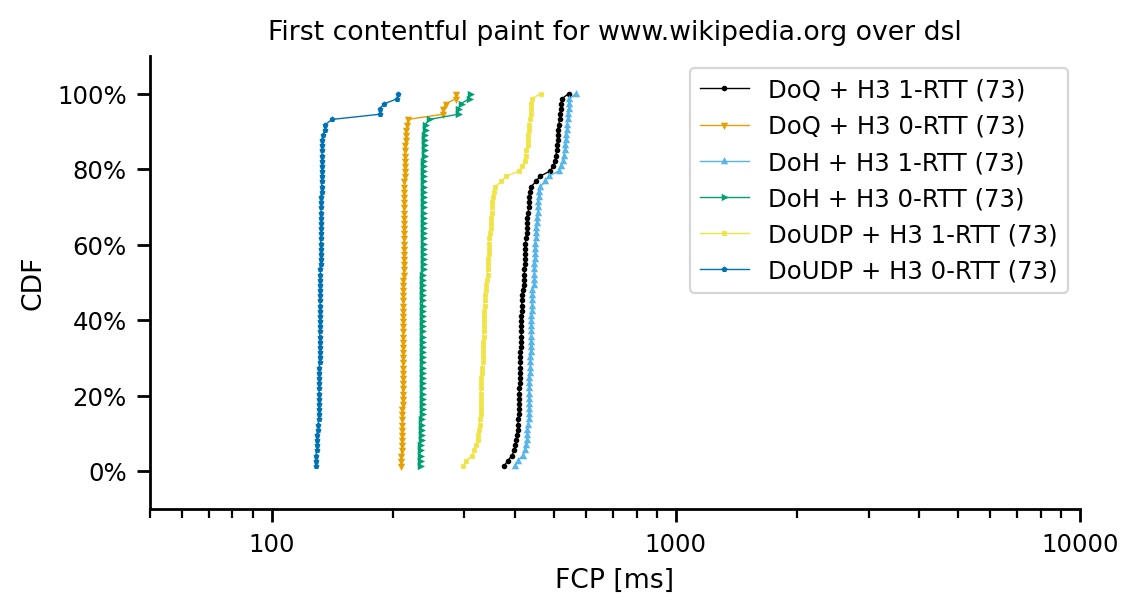

count    144.000000
mean     325.071894
std        7.603142
min      308.392405
10%      316.016205
20%      319.162608
25%      320.159566
30%      320.951139
40%      322.470977
50%      323.866244
60%      325.534855
70%      327.761751
75%      328.388444
80%      329.883189
90%      335.583352
100%     348.325727
max      348.325727
Name: full_fcp, dtype: float64
count    144.000000
mean     227.498283
std        7.829831
min      198.599342
10%      223.515296
20%      225.474036
25%      226.260800
30%      226.550368
40%      227.232572
50%      227.809937
60%      228.517464
70%      229.924848
75%      230.868735
80%      232.039265
90%      235.188566
100%     244.112902
max      244.112902
Name: full_fcp, dtype: float64
count    144.000000
mean     349.283842
std        7.729225
min      332.685903
10%      340.614223
20%      343.270090
25%      344.636667
30%      345.191315
40%      346.765248
50%      348.381863
60%      349.650937
70%      351.720575
75%      352.74070

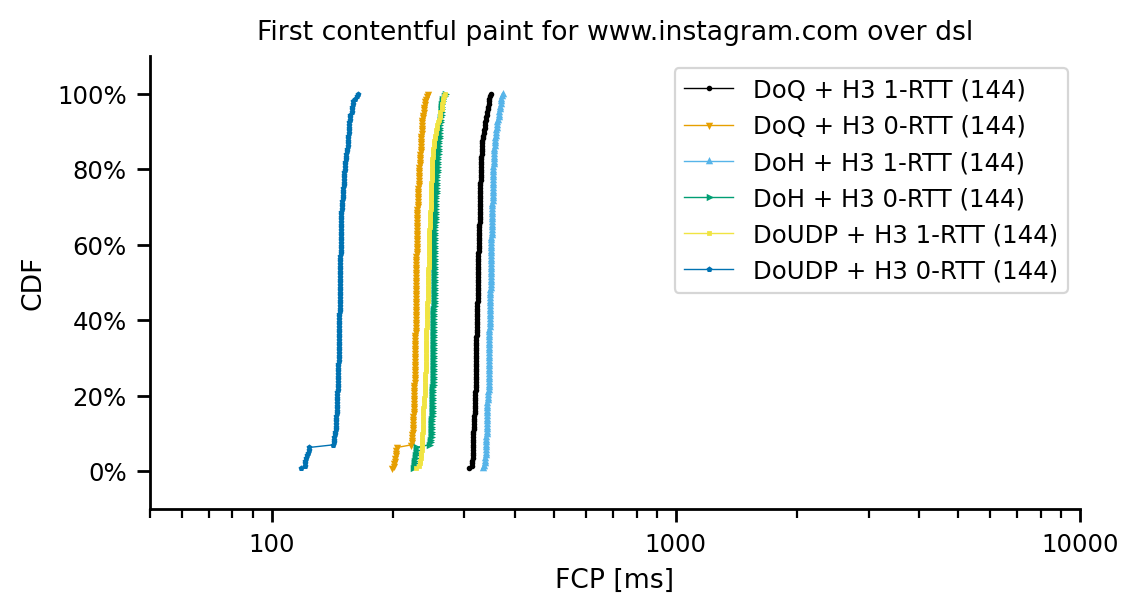

cable
count     74.000000
mean     201.105782
std        2.153965
min      195.199608
10%      197.401827
20%      199.891326
25%      200.216628
30%      200.354818
40%      200.879196
50%      201.264442
60%      201.820032
70%      202.174286
75%      202.402268
80%      202.754727
90%      203.348287
100%     205.760727
max      205.760727
Name: full_fcp, dtype: float64
count     74.000000
mean     114.034161
std        3.678570
min      106.626085
10%      109.272409
20%      109.854450
25%      110.347455
30%      111.212252
40%      113.086629
50%      114.423427
60%      115.587632
70%      116.660183
75%      117.233574
80%      117.509712
90%      118.719489
100%     120.885645
max      120.885645
Name: full_fcp, dtype: float64
count     74.000000
mean     224.570680
std        2.224505
min      218.338769
10%      221.295506
20%      222.719363
25%      223.882238
30%      223.980009
40%      224.388762
50%      225.128569
60%      225.378583
70%      225.855429
75%      226

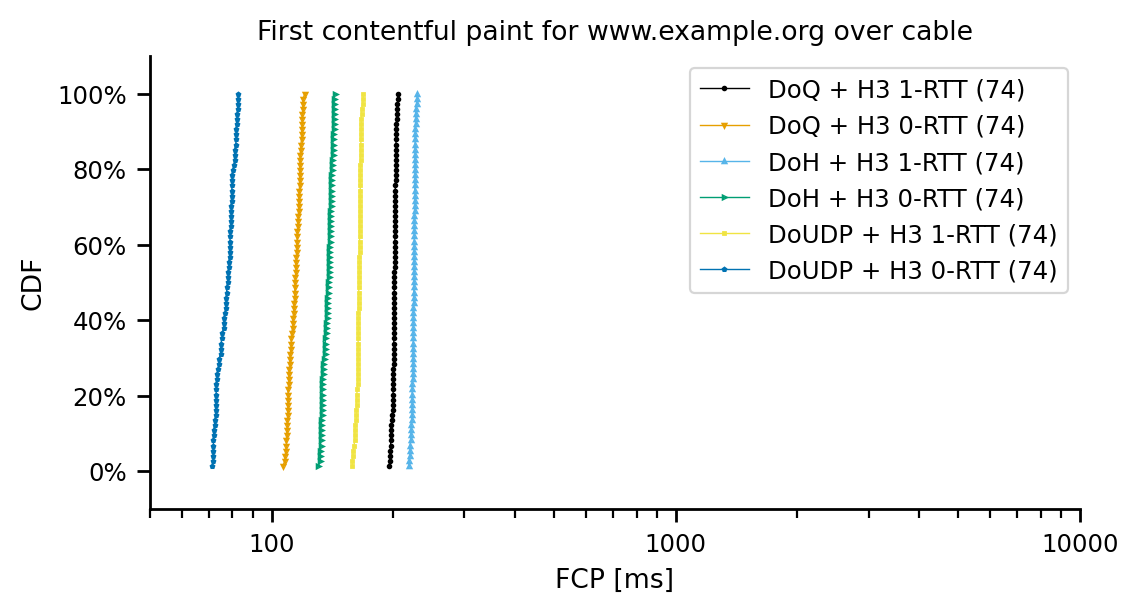

count     73.000000
mean     384.684906
std       46.312162
min      246.889983
10%      298.140284
20%      370.229466
25%      377.253469
30%      380.466988
40%      391.881923
50%      402.524399
60%      407.671725
70%      409.697507
75%      411.421892
80%      413.941635
90%      422.079097
100%     433.905812
max      433.905812
Name: full_fcp, dtype: float64
count     73.000000
mean     123.510933
std       16.693876
min      114.547773
10%      116.521799
20%      117.585991
25%      117.695135
30%      117.803847
40%      118.146380
50%      118.649623
60%      119.087756
70%      119.636315
75%      120.141996
80%      120.962688
90%      122.258319
100%     186.448233
max      186.448233
Name: full_fcp, dtype: float64
count     73.000000
mean     408.097419
std       46.496907
min      270.189364
10%      321.463160
20%      393.581131
25%      401.416854
30%      403.816044
40%      415.944594
50%      425.693973
60%      431.238772
70%      432.927581
75%      434.33889

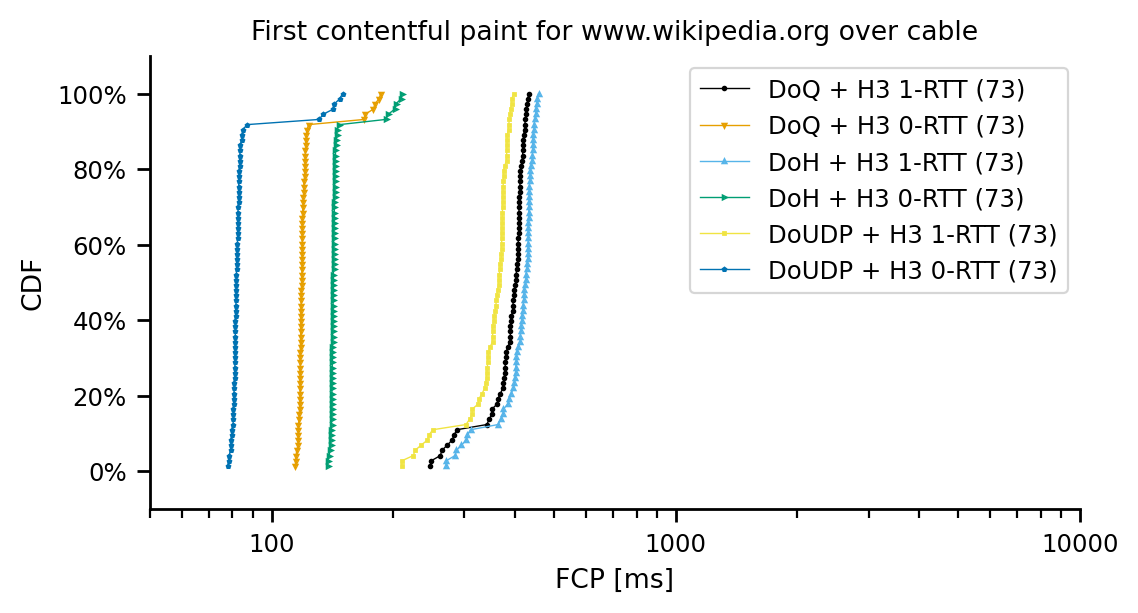

count    144.000000
mean     209.393089
std        6.134025
min      194.196752
10%      201.722856
20%      203.789041
25%      204.571852
30%      205.766552
40%      207.752063
50%      209.907240
60%      211.298976
70%      213.260722
75%      214.076651
80%      214.961941
90%      216.672108
100%     222.836312
max      222.836312
Name: full_fcp, dtype: float64
count    144.000000
mean     144.520172
std        4.863518
min      119.031126
10%      140.565728
20%      141.755989
25%      141.941157
30%      142.189405
40%      142.645012
50%      143.359019
60%      144.761497
70%      146.685194
75%      147.417502
80%      148.290466
90%      151.133983
100%     156.277571
max      156.277571
Name: full_fcp, dtype: float64
count    144.000000
mean     232.935084
std        6.130156
min      217.264006
10%      224.766317
20%      227.364469
25%      227.943015
30%      229.113492
40%      231.590090
50%      233.754078
60%      235.169069
70%      236.752791
75%      238.00343

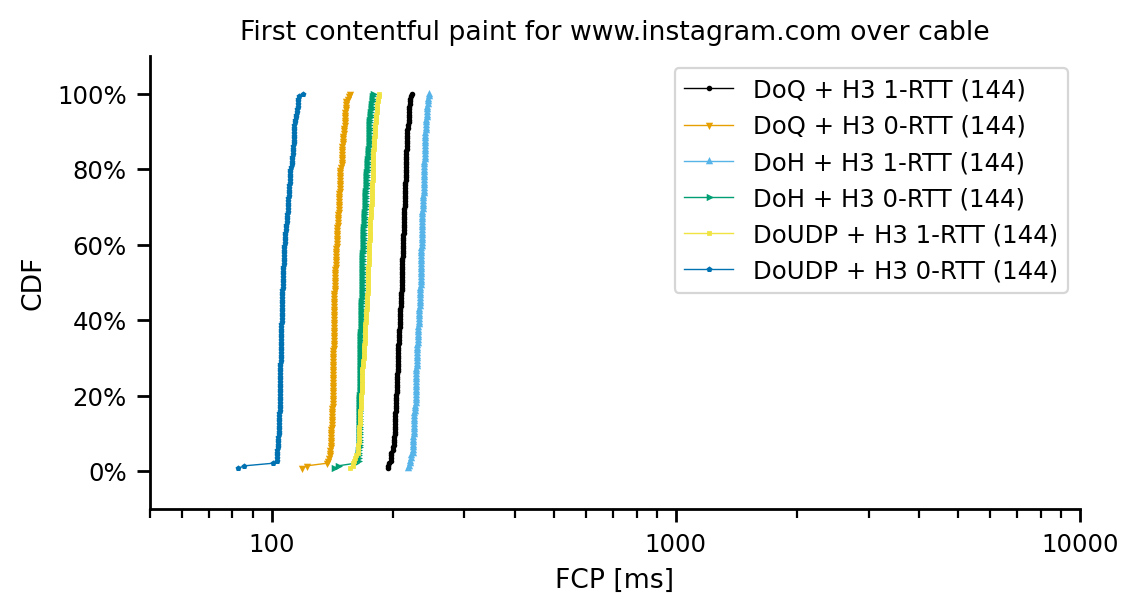

fiber
count     74.000000
mean     157.259616
std        2.430130
min      148.980924
10%      154.521493
20%      155.585520
25%      156.038647
30%      156.503954
40%      157.083763
50%      157.769405
60%      158.423131
70%      158.755388
75%      159.091781
80%      159.225659
90%      159.470486
100%     161.722280
max      161.722280
Name: full_fcp, dtype: float64
count    74.000000
mean     80.305562
std       3.750450
min      72.360761
10%      75.840995
20%      76.515215
25%      76.827285
30%      77.802144
40%      79.642199
50%      80.969970
60%      82.247827
70%      82.762609
75%      83.004019
80%      83.550069
90%      84.869878
100%     86.703751
max      86.703751
Name: full_fcp, dtype: float64
count     74.000000
mean     171.322085
std        2.294835
min      164.820518
10%      168.570907
20%      169.379509
25%      170.166732
30%      170.444555
40%      171.118786
50%      171.627691
60%      172.081836
70%      172.616339
75%      172.947445
80%      

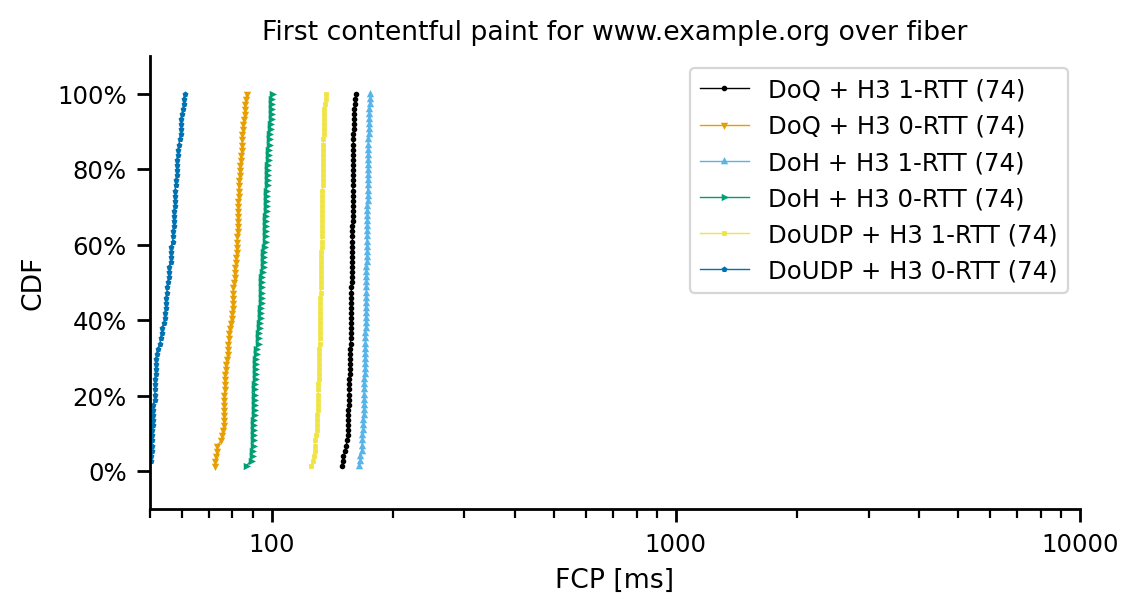

count     73.000000
mean     280.998117
std       69.798167
min      188.173321
10%      205.498288
20%      216.182176
25%      218.918662
30%      221.794427
40%      228.312383
50%      238.085080
60%      326.651232
70%      351.306859
75%      357.112430
80%      359.282459
90%      366.016270
100%     388.392832
max      388.392832
Name: full_fcp, dtype: float64
count     73.000000
mean      99.509076
std       25.028214
min       80.596965
10%       84.100239
20%       84.993853
25%       85.139093
30%       85.364556
40%       85.799643
50%       86.512204
60%       87.584448
70%       91.118434
75%       92.785749
80%      138.370541
90%      143.337989
100%     160.963722
max      160.963722
Name: full_fcp, dtype: float64
count     73.000000
mean     294.781363
std       69.718821
min      201.526892
10%      219.429253
20%      230.326243
25%      232.485536
30%      236.224119
40%      242.167336
50%      252.260064
60%      339.191607
70%      365.145535
75%      370.56679

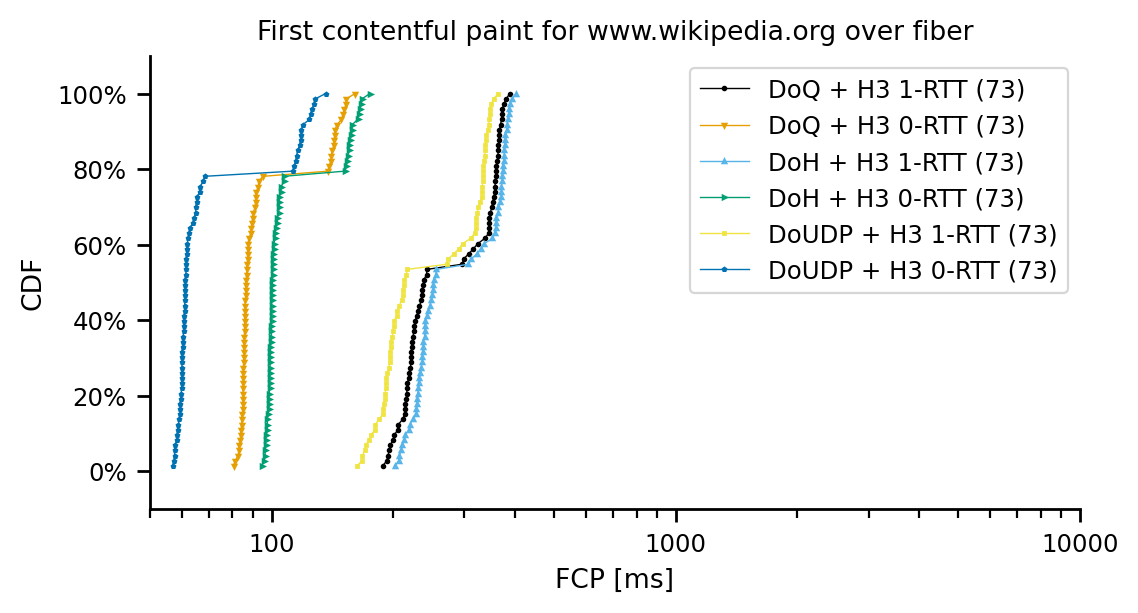

count    144.000000
mean     161.011464
std        7.437351
min      149.017090
10%      152.456320
20%      154.445141
25%      155.172137
30%      155.660039
40%      157.038560
50%      159.035733
60%      161.909609
70%      165.725722
75%      167.317405
80%      169.097334
90%      171.925167
100%     178.107651
max      178.107651
Name: full_fcp, dtype: float64
count    144.000000
mean     112.531603
std        4.079642
min      104.902321
10%      108.452186
20%      109.201837
25%      109.583792
30%      109.872581
40%      110.388345
50%      111.010076
60%      112.520148
70%      113.795740
75%      114.408043
80%      116.563130
90%      119.144124
100%     123.844382
max      123.844382
Name: full_fcp, dtype: float64
count    144.000000
mean     174.897790
std        7.287117
min      161.796345
10%      166.527502
20%      168.585703
25%      169.078701
30%      169.880022
40%      170.901840
50%      173.358074
60%      175.323195
70%      179.382456
75%      181.07626

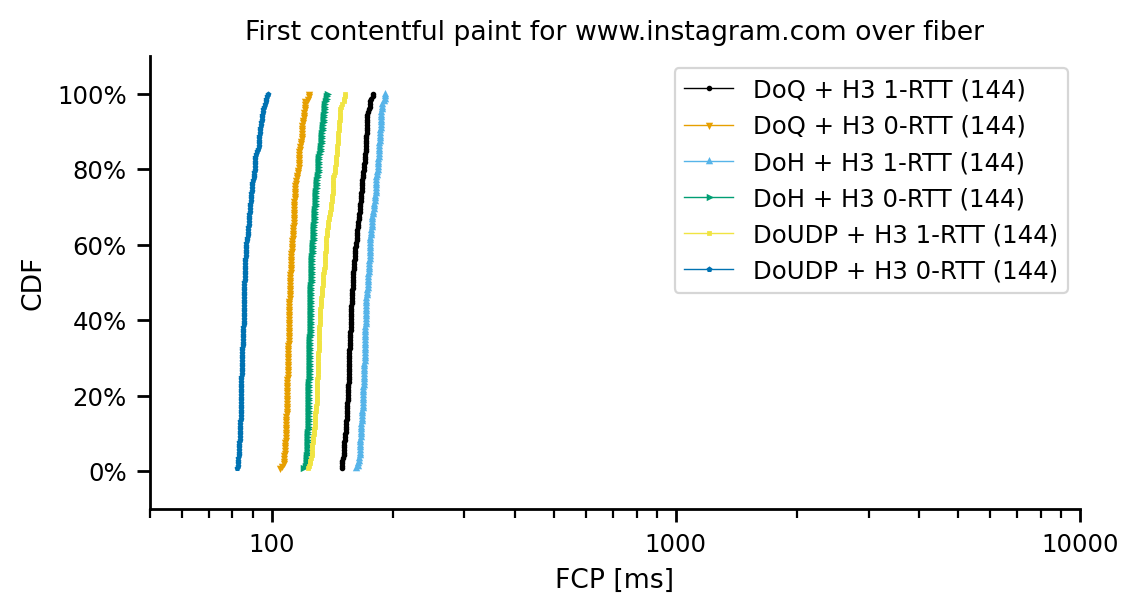

4g
count     73.000000
mean     468.434838
std        2.933435
min      454.702366
10%      465.665917
20%      466.730432
25%      466.819023
30%      467.171346
40%      468.052340
50%      468.438643
60%      468.969974
70%      469.986114
75%      470.389969
80%      470.857345
90%      471.570757
100%     473.636770
max      473.636770
Name: full_fcp, dtype: float64
count     73.000000
mean     312.708810
std        3.404872
min      307.162404
10%      308.739902
20%      309.429332
25%      309.824764
30%      310.237919
40%      311.073597
50%      312.117293
60%      313.683625
70%      314.901265
75%      315.301502
80%      315.754063
90%      317.472128
100%     319.103371
max      319.103371
Name: full_fcp, dtype: float64
count     73.000000
mean     559.169845
std        2.919451
min      545.314615
10%      556.108497
20%      557.202364
25%      557.861914
30%      558.104117
40%      558.798181
50%      559.378318
60%      559.528476
70%      560.305148
75%      560.88

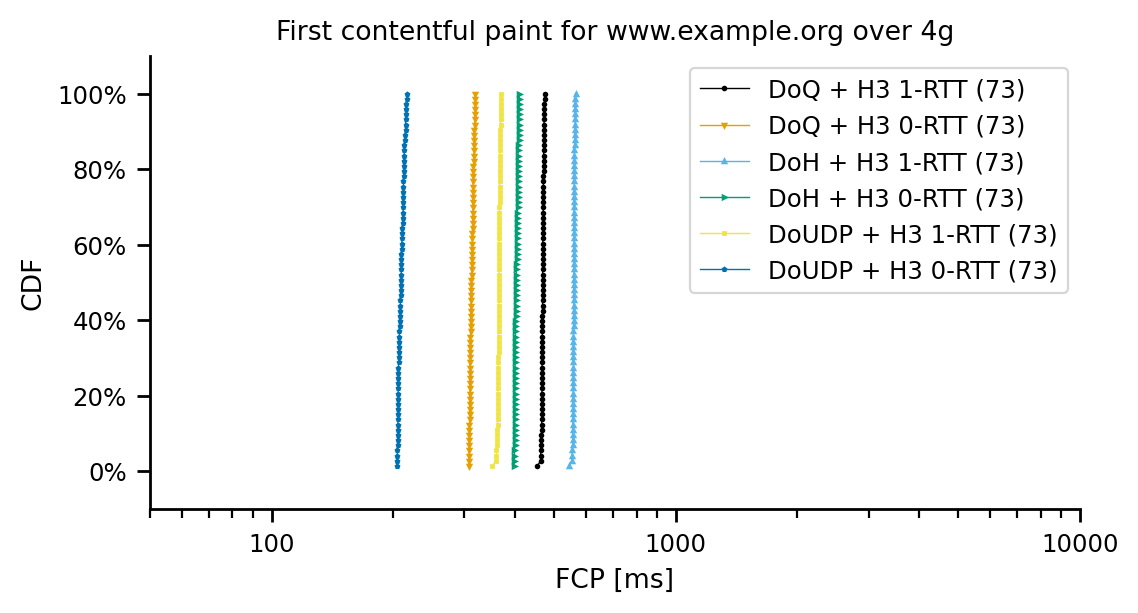

count     73.000000
mean     647.767513
std       43.513381
min      555.664700
10%      577.049983
20%      602.731674
25%      623.953082
30%      628.848154
40%      644.081302
50%      657.199164
60%      667.163799
70%      680.712227
75%      685.228203
80%      689.049688
90%      695.953802
100%     713.643307
max      713.643307
Name: full_fcp, dtype: float64
count     73.000000
mean     326.903129
std       22.014825
min      313.648796
10%      316.852375
20%      317.420845
25%      317.623080
30%      317.702728
40%      317.958438
50%      318.239371
60%      318.804802
70%      319.302614
75%      320.035735
80%      320.941775
90%      375.082033
100%     391.875286
max      391.875286
Name: full_fcp, dtype: float64
count     73.000000
mean     738.654262
std       43.377331
min      646.977627
10%      667.876436
20%      693.834698
25%      713.881107
30%      719.331554
40%      735.149439
50%      747.880263
60%      758.214539
70%      771.663727
75%      777.36542

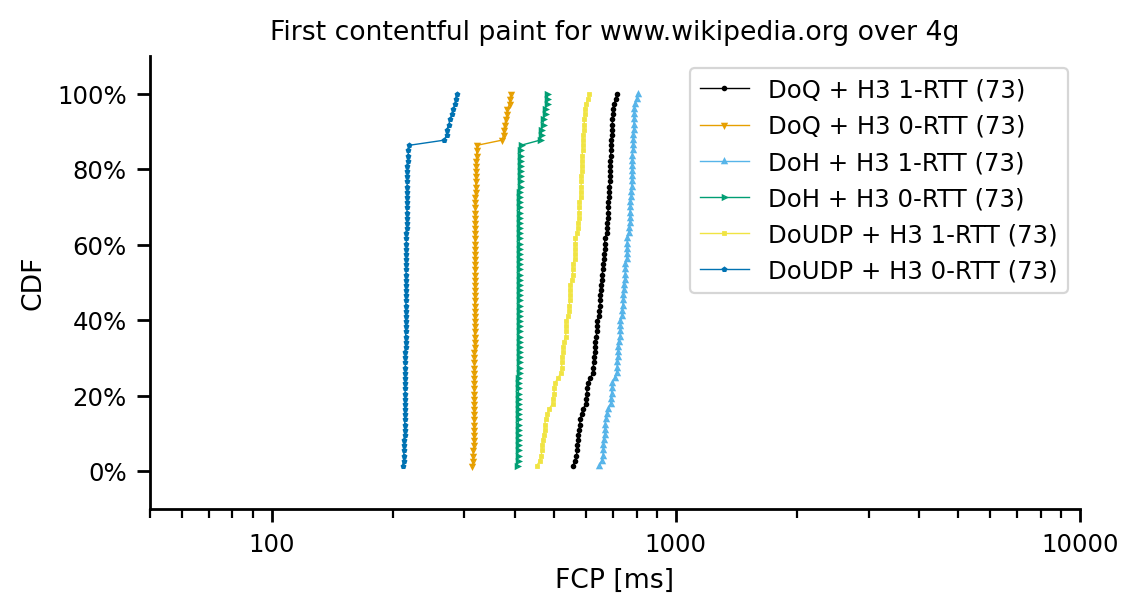

count    144.000000
mean     476.510432
std        6.038969
min      466.119225
10%      469.303389
20%      470.663151
25%      471.540948
30%      472.466553
40%      474.216188
50%      476.674887
60%      478.156078
70%      479.609008
75%      480.726452
80%      481.573937
90%      483.443348
100%     505.324998
max      505.324998
Name: full_fcp, dtype: float64
count    144.000000
mean     344.497932
std        5.609570
min      315.576657
10%      341.789420
20%      342.784859
25%      343.106563
30%      343.350379
40%      343.728518
50%      344.421620
60%      344.990595
70%      345.791305
75%      346.354133
80%      346.843753
90%      350.031694
100%     354.750002
max      354.750002
Name: full_fcp, dtype: float64
count    144.000000
mean     567.444489
std        6.004025
min      555.601706
10%      560.417328
20%      561.686863
25%      562.771014
30%      563.195997
40%      565.479428
50%      567.487727
60%      568.928386
70%      570.649808
75%      571.37262

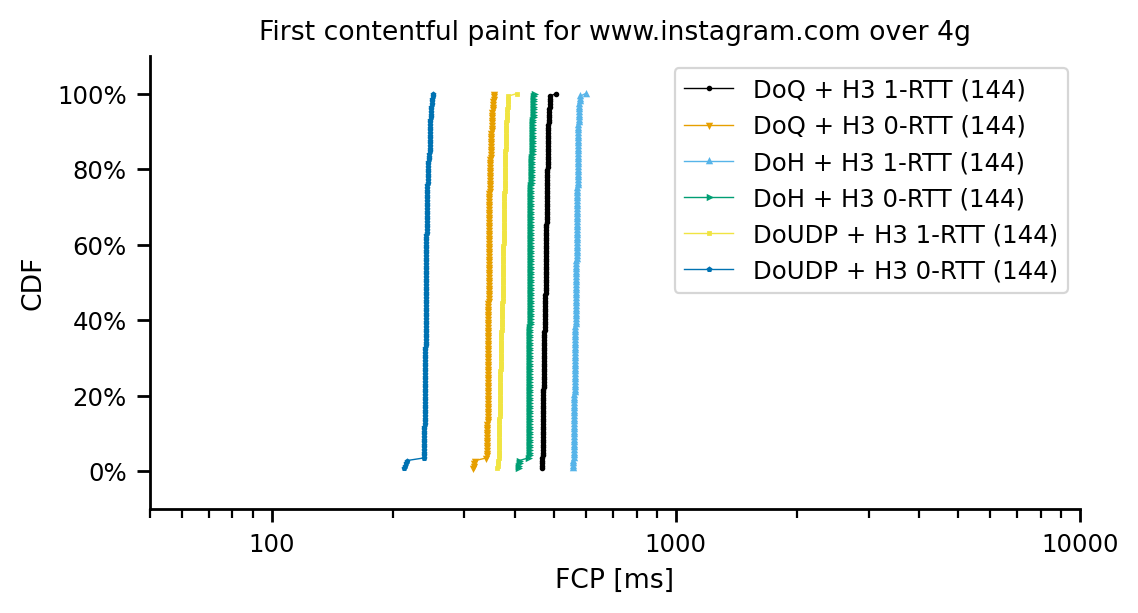

4g-medium
count     73.000000
mean     526.184652
std        3.386242
min      519.026150
10%      522.586892
20%      523.797740
25%      524.358341
30%      524.761109
40%      525.306752
50%      526.050205
60%      526.621833
70%      527.181404
75%      527.953987
80%      528.364189
90%      529.244015
100%     540.815537
max      540.815537
Name: full_fcp, dtype: float64
count     73.000000
mean     357.051776
std        3.469500
min      351.085029
10%      352.725444
20%      353.509662
25%      353.765117
30%      354.225123
40%      355.287842
50%      357.475479
60%      358.523212
70%      359.151440
75%      359.672185
80%      360.058805
90%      361.943271
100%     364.150818
max      364.150818
Name: full_fcp, dtype: float64
count     73.000000
mean     627.033683
std        3.372204
min      619.361461
10%      623.006829
20%      624.876942
25%      625.221624
30%      625.594222
40%      626.040620
50%      626.642967
60%      627.579948
70%      628.547784
75%     

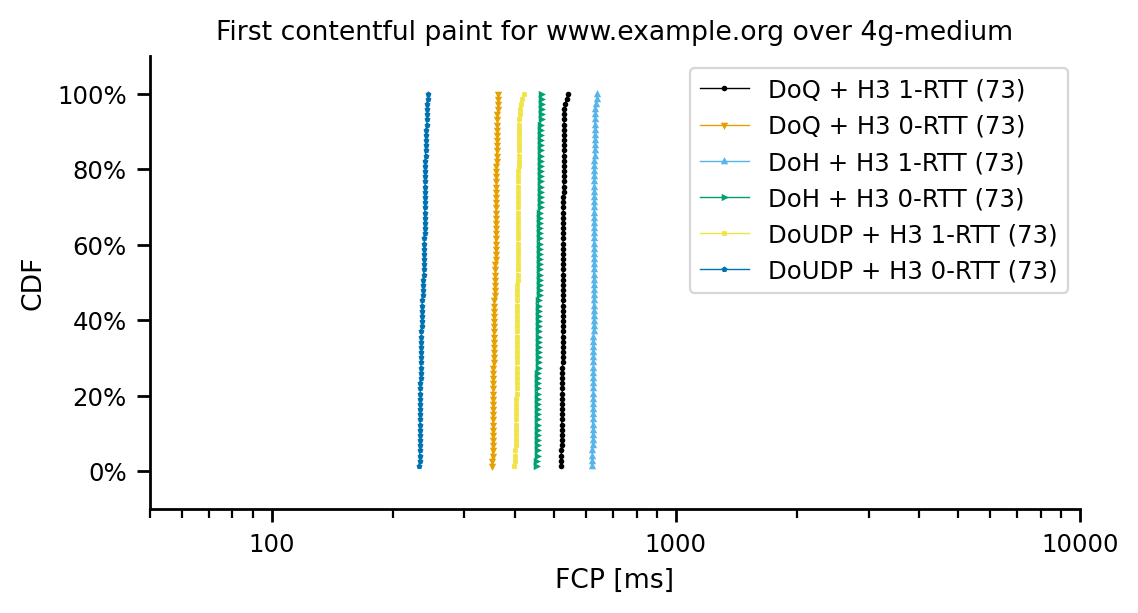

count     73.000000
mean     704.452274
std       36.450265
min      618.799493
10%      637.706273
20%      672.936808
25%      691.806244
30%      702.067998
40%      708.452093
50%      712.361036
60%      719.514116
70%      725.561014
75%      727.226274
80%      729.521458
90%      739.645914
100%     768.258305
max      768.258305
Name: full_fcp, dtype: float64
count     73.000000
mean     369.222137
std       19.398075
min      357.187961
10%      360.255719
20%      361.158262
25%      361.427101
30%      361.737508
40%      362.394090
50%      362.749006
60%      363.287256
70%      363.564875
75%      364.001533
80%      364.709769
90%      406.022520
100%     435.670261
max      435.670261
Name: full_fcp, dtype: float64
count     73.000000
mean     805.686795
std       36.464177
min      722.440290
10%      739.884837
20%      774.364603
25%      792.928182
30%      802.117897
40%      810.108653
50%      814.048872
60%      819.093880
70%      826.425798
75%      829.74430

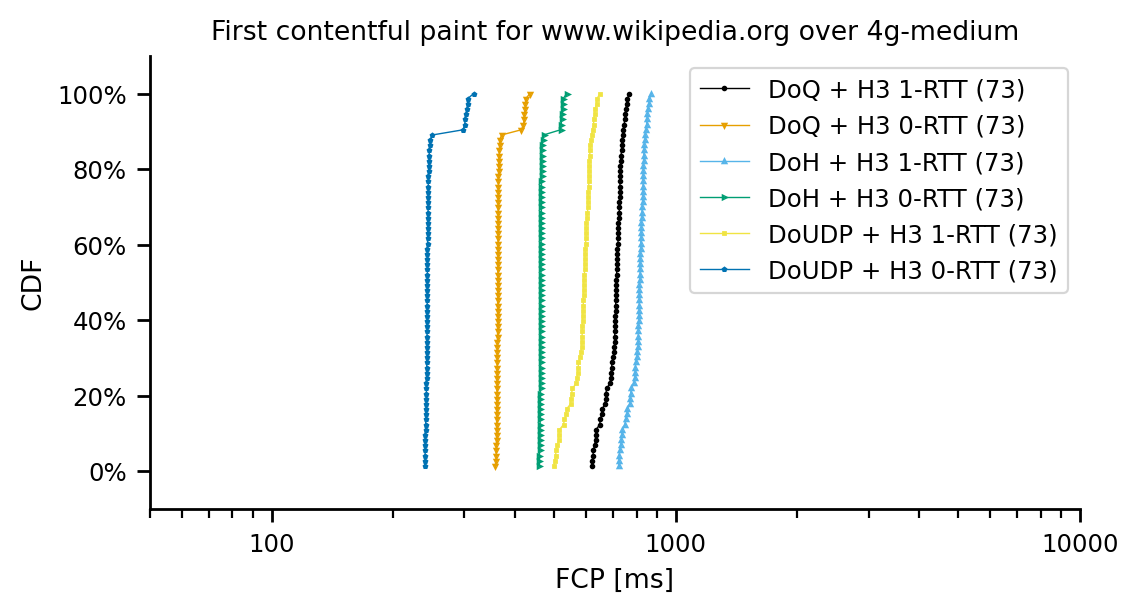

count    144.000000
mean     535.648150
std        4.670544
min      523.332415
10%      529.804161
20%      531.605026
25%      532.348465
30%      532.802207
40%      534.080106
50%      536.047708
60%      536.911626
70%      538.037289
75%      538.729384
80%      539.720863
90%      541.677955
100%     549.457122
max      549.457122
Name: full_fcp, dtype: float64
count    144.000000
mean     387.204400
std        6.872041
min      358.851986
10%      384.162400
20%      385.679790
25%      386.021451
30%      386.127543
40%      386.626625
50%      387.107495
60%      387.561203
70%      388.361563
75%      389.412849
80%      391.287576
90%      394.315094
100%     400.883099
max      400.883099
Name: full_fcp, dtype: float64
count    144.000000
mean     636.709799
std        4.752510
min      624.652194
10%      630.731271
20%      632.313047
25%      633.263482
30%      633.640761
40%      635.384945
50%      637.072331
60%      638.317796
70%      639.356607
75%      639.90339

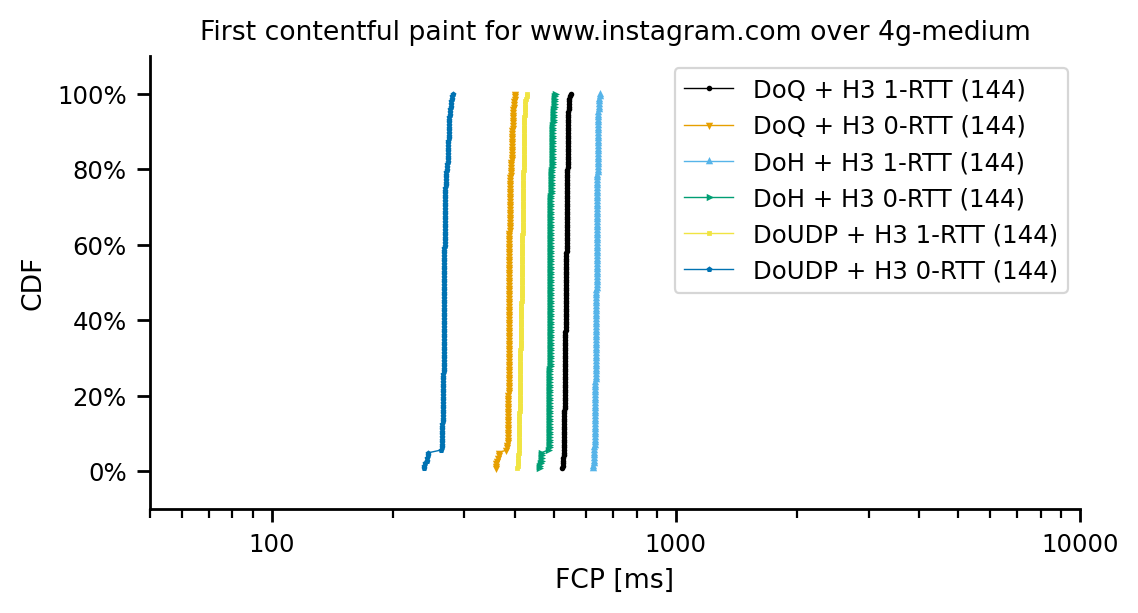

In [21]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_fcp', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_fcp']) == 0:
                    continue
                print(df_tmp['full_fcp'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_fcp'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('First contentful paint for '+website+' over '+access_technology)

        ax.set_xlabel('FCP [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [22]:
df_dns_and_h3.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoUDP + H3 1-RTT',
       'DoQ + H3 0-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'],
      dtype=object)

In [23]:
df_diff_plt_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_plt'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_udp.columns)
            df_diff_plt_udp = df_diff_plt_udp.append(next_df_series, ignore_index=True)
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.681775       34.771236       45.189176             dsl   
1       -52.180637       17.066800       22.075338             dsl   
2       -90.439870        1.733373        2.265696             dsl   
3       -35.073246       23.245702       38.027596           cable   
4       -64.861792        9.657014       15.717880           cable   
5       -67.272117        4.794898        7.834834           cable   
6       -41.452262       21.134958       32.705437           fiber   
7       -70.233396        7.500523       11.985672           fiber   
8       -75.242698        2.976729        4.582863           fiber   
9       -15.559771       28.818235       54.020565              4g   
10      -51.111643       15.338374       28.526864              4g   
11      -70.778749        5.756970       10.852114              4g   
12      -13.245347       29.913842       55.092608       4g-medium   
13      -48.991342       16.257142       29.827536       4g-medium   
14      -76.627179        4.770087        8.816642       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [24]:
df_diff_plt_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_plt'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_quic.columns)
            df_diff_plt_quic = df_diff_plt_quic.append(next_df_series, ignore_index=True)
df_diff_plt_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          17.208252       57.963009       70.173695             dsl   
1         109.120312      144.810457      155.284326             dsl   
2         946.010928      964.142198      969.710358             dsl   
3          54.019713       89.822677      112.589708           cable   
4         184.590495      212.073439      229.322087           cable   
5         205.549861      220.200663      229.489186           cable   
6          70.800791      106.899466      126.661937           fiber   
7         235.946955      261.144733      276.212455           fiber   
8         303.921240      315.944881      322.432398           fiber   
9          18.426965       52.555525       82.401880              4g   
10        104.547680      135.921967      162.898719              4g   
11        242.216700      261.918012      279.354447              4g   
12         15.267592       49.748558       78.771515       4g-medium   
13         96.045151      127.916490      154.520589       4g-medium   
14        327.847377      348.256068      365.569150       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [25]:
df_diff_fcp_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_fcp'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_udp.columns)
            df_diff_fcp_udp = df_diff_fcp_udp.append(next_df_series, ignore_index=True)
df_diff_fcp_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -11.822881       33.888397       44.121046             dsl   
1       -37.895927       23.473723       30.638189             dsl   
2        -6.647506       32.714675       42.760743             dsl   
3       -30.479913       22.281964       36.781060           cable   
4       -67.509870       10.224285       16.568869           cable   
5       -17.275357       21.125980       34.886685           cable   
6       -38.830745       19.187855       29.657181           fiber   
7       -59.388888       11.763420       18.417532           fiber   
8       -17.155499       18.685045       29.373509           fiber   
9       -14.510131       28.306758       53.215410              4g   
10      -42.581454       18.575587       34.936783              4g   
11       -7.747349       27.676427       52.000467              4g   
12      -11.952466       29.568113       54.344483       4g-medium   
13      -38.731357       20.318438       37.493607       4g-medium   
14       -6.956300       28.842409       53.124307       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [26]:
df_diff_fcp_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_fcp'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_quic.columns)
            df_diff_fcp_quic = df_diff_fcp_quic.append(next_df_series, ignore_index=True)
df_diff_fcp_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          13.408106       51.840295       63.444948             dsl   
1          61.020034       98.817431      110.353656             dsl   
2           7.120866       42.165108       52.926544             dsl   
3          43.843319       75.894435       96.750416           cable   
4         207.785785      239.254680      258.782407           cable   
5          20.882963       46.420673       63.055022           cable   
6          63.480820       94.849283      111.964622           fiber   
7         146.238026      175.204040      191.588993           fiber   
8          20.708072       43.262429       56.164269           fiber   
9          16.972925       50.084168       79.220546              4g   
10         74.159758      106.510955      135.005575              4g   
11          8.397969       38.398654       64.765419              4g   
12         13.575015       47.157004       75.296770       4g-medium   
13         63.215628       96.378494      124.411055       4g-medium   
14          7.476379       38.475156       64.572461       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

DoQ + H3 0-RTT
count    15.000000
mean    -52.516788
std      24.398781
min     -90.439870
10%     -76.073387
20%     -71.671539
25%     -70.506073
30%     -69.641140
40%     -65.825922
50%     -52.180637
60%     -50.263523
70%     -42.960078
75%     -38.262754
80%     -31.170551
90%     -15.032973
100%    -13.245347
max     -13.245347
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     14.915725
std      10.741569
min       1.733373
10%       3.694072
20%       4.789935
25%       5.275934
30%       6.105680
40%       8.794418
50%      15.338374
60%      16.581005
70%      20.321326
75%      22.190330
80%      24.360209
90%      29.475599
100%     34.771236
max      34.771236
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     24.501388
std      17.669519
min       2.265696
10%       5.883652
20%       8.620281
25%       9.834378
30%      11.078826
40%      14.224997
50%      22.075338
60%      29.047133
70%      32.129857
75%    

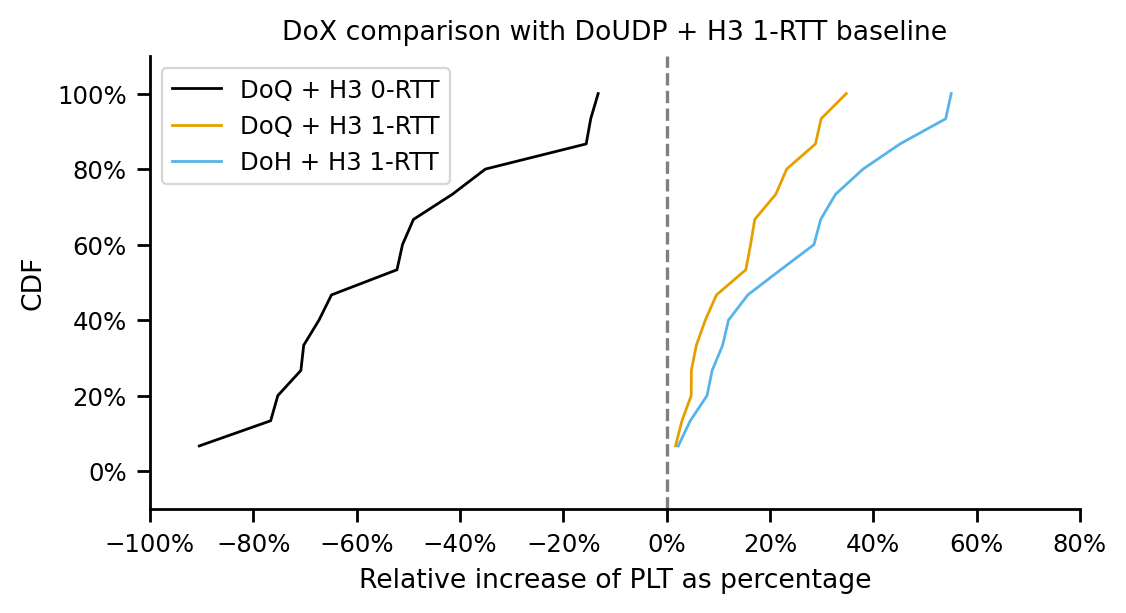

In [29]:
df_tmp = df_diff_plt_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean     195.434667
std      231.978161
min       15.267592
10%       17.695737
20%       46.901164
25%       62.410252
30%       75.849663
40%      101.146668
50%      109.120312
60%      192.974241
70%      229.867536
75%      239.081828
80%      254.557608
90%      318.276922
100%     946.010928
max      946.010928
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean     223.287876
std      226.301378
min       49.748558
10%       54.718519
20%       83.450744
25%       98.361072
30%      111.102871
40%      132.719776
50%      144.810457
60%      215.324329
70%      252.955919
75%      261.531373
80%      272.723386
90%      335.331593
100%     964.142198
max      964.142198
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     241.026163
std      221.567223
min       70.173695
10%       80.223661
20%      106.552142
25%      119.625822
30%      132.233667
40%      154.978831
50%      162.8987

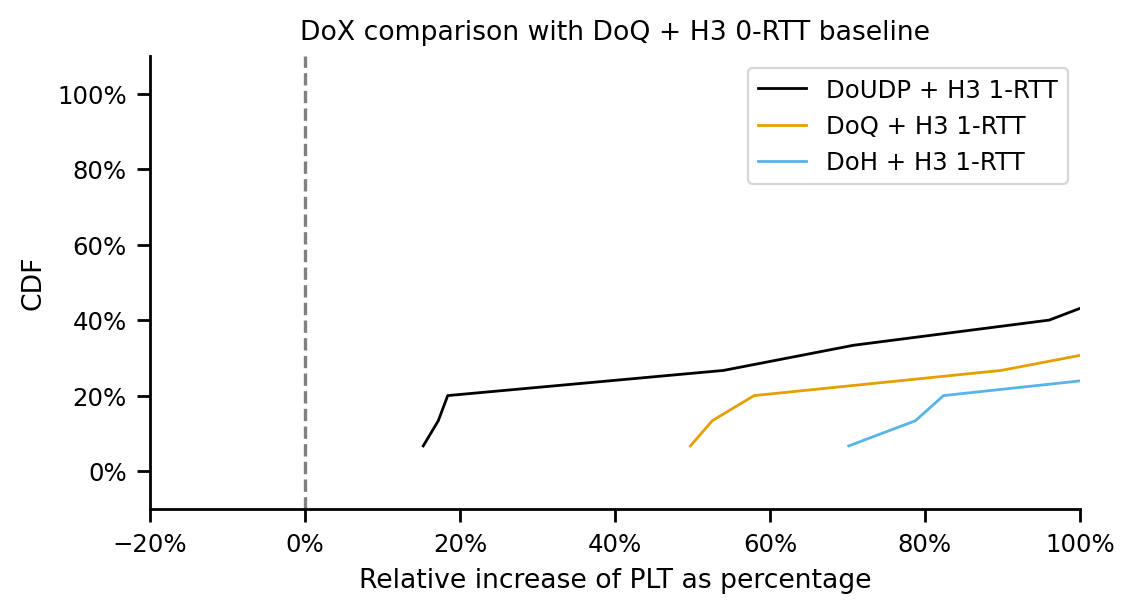

In [30]:
df_tmp = df_diff_plt_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-20, 100)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean      51.219044
std       57.367989
min        7.120866
10%        7.845015
20%       12.406078
25%       13.491561
30%       14.254597
40%       19.214013
50%       20.882963
60%       50.714005
70%       62.776509
75%       63.348224
80%       65.616608
90%      117.406719
100%     207.785785
max      207.785785
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean      82.980854
std       57.312047
min       38.398654
10%       39.951137
20%       43.042965
25%       44.841551
30%       46.567939
40%       48.913303
50%       51.840295
60%       83.476374
70%       96.072652
75%       97.597962
80%      100.356136
90%      147.726806
100%     239.254680
max      239.254680
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     103.220180
std       57.261530
min       52.926544
10%       58.920570
20%       63.366963
25%       64.008704
30%       64.611053
40%       71.084230
50%       79.2205

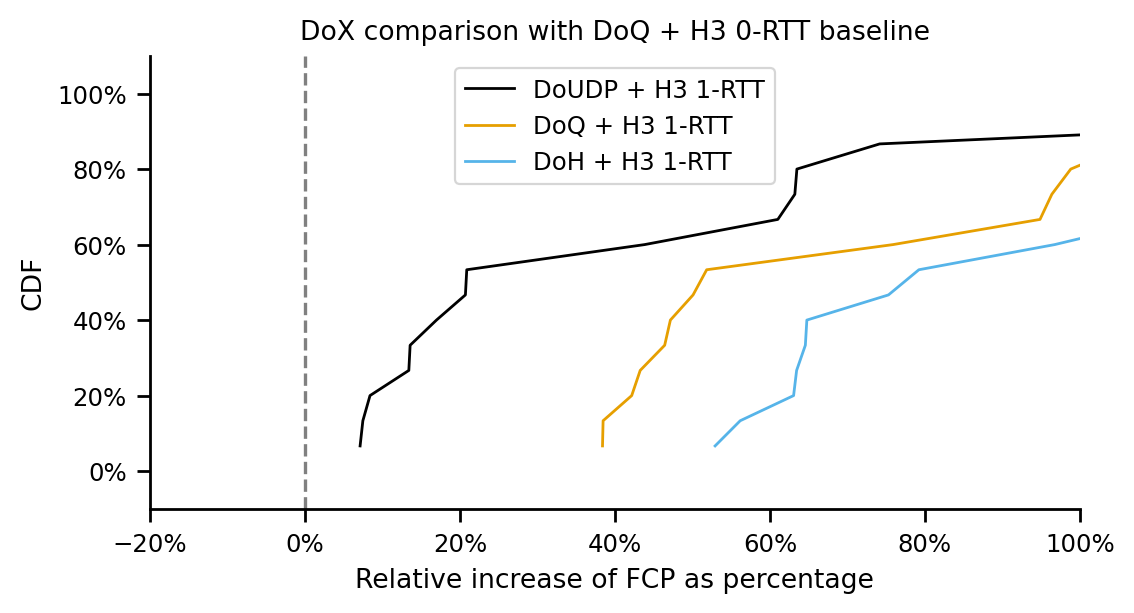

In [31]:
df_tmp = df_diff_fcp_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-20, 100)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ + H3 0-RTT
count    15.000000
mean    -27.299043
std      19.513445
min     -67.509870
10%     -52.665915
20%     -39.580887
25%     -38.781051
30%     -38.564271
40%     -33.446319
50%     -17.275357
60%     -16.097352
70%     -12.463999
75%     -11.887674
80%     -11.007775
90%      -7.272720
100%     -6.647506
max      -6.647506
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     23.108872
std       7.039216
min      10.224285
10%      14.488287
20%      18.663153
25%      18.936450
30%      19.413971
40%      20.802963
50%      22.281964
60%      25.154804
70%      28.180692
75%      28.574584
80%      28.987550
90%      31.456050
100%     33.888397
max      33.888397
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     37.887991
std      12.086451
min      16.568869
10%      22.799923
20%      29.600446
25%      30.147685
30%      31.487888
40%      34.916744
50%      36.781060
60%      39.600461
70%      43.848985
75%    

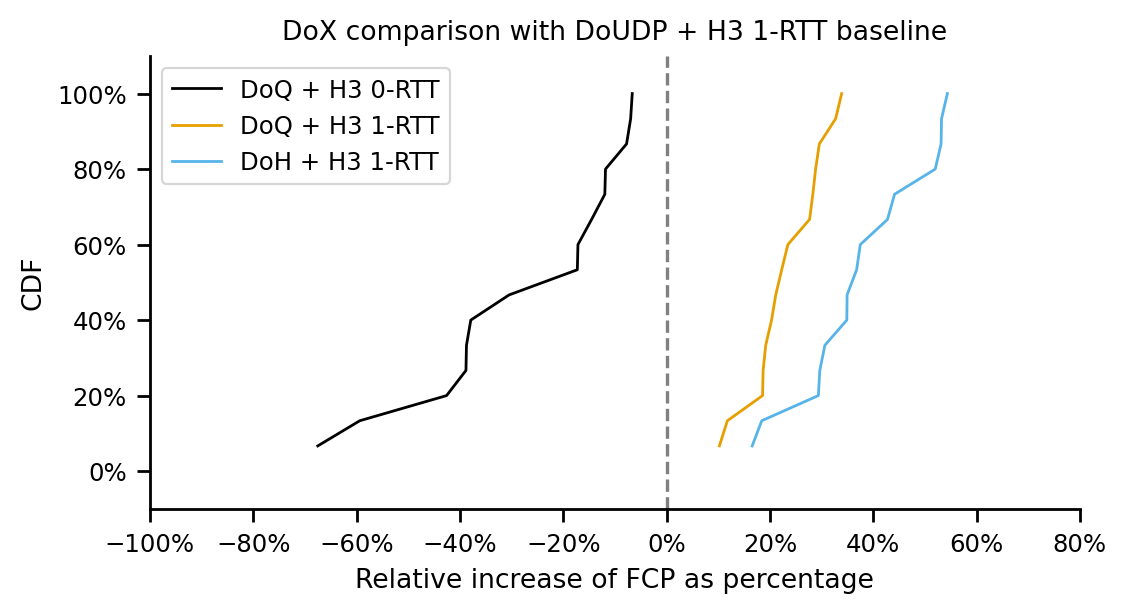

In [33]:
df_tmp = df_diff_fcp_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

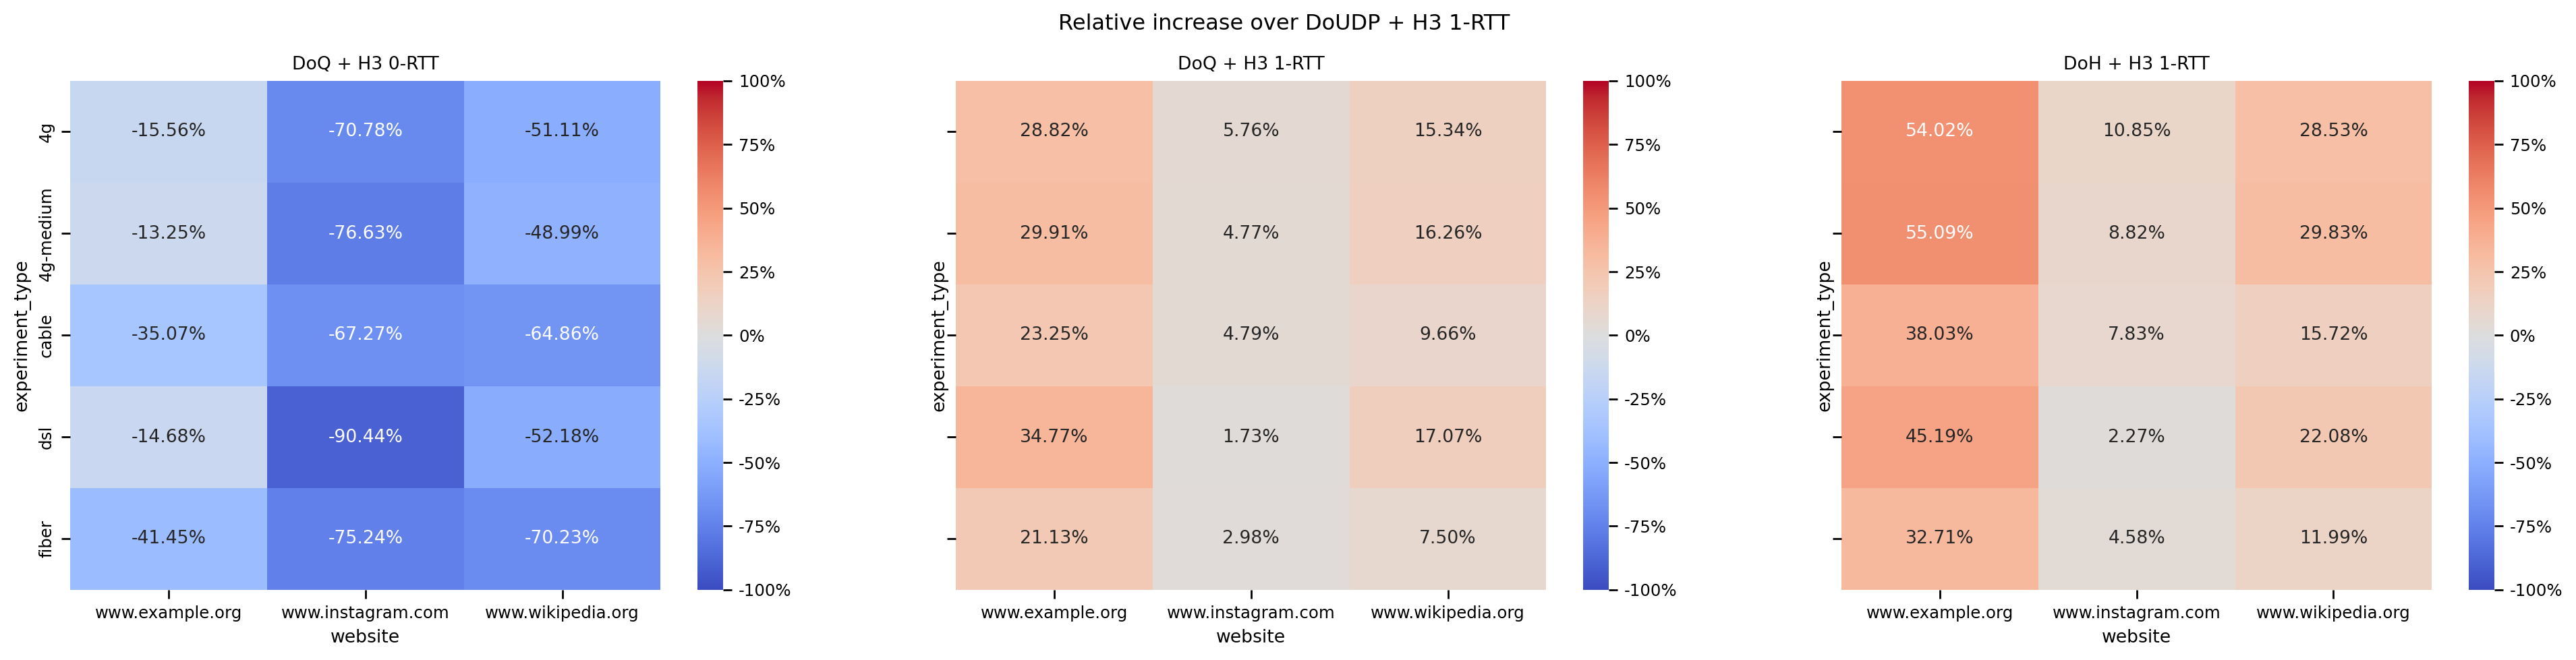

In [36]:
fig, axs = plt.subplots(1, 3, sharex='all', figsize=(24,5), sharey='all')
ax_hm1 =sns.heatmap(df_diff_plt_udp[['DoQ + H3 0-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 0-RTT'), ax=axs.flat[0], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm2 = sns.heatmap(df_diff_plt_udp[['DoQ + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 1-RTT'), ax=axs.flat[1], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm3 = sns.heatmap(df_diff_plt_udp[['DoH + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoH + H3 1-RTT'), ax=axs.flat[2], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
axs.flat[0].set_title('DoQ + H3 0-RTT')
axs.flat[1].set_title('DoQ + H3 1-RTT')
axs.flat[2].set_title('DoH + H3 1-RTT')
fig.suptitle('Relative increase over DoUDP + H3 1-RTT')
ax_hm1.set_yticklabels(labels=ax_hm1.get_yticklabels(), va='center')
for t in ax_hm1.texts: t.set_text(t.get_text() + "%")
for t in ax_hm2.texts: t.set_text(t.get_text() + "%")
for t in ax_hm3.texts: t.set_text(t.get_text() + "%")
plt.show()

In [58]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0        -5.577785       46.848162       60.961489             dsl   
1       -56.875382       15.375555       23.945399             dsl   
2       -90.912642        1.724921        2.712072             dsl   
3       -17.483730       29.492704       44.758706           cable   
4       -63.023984       12.724001       19.163045           cable   
5       -91.162323        0.892064        1.455856           cable   
6       -25.054262       25.299456       37.985679           fiber   
7       -72.617409        6.570387       10.018324           fiber   
8       -85.961076        1.161763        2.408112           fiber   
9        -5.403193       33.861957       59.217642              4g   
10      -53.026773       14.436486       27.692643              4g   
11      -92.042131        1.744988        2.745557              4g   
12       -4.509613       36.142153       61.626684       4g-medium   
13      -49.937648       16.241354       28.528972       4g-medium   
14      -92.222960        1.925621        3.204314       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [82]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0        -5.577785       46.848162       60.961489             dsl   
1       -56.875382       15.375555       23.945399             dsl   
2       -90.912642        1.724921        2.712072             dsl   
3       -17.483730       29.492704       44.758706           cable   
4       -63.023984       12.724001       19.163045           cable   
5       -91.162323        0.892064        1.455856           cable   
6       -25.054262       25.299456       37.985679           fiber   
7       -72.617409        6.570387       10.018324           fiber   
8       -85.961076        1.161763        2.408112           fiber   
9        -5.403193       33.861957       59.217642              4g   
10      -53.026773       14.436486       27.692643              4g   
11      -92.042131        1.744988        2.745557              4g   
12       -4.509613       36.142153       61.626684       4g-medium   
13      -49.937648       16.241354       28.528972       4g-medium   
14      -92.222960        1.925621        3.204314       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [37]:
df_udp_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [38]:
df_diff_all_data_udp_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoUDP + H3 1-RTT'], df_udp_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_udp_baseline_medians['relative_increase_plt'] = (df_diff_all_data_udp_baseline_medians['full_plt']/(df_diff_all_data_udp_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_udp_baseline_medians['full_fcp']/(df_diff_all_data_udp_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians

msm_id  connectEnd  connectStart  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
3     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                    ...         ...           ...   
7260  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7261  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7262  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7263  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7264  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   

      domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0           184.3                     184.3                       184.3   
1           184.3                     184.3                       184.3   
2            72.9                      72.2                        72.2   
3            72.9                      72.2                        72.2   
4            72.9                      72.2                        72.2   
...           ...                       ...                         ...   
7260       2398.2                    2033.9                      2033.9   
7261       2398.2                    2033.9                      2033.9   
7262        367.0                     161.8                       161.8   
7263        367.0                     161.8                       161.8   
7264        367.0                     161.8                       161.8   

      domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0              184.3             45.9               45.9     184.3  ...   
1              184.3             45.9               45.9     184.3  ...   
2               72.2              2.0                2.0      72.9  ...   
3               72.2              2.0                2.0      72.9  ...   
4               72.2              2.0                2.0      72.9  ...   
...              ...              ...                ...       ...  ...   
7260          2033.9             46.0               46.0    2398.7  ...   
7261          2033.9             46.0               46.0    2398.7  ...   
7262           161.8              0.4                0.4     367.3  ...   
7263           161.8              0.4                0.4     367.3  ...   
7264           161.8              0.4                0.4     367.3  ...   

      transport_protocol     full_plt     full_fp    full_fcp  h3_description  \
0                    DoQ   308.508530  313.208530  313.208530        H3 1-RTT   
1                    DoH   333.114524  337.814524  337.814524        H3 1-RTT   
2                    DoQ   197.108530  204.808530  204.808530        H3 0-RTT   
3                    DoH   221.714524  229.414524  229.414524        H3 0-RTT   
4                  DoUDP   117.393365  125.093365  125.093365        H3 0-RTT   
...                  ...          ...         ...         ...             ...   
7260                 DoQ  2624.032480  536.232480  536.232480        H3 1-RTT   
7261                 DoH  2725.821254  638.021254  638.021254        H3 1-RTT   
7262                 DoQ   592.632480  393.332480  393.332480        H3 0-RTT   
7263                 DoH   694.421254  495.121254  495.121254        H3 0-RTT   
7264               DoUDP   473.070021  273.770021  273.770021        H3 0-RTT   

      experiment_description  full_plt_udp_med  full_fcp_udp_med  \
0             DoQ + H3 1-RTT        230.750471        236.745132   
1             DoH + H3 1-RTT        230.750471        236.745132   
2             DoQ + H3 0-RTT        230.750471        236.745132   
3             DoH + H3 0-RTT        230.750471        236.745132   
4           DoUDP + H3 0-RTT        230.750471        23

In [39]:
df_diff_all_data_udp_baseline_medians.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [40]:
df_diff_all_data_udp_baseline_medians.website.unique()

array(['www.example.org', 'www.wikipedia.org', 'www.instagram.com'],
      dtype=object)

In [41]:
df_diff_all_data_udp_baseline_medians.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoQ + H3 0-RTT',
       'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'], dtype=object)

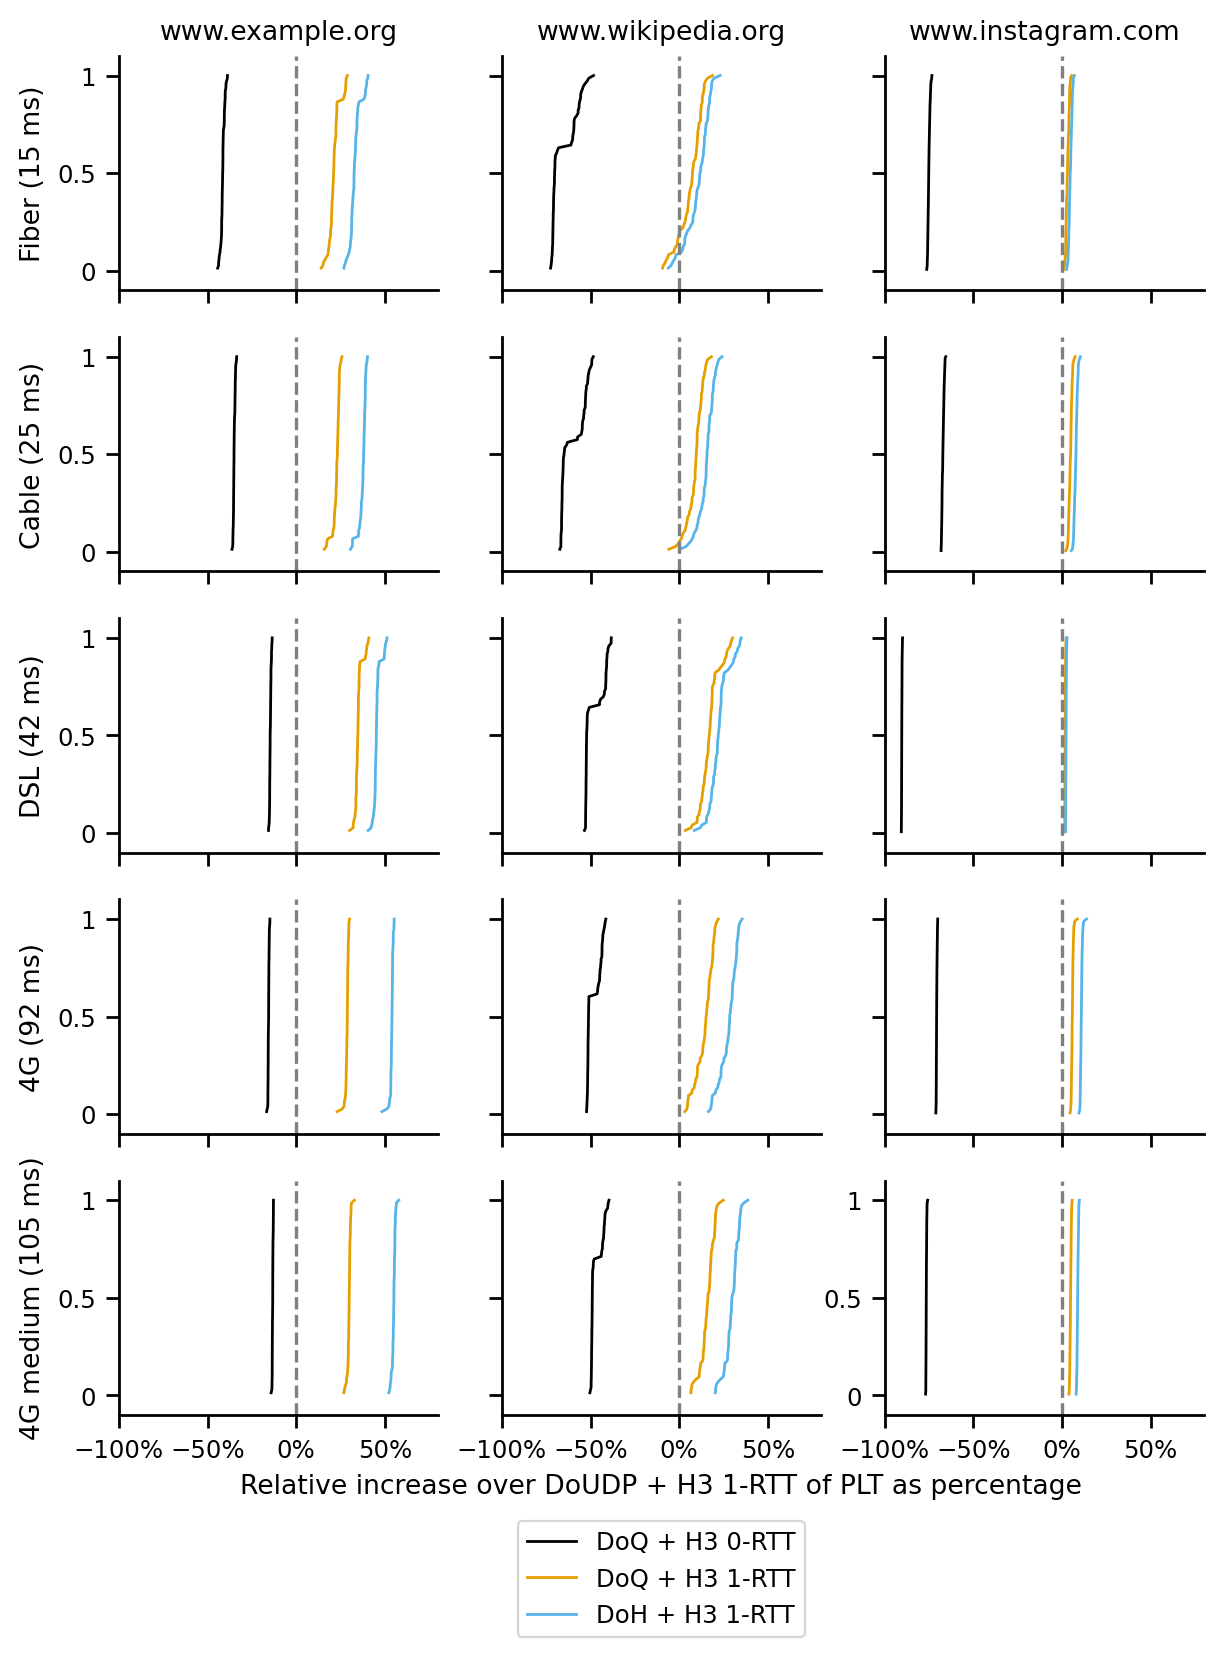

<Figure size 1200x800 with 0 Axes>

In [44]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/plt-doudp-baseline-grid.pdf", bbox_inches='tight')

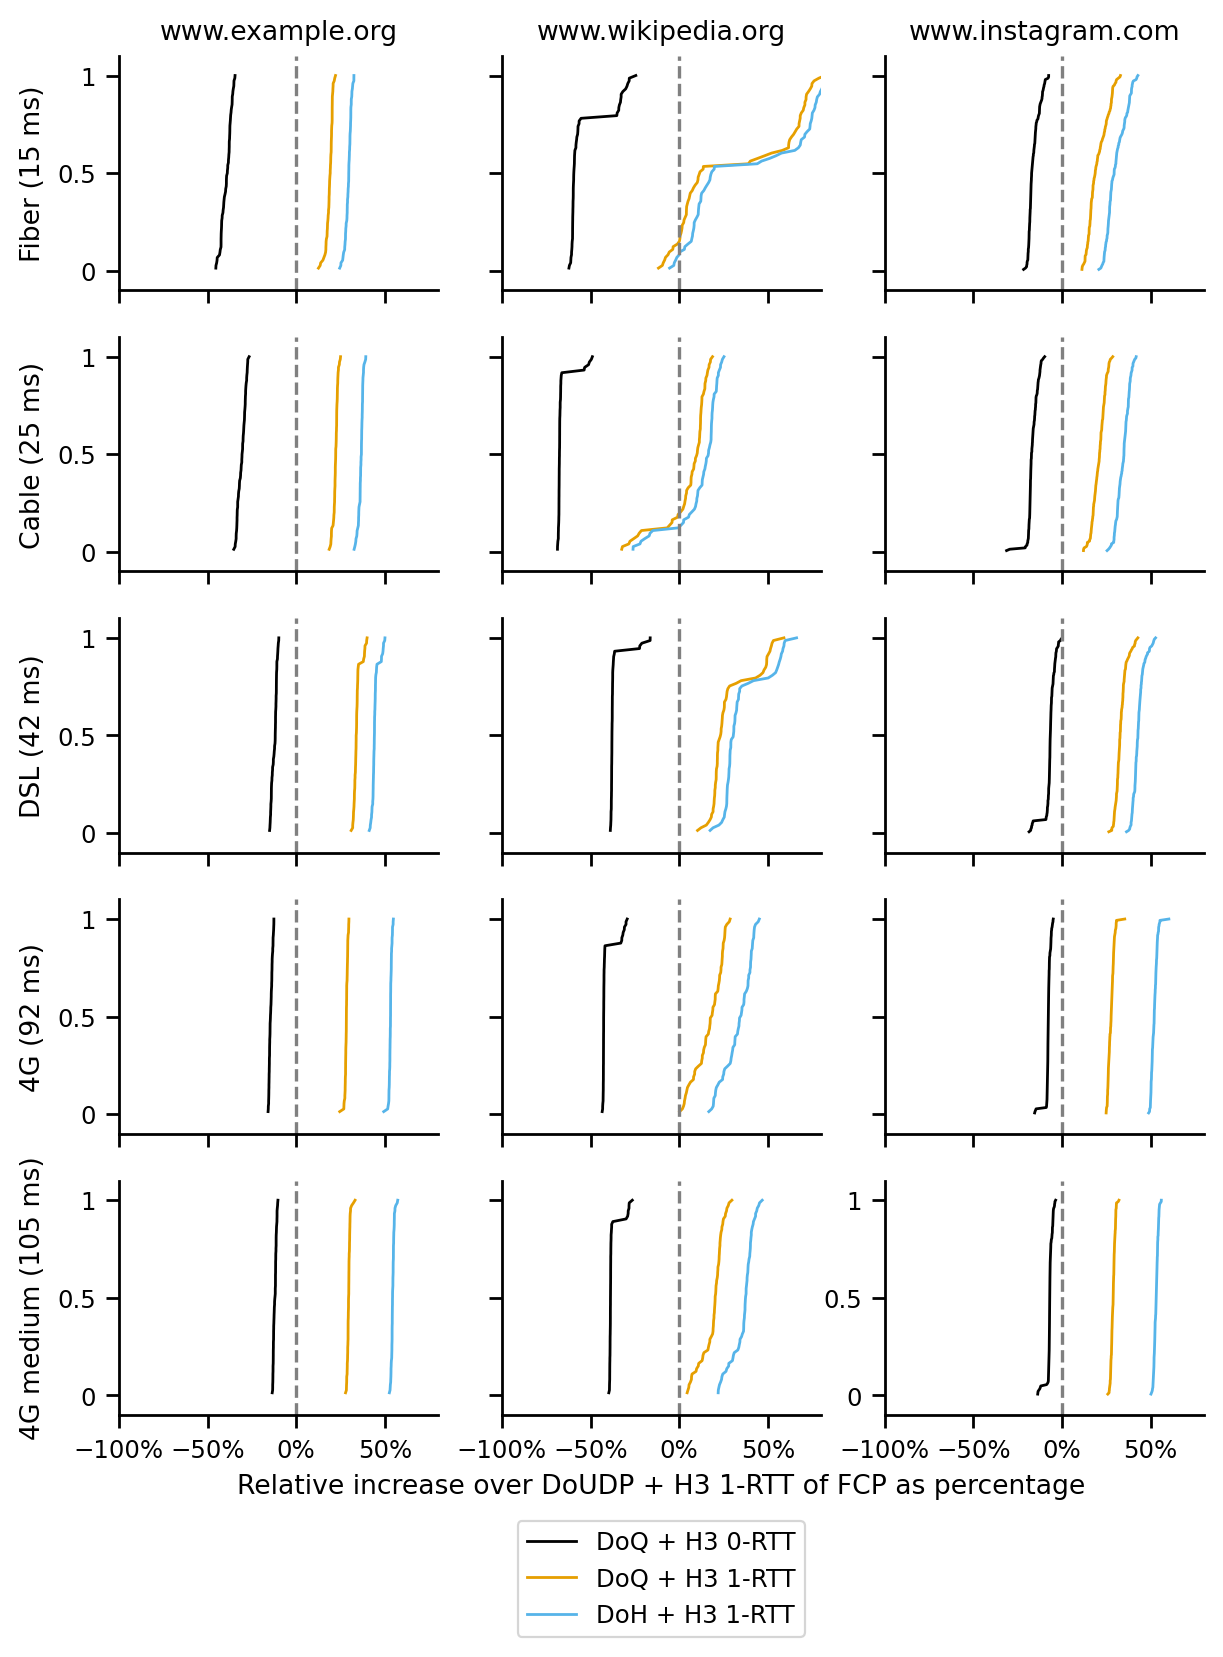

<Figure size 1200x800 with 0 Axes>

In [45]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_fcp'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of FCP as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/fcp-doudp-baseline-grid.pdf", bbox_inches='tight')

In [46]:
df_quic_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [47]:
df_diff_all_data_quic_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoQ + H3 0-RTT'], df_quic_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_quic_baseline_medians['relative_increase_plt'] = (df_diff_all_data_quic_baseline_medians['full_plt']/(df_diff_all_data_quic_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_quic_baseline_medians['full_fcp']/(df_diff_all_data_quic_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians

msm_id  connectEnd  connectStart  \
0     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2     d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
3     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4     d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                    ...         ...           ...   
7260  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7261  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7262  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b       163.5          46.0   
7263  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   
7264  ed6ddf5f-6e71-49c0-9d0f-27a56947c76b         0.4           0.4   

      domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0           184.3                     184.3                       184.3   
1           184.3                     184.3                       184.3   
2           184.3                     184.3                       184.3   
3            72.9                      72.2                        72.2   
4            72.9                      72.2                        72.2   
...           ...                       ...                         ...   
7260       2398.2                    2033.9                      2033.9   
7261       2398.2                    2033.9                      2033.9   
7262       2398.2                    2033.9                      2033.9   
7263        367.0                     161.8                       161.8   
7264        367.0                     161.8                       161.8   

      domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0              184.3             45.9               45.9     184.3  ...   
1              184.3             45.9               45.9     184.3  ...   
2              184.3             45.9               45.9     184.3  ...   
3               72.2              2.0                2.0      72.9  ...   
4               72.2              2.0                2.0      72.9  ...   
...              ...              ...                ...       ...  ...   
7260          2033.9             46.0               46.0    2398.7  ...   
7261          2033.9             46.0               46.0    2398.7  ...   
7262          2033.9             46.0               46.0    2398.7  ...   
7263           161.8              0.4                0.4     367.3  ...   
7264           161.8              0.4                0.4     367.3  ...   

      transport_protocol     full_plt     full_fp    full_fcp  h3_description  \
0                    DoQ   308.508530  313.208530  313.208530        H3 1-RTT   
1                    DoH   333.114524  337.814524  337.814524        H3 1-RTT   
2                  DoUDP   228.793365  233.493365  233.493365        H3 1-RTT   
3                    DoH   221.714524  229.414524  229.414524        H3 0-RTT   
4                  DoUDP   117.393365  125.093365  125.093365        H3 0-RTT   
...                  ...          ...         ...         ...             ...   
7260                 DoQ  2624.032480  536.232480  536.232480        H3 1-RTT   
7261                 DoH  2725.821254  638.021254  638.021254        H3 1-RTT   
7262               DoUDP  2504.470021  416.670021  416.670021        H3 1-RTT   
7263                 DoH   694.421254  495.121254  495.121254        H3 0-RTT   
7264               DoUDP   473.070021  273.770021  273.770021        H3 0-RTT   

      experiment_description  full_plt_udp_med  full_fcp_udp_med  \
0             DoQ + H3 1-RTT        196.872206        208.755036   
1             DoH + H3 1-RTT        196.872206        208.755036   
2           DoUDP + H3 1-RTT        196.872206        208.755036   
3             DoH + H3 0-RTT        196.872206        208.755036   
4           DoUDP + H3 0-RTT        196.872206        20

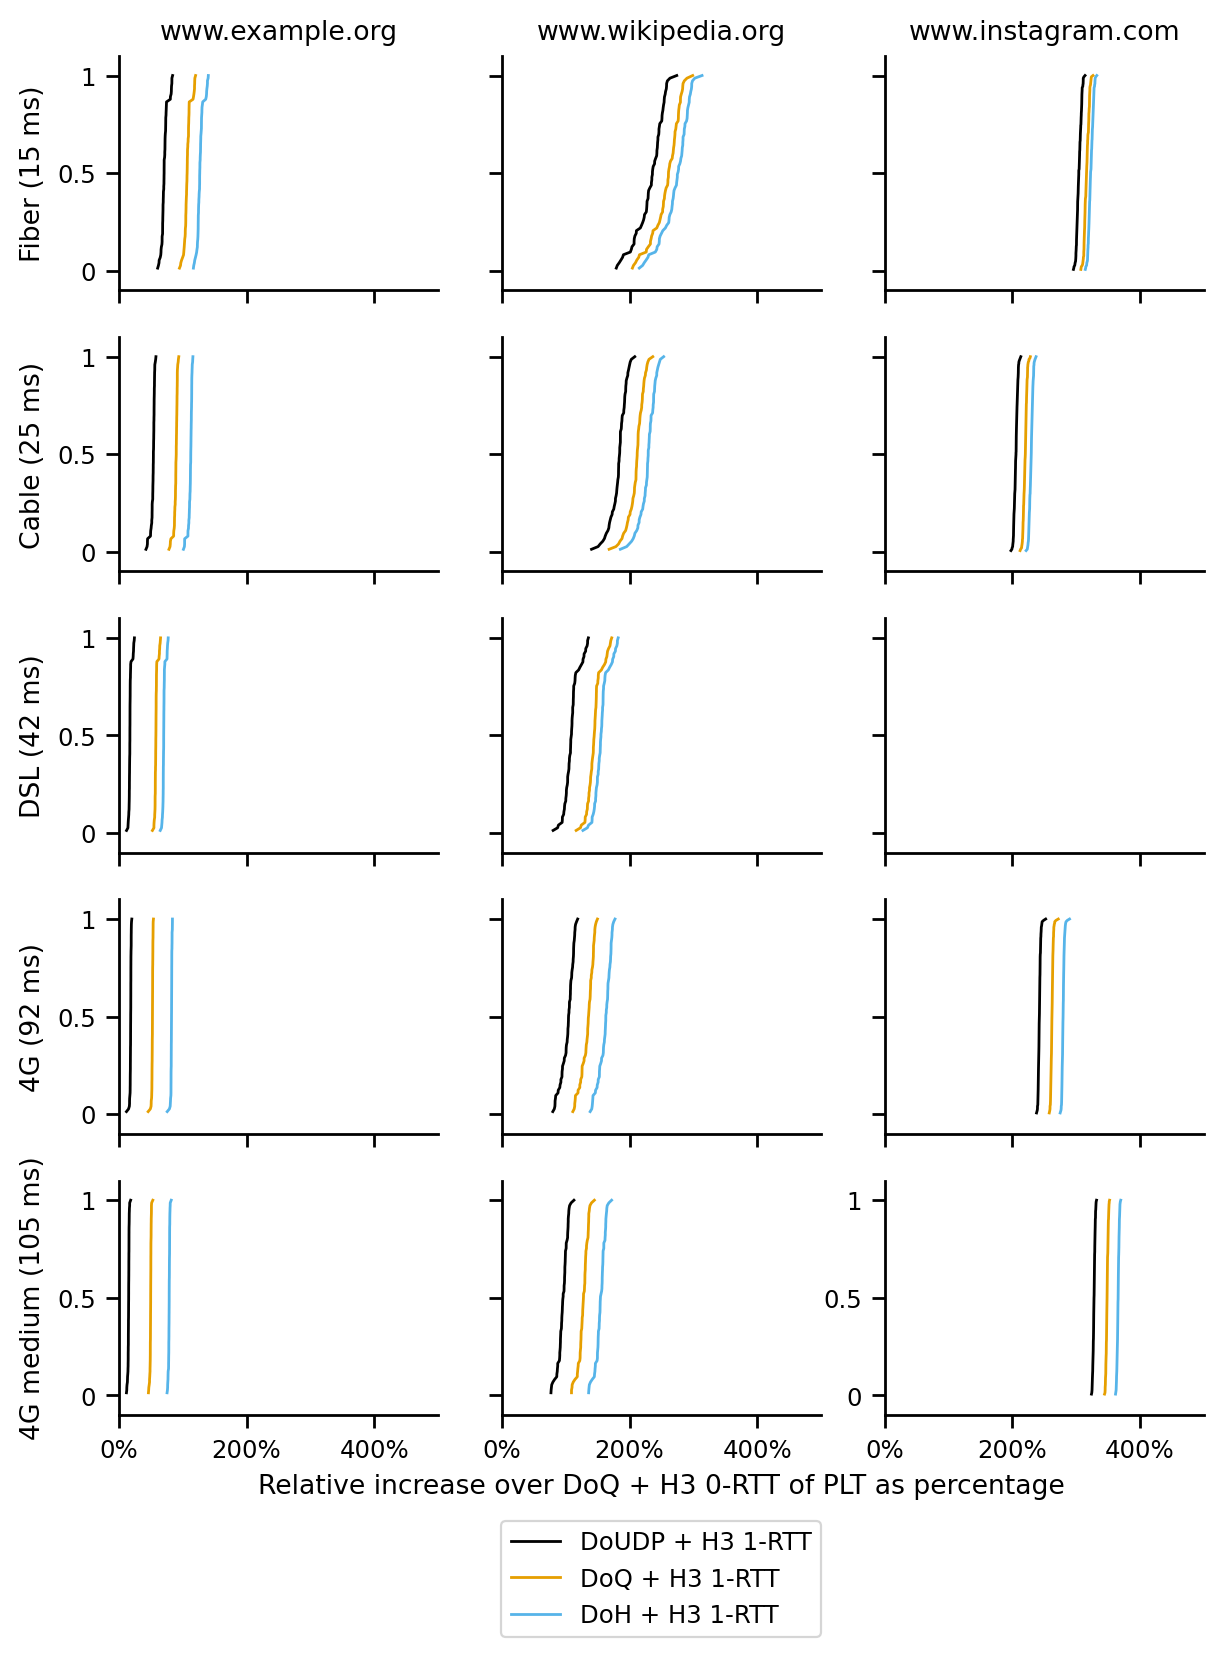

<Figure size 1200x800 with 0 Axes>

In [50]:
metrics_for_single_cdf = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_quic_baseline_medians[(df_diff_all_data_quic_baseline_medians['website'] == website) & (df_diff_all_data_quic_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_quic_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        #ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoQ + H3 0-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(0, 500)

plt.show()
plt.savefig("figures/plt-doq-baseline-grid.pdf", bbox_inches='tight')

DoQ+0rtt -> 1-rtt handshake
DoUDP+1-rtt -> 1-rtt handshake
-> compare their relative increase in PLT from 4g to 4g medium for www.example.org (inflight should always be below BDP)

In [55]:
df_exchange_durations = df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'exchange'].copy()
df_exchange_durations = pd.merge(df_exchange_durations, measurements, on='msm_id')

In [57]:
df_exchange_durations.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [58]:
df_exchange_durations['rtt'] = 0
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'dsl', 42.35979, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'cable', 25.17665, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'fiber', 14.767147, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g', 91.85231065904635, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g-medium', 104.5041425140391, df_exchange_durations['rtt'])

In [62]:
df_exchange_durations['duration_in_rtt'] = df_exchange_durations['duration'] / df_exchange_durations['rtt']

In [74]:
df_exchange_durations['handshake_round_trips'] = 0
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoQ', 1, df_exchange_durations['handshake_round_trips'])
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoH', 2, df_exchange_durations['handshake_round_trips'])

In [76]:
df_exchange_durations['theoretical_handshake_duration'] = df_exchange_durations['handshake_round_trips'] * df_exchange_durations['rtt']

In [78]:
df_exchange_durations['theoretical_exchange_without_handshake'] = df_exchange_durations['duration'] - df_exchange_durations['theoretical_handshake_duration']

In [80]:
df_exchange_durations['theoretical_query_in_rtt'] = df_exchange_durations['theoretical_exchange_without_handshake'] / df_exchange_durations['rtt']

In [88]:
df_exchange_durations['theoretical_processing_delay'] = df_exchange_durations['theoretical_exchange_without_handshake'] - df_exchange_durations['rtt']

In [65]:
df_exchange_durations.transport_protocol.unique()

array(['DoQ', 'DoH', 'DoUDP'], dtype=object)

DoQ
count    1453.000000
mean        2.500816
std         0.322787
min         2.108462
10%         2.132539
20%         2.149440
25%         2.154638
30%         2.156122
40%         2.374287
50%         2.496276
60%         2.560865
70%         2.774205
75%         2.804207
80%         2.889985
90%         2.934575
100%        2.980782
max         2.980782
Name: duration_in_rtt, dtype: float64
DoH
count    1453.000000
mean        3.381177
std         0.229283
min         3.071857
10%         3.122571
20%         3.124274
25%         3.125205
30%         3.126396
40%         3.372264
50%         3.433358
60%         3.483071
70%         3.507613
75%         3.510349
80%         3.549232
90%         3.713069
100%        3.845313
max         3.845313
Name: duration_in_rtt, dtype: float64
DoUDP
count    1453.000000
mean        1.027741
std         0.016692
min         1.006121
10%         1.008299
20%         1.008729
25%         1.008936
30%         1.009131
40%         1.019227
50%    

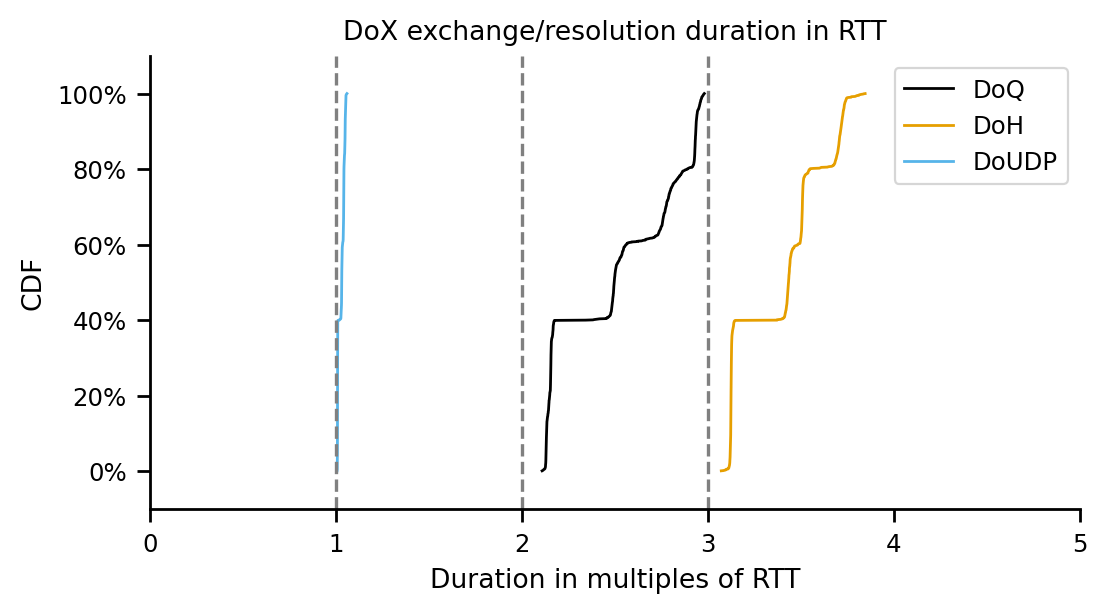

In [69]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX exchange/resolution duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/exchange-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/exchange-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean       2.770794
std        0.064324
min        2.455970
10%        2.712811
20%        2.744484
25%        2.752771
30%        2.756189
40%        2.763427
50%        2.773671
60%        2.785317
70%        2.796154
75%        2.803621
80%        2.812285
90%        2.846062
100%       2.895871
max        2.895871
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.712724
std        0.037200
min        3.481318
10%        3.684291
20%        3.695711
25%        3.699780
30%        3.702958
40%        3.707168
50%        3.713071
60%        3.718701
70%        3.724386
75%        3.727007
80%        3.731308
90%        3.739709
100%       3.845313
max        3.845313
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.048746
std        0.003955
min        1.027996
10%        1.043732
20%        1.046789
25%        1.047693
30%        1.047991
40%        1.048978
50%        1.049356
60%        1.049937
70%       

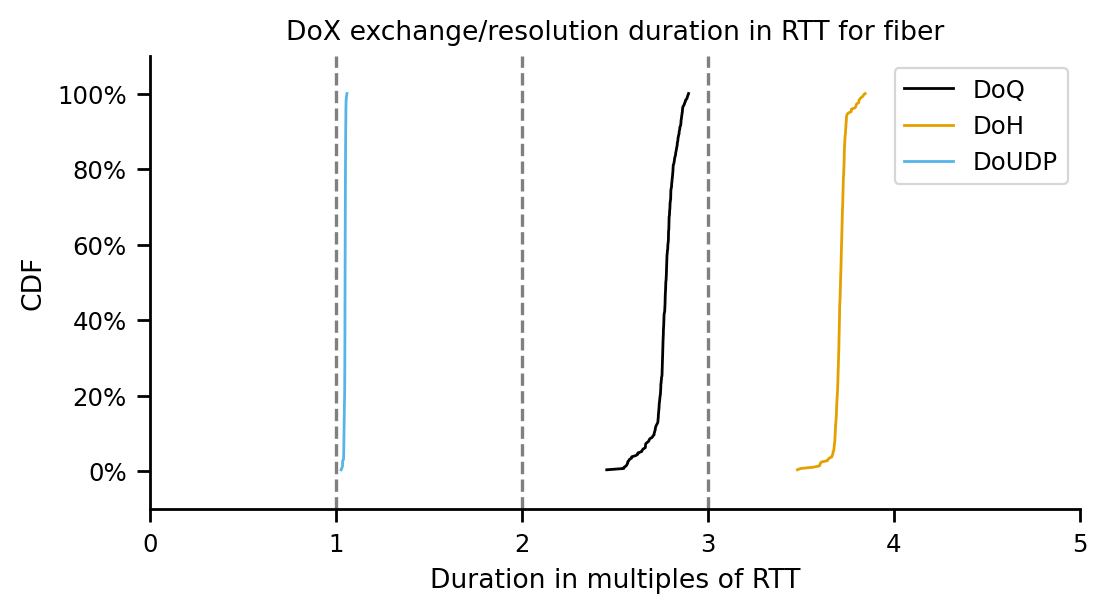

DoQ
count    291.000000
mean       2.500800
std        0.028215
min        2.341952
10%        2.478674
20%        2.484802
25%        2.487507
30%        2.489209
40%        2.493290
50%        2.496276
60%        2.500173
70%        2.506476
75%        2.513279
80%        2.524320
90%        2.539850
100%       2.565114
max        2.565114
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.434003
std        0.017666
min        3.371917
10%        3.417081
20%        3.423538
25%        3.425482
30%        3.426714
40%        3.429928
50%        3.433344
60%        3.435859
70%        3.438961
75%        3.441095
80%        3.442214
90%        3.449766
100%       3.521321
max        3.521321
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.030933
std        0.002318
min        1.018202
10%        1.027932
20%        1.029930
25%        1.030239
30%        1.030436
40%        1.030908
50%        1.031234
60%        1.031521
70%       

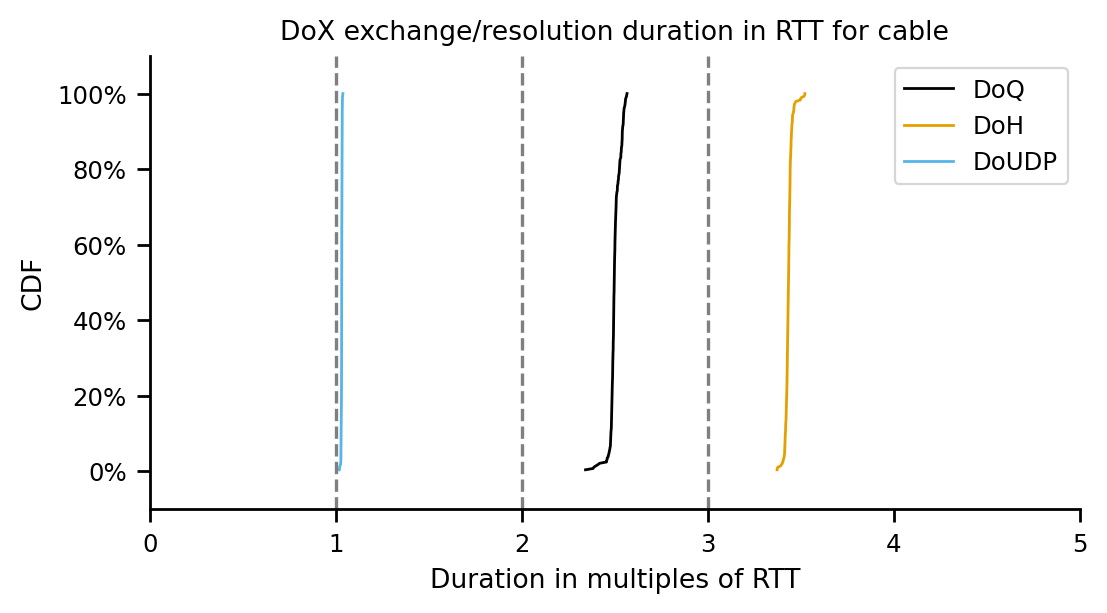

DoQ
count    291.000000
mean       2.937621
std        0.017097
min        2.828531
10%        2.925936
20%        2.929178
25%        2.929913
30%        2.930884
40%        2.932674
50%        2.934585
60%        2.936323
70%        2.940278
75%        2.943016
80%        2.950122
90%        2.960874
100%       2.980782
max        2.980782
Name: duration_in_rtt, dtype: float64
DoH
count    291.000000
mean       3.508632
std        0.012262
min        3.434134
10%        3.499782
20%        3.503453
25%        3.504373
30%        3.505136
40%        3.506349
50%        3.507587
60%        3.508412
70%        3.509586
75%        3.510286
80%        3.511572
90%        3.519233
100%       3.549738
max        3.549738
Name: duration_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.041549
std        0.001395
min        1.034310
10%        1.039726
20%        1.040574
25%        1.040947
30%        1.041157
40%        1.041499
50%        1.041696
60%        1.041898
70%       

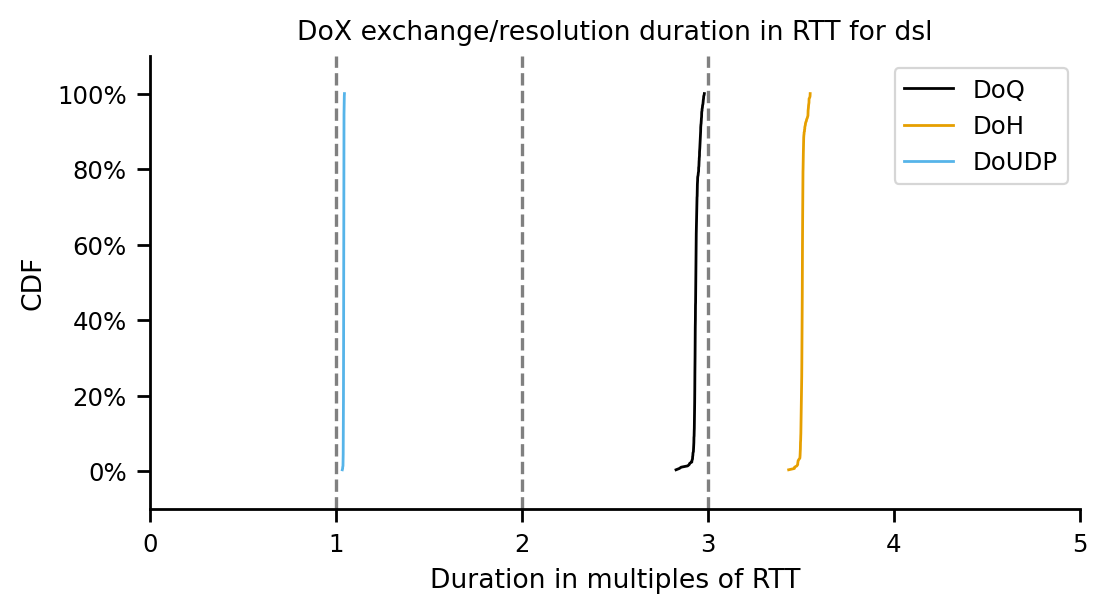

DoQ
count    290.000000
mean       2.134913
std        0.007458
min        2.108462
10%        2.128188
20%        2.129316
25%        2.129802
30%        2.130339
40%        2.131474
50%        2.132774
60%        2.134009
70%        2.138037
75%        2.141305
80%        2.143225
90%        2.145665
100%       2.151543
max        2.151543
Name: duration_in_rtt, dtype: float64
DoH
count    290.000000
mean       3.124263
std        0.006819
min        3.071857
10%        3.119770
20%        3.121566
25%        3.122039
30%        3.122569
40%        3.123358
50%        3.124026
60%        3.124759
70%        3.125629
75%        3.126273
80%        3.126736
90%        3.129552
100%       3.147049
max        3.147049
Name: duration_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.008348
std        0.000600
min        1.006121
10%        1.007513
20%        1.007907
25%        1.008101
30%        1.008189
40%        1.008301
50%        1.008409
60%        1.008542
70%       

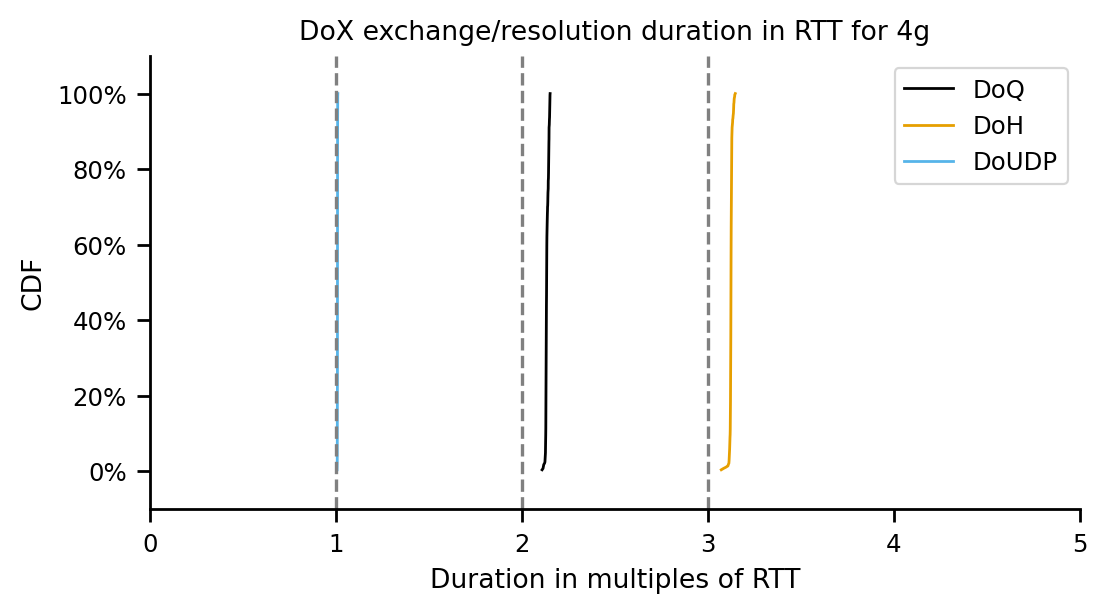

DoQ
count    290.000000
mean       2.157517
std        0.007650
min        2.111028
10%        2.153146
20%        2.154194
25%        2.154596
30%        2.154857
40%        2.155557
50%        2.156117
60%        2.156732
70%        2.158051
75%        2.159779
80%        2.164756
90%        2.167677
100%       2.174591
max        2.174591
Name: duration_in_rtt, dtype: float64
DoH
count    290.000000
mean       3.124498
std        0.005663
min        3.089129
10%        3.119512
20%        3.122554
25%        3.122873
30%        3.123223
40%        3.123895
50%        3.124516
60%        3.125221
70%        3.125993
75%        3.126445
80%        3.126844
90%        3.129100
100%       3.140991
max        3.140991
Name: duration_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.009001
std        0.000496
min        1.007137
10%        1.008284
20%        1.008726
25%        1.008804
30%        1.008864
40%        1.008976
50%        1.009057
60%        1.009145
70%       

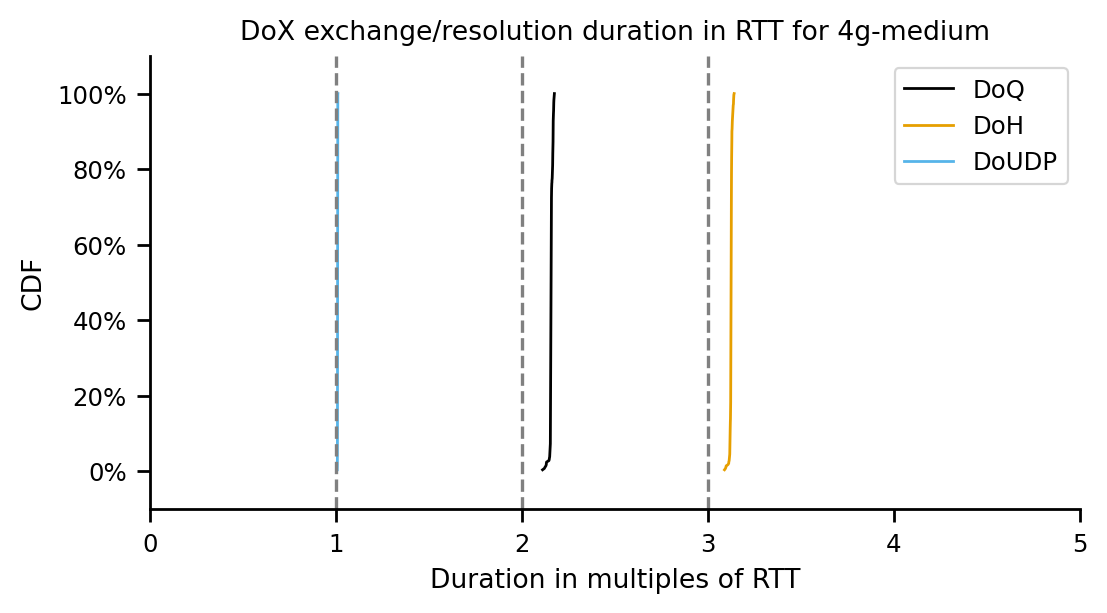

In [73]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    plt.axvline(x=1, color='gray', linestyle='--')
    plt.axvline(x=2, color='gray', linestyle='--')
    plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX exchange/resolution duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean       74.191506
std        36.859207
min        21.500527
10%        26.195999
20%        30.312307
25%        37.449668
30%        37.668790
40%        39.395507
50%        81.946533
60%        83.871054
70%       104.045562
75%       104.829970
80%       105.752261
90%       120.817192
100%      122.749574
max       122.749574
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1453.000000
mean       69.159644
std        36.191513
min        21.874836
10%        25.298831
20%        30.166114
25%        35.885405
30%        36.085775
40%        38.296488
50%        63.860154
60%        65.632433
70%       103.242468
75%       103.448380
80%       105.256075
90%       117.512050
100%      119.238296
max       119.238296
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1453.000000
mean       56.666977
std        35.969389
min        15.180565
10%        15.496080
20%        19.640055
25%        25.937948
30%

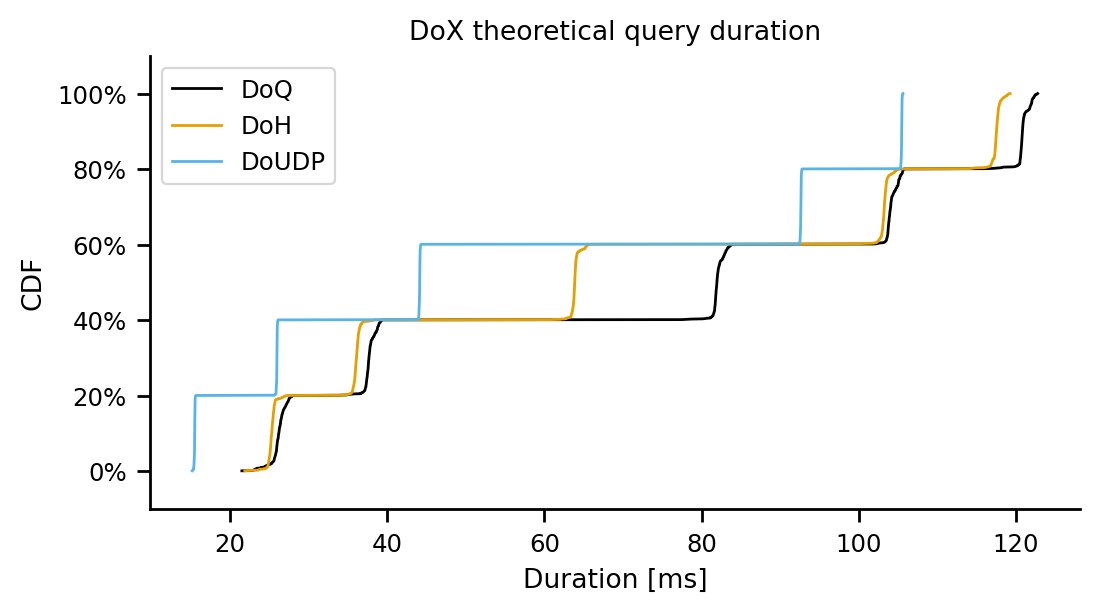

In [84]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean      26.149575
std        0.949875
min       21.500527
10%       25.293339
20%       25.761054
25%       25.883425
30%       25.933894
40%       26.040782
50%       26.192058
60%       26.364032
70%       26.524075
75%       26.634333
80%       26.762272
90%       27.261074
100%      27.996603
max       27.996603
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      25.292047
std        0.549345
min       21.874836
10%       24.872169
20%       25.040820
25%       25.100908
30%       25.147833
40%       25.210000
50%       25.297173
60%       25.380306
70%       25.464264
75%       25.502960
80%       25.566474
90%       25.690543
100%      27.250010
max       27.250010
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      15.486982
std        0.058406
min       15.180565
10%       15.412937
20%       15.458091
25%       15.471433
30%       15.475837
40%       15.490406
50% 

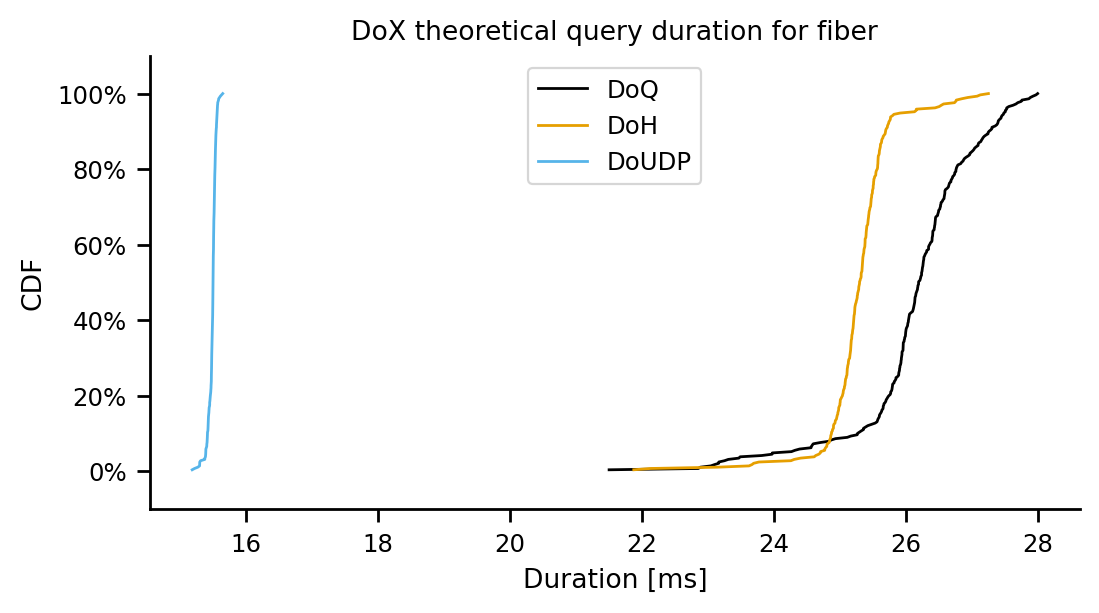

DoQ
count    291.000000
mean      37.785118
std        0.710348
min       33.785862
10%       37.228061
20%       37.382332
25%       37.450440
30%       37.493306
40%       37.596041
50%       37.671218
60%       37.769322
70%       37.928011
75%       38.099296
80%       38.377277
90%       38.768276
100%      39.404324
max       39.404324
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      36.103385
std        0.444774
min       34.540270
10%       35.677354
20%       35.839923
25%       35.888872
30%       35.919868
40%       36.000788
50%       36.086798
60%       36.150129
70%       36.228222
75%       36.281949
80%       36.310106
90%       36.500246
100%      38.301754
max       38.301754
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      25.955447
std        0.058360
min       25.634922
10%       25.879881
20%       25.930188
25%       25.937977
30%       25.942935
40%       25.954802
50% 

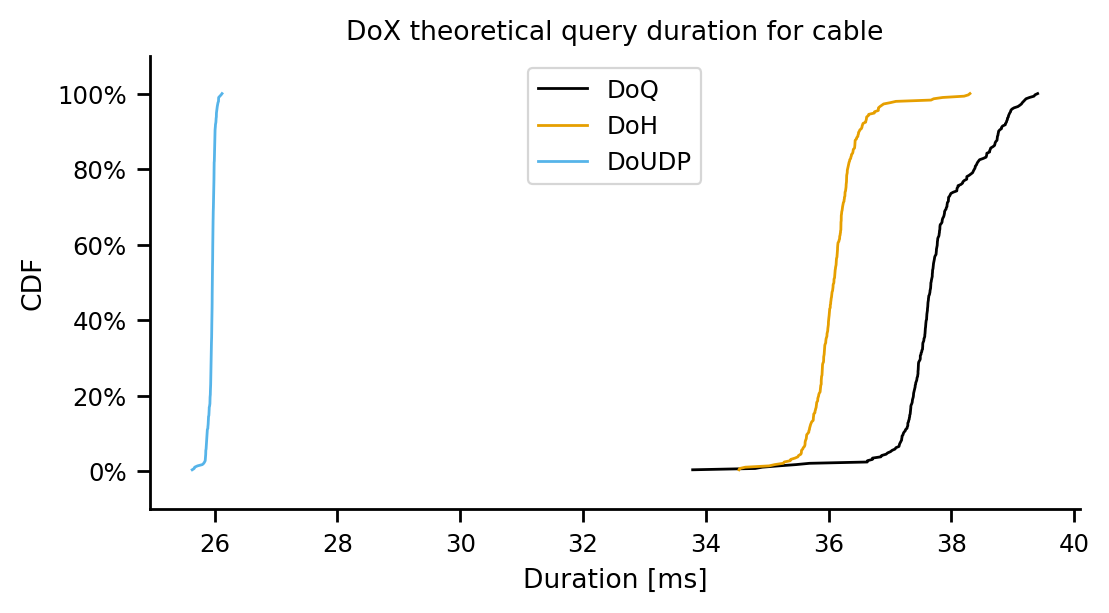

DoQ
count    291.000000
mean      82.077205
std        0.724225
min       77.456191
10%       81.582263
20%       81.719562
25%       81.750707
30%       81.791844
40%       81.867665
50%       81.948599
60%       82.022249
70%       82.189755
75%       82.305756
80%       82.606766
90%       83.062229
100%      83.905511
max       83.905511
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    291.000000
mean      63.905333
std        0.519410
min       60.749614
10%       63.530464
20%       63.685941
25%       63.724930
30%       63.757227
40%       63.808627
50%       63.861075
60%       63.896022
70%       63.945762
75%       63.975405
80%       64.029868
90%       64.354409
100%      65.646565
max       65.646565
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    291.000000
mean      44.119778
std        0.059074
min       43.813162
10%       44.042576
20%       44.078492
25%       44.094290
30%       44.103210
40%       44.117670
50% 

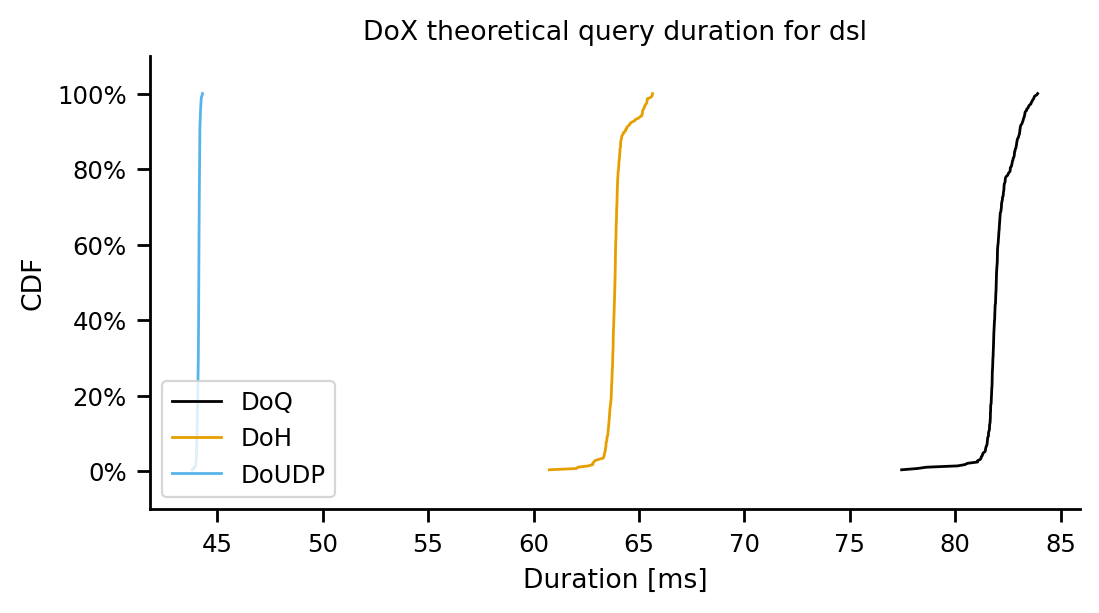

DoQ
count    290.000000
mean     104.244367
std        0.685032
min      101.814804
10%      103.626651
20%      103.730285
25%      103.774913
30%      103.824286
40%      103.928546
50%      104.047890
60%      104.161332
70%      104.531314
75%      104.831484
80%      105.007848
90%      105.231963
100%     105.771901
max      105.771901
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    290.000000
mean     103.266148
std        0.626325
min       98.452525
10%      102.853499
20%      103.018454
25%      103.061868
30%      103.110557
40%      103.182994
50%      103.244356
60%      103.311695
70%      103.391666
75%      103.450735
80%      103.493321
90%      103.751958
100%     105.359138
max      105.359138
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    290.000000
mean      92.619091
std        0.055077
min       92.414579
10%       92.542368
20%       92.578615
25%       92.596422
30%       92.604502
40%       92.614788
50% 

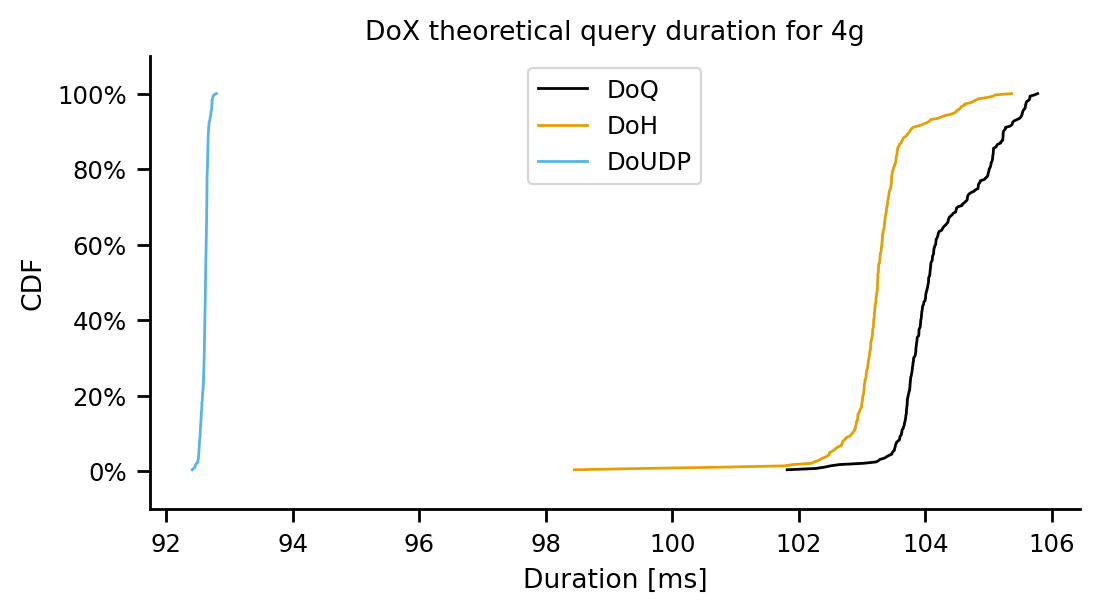

DoQ
count    290.000000
mean     120.965271
std        0.799411
min      116.106995
10%      120.508483
20%      120.618067
25%      120.660032
30%      120.687339
40%      120.760480
50%      120.819041
60%      120.883307
70%      121.021115
75%      121.201687
80%      121.721870
90%      122.027085
100%     122.749574
max      122.749574
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    290.000000
mean     117.514680
std        0.591789
min      113.818491
10%      116.993689
20%      117.311573
25%      117.344920
30%      117.381429
40%      117.451728
50%      117.516627
60%      117.590221
70%      117.670935
75%      117.718211
80%      117.759873
90%      117.995595
100%     119.238296
max      119.238296
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    290.000000
mean     105.444757
std        0.051863
min      105.250018
10%      105.369846
20%      105.416083
25%      105.424220
30%      105.430518
40%      105.442170
50% 

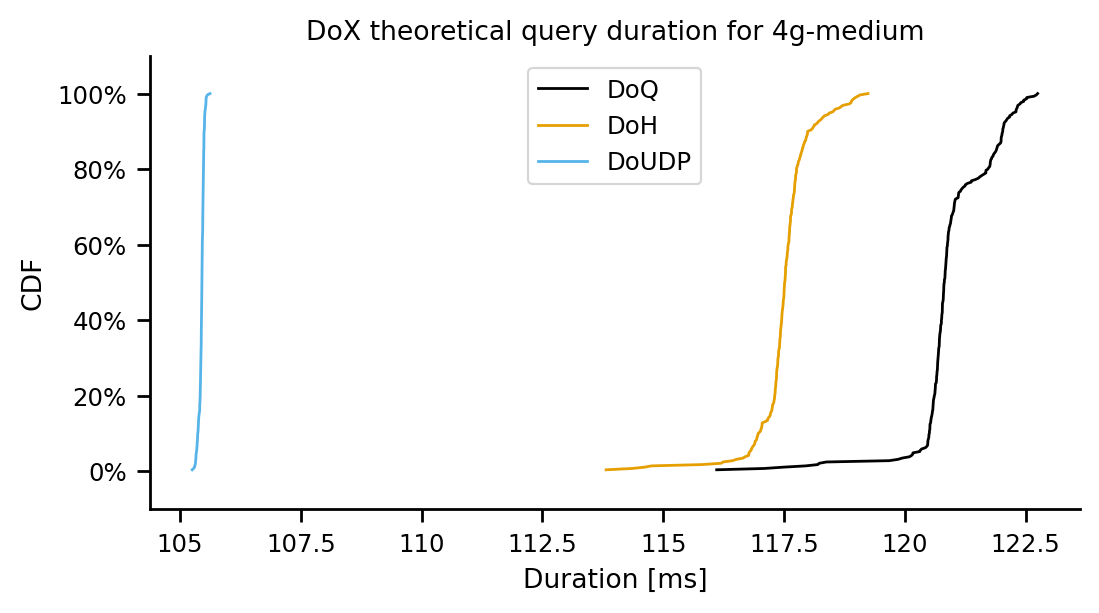

In [86]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration for '+tech)

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean        1.500816
std         0.322787
min         1.108462
10%         1.132539
20%         1.149440
25%         1.154638
30%         1.156122
40%         1.374287
50%         1.496276
60%         1.560865
70%         1.774205
75%         1.804207
80%         1.889985
90%         1.934575
100%        1.980782
max         1.980782
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1453.000000
mean        1.381177
std         0.229283
min         1.071857
10%         1.122571
20%         1.124274
25%         1.125205
30%         1.126396
40%         1.372264
50%         1.433358
60%         1.483071
70%         1.507613
75%         1.510349
80%         1.549232
90%         1.713069
100%        1.845313
max         1.845313
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1453.000000
mean        1.027741
std         0.016692
min         1.006121
10%         1.008299
20%         1.008729
25%         1.008936
30%         1.009131
40%       

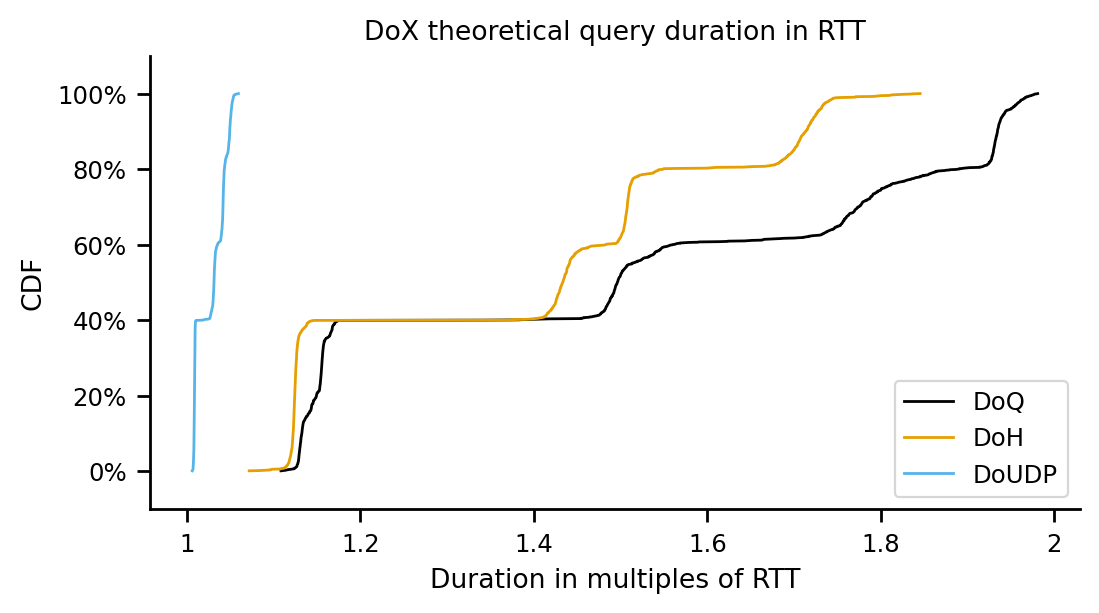

In [83]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean       1.770794
std        0.064324
min        1.455970
10%        1.712811
20%        1.744484
25%        1.752771
30%        1.756189
40%        1.763427
50%        1.773671
60%        1.785317
70%        1.796154
75%        1.803621
80%        1.812285
90%        1.846062
100%       1.895871
max        1.895871
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.712724
std        0.037200
min        1.481318
10%        1.684291
20%        1.695711
25%        1.699780
30%        1.702958
40%        1.707168
50%        1.713071
60%        1.718701
70%        1.724386
75%        1.727007
80%        1.731308
90%        1.739709
100%       1.845313
max        1.845313
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.048746
std        0.003955
min        1.027996
10%        1.043732
20%        1.046789
25%        1.047693
30%        1.047991
40%        1.048978
50%        1.049356
60%        1

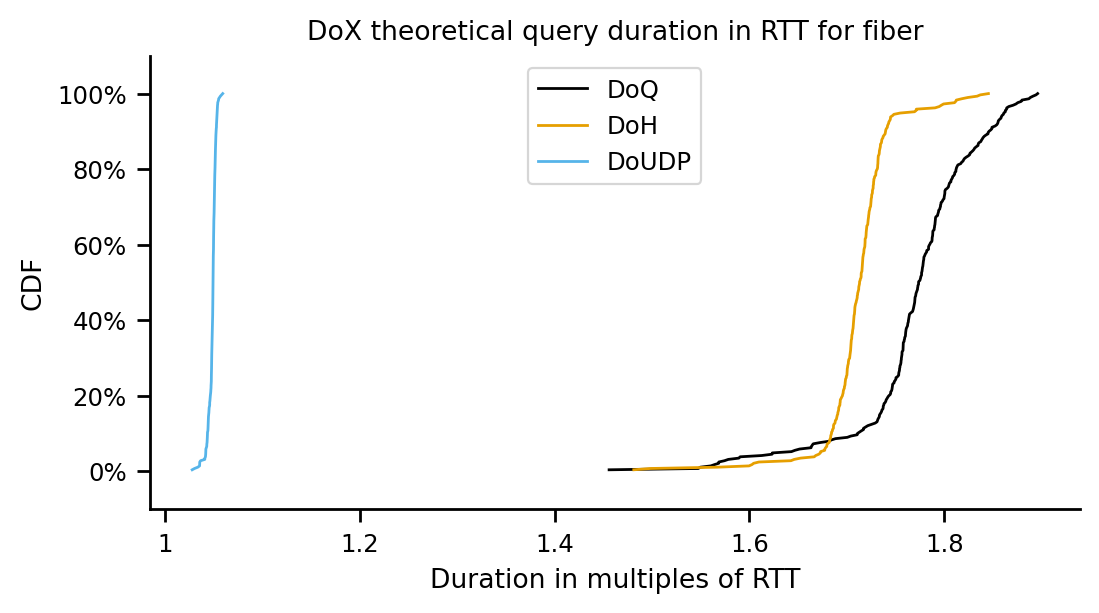

DoQ
count    291.000000
mean       1.500800
std        0.028215
min        1.341952
10%        1.478674
20%        1.484802
25%        1.487507
30%        1.489209
40%        1.493290
50%        1.496276
60%        1.500173
70%        1.506476
75%        1.513279
80%        1.524320
90%        1.539850
100%       1.565114
max        1.565114
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.434003
std        0.017666
min        1.371917
10%        1.417081
20%        1.423538
25%        1.425482
30%        1.426714
40%        1.429928
50%        1.433344
60%        1.435859
70%        1.438961
75%        1.441095
80%        1.442214
90%        1.449766
100%       1.521321
max        1.521321
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.030933
std        0.002318
min        1.018202
10%        1.027932
20%        1.029930
25%        1.030239
30%        1.030436
40%        1.030908
50%        1.031234
60%        1

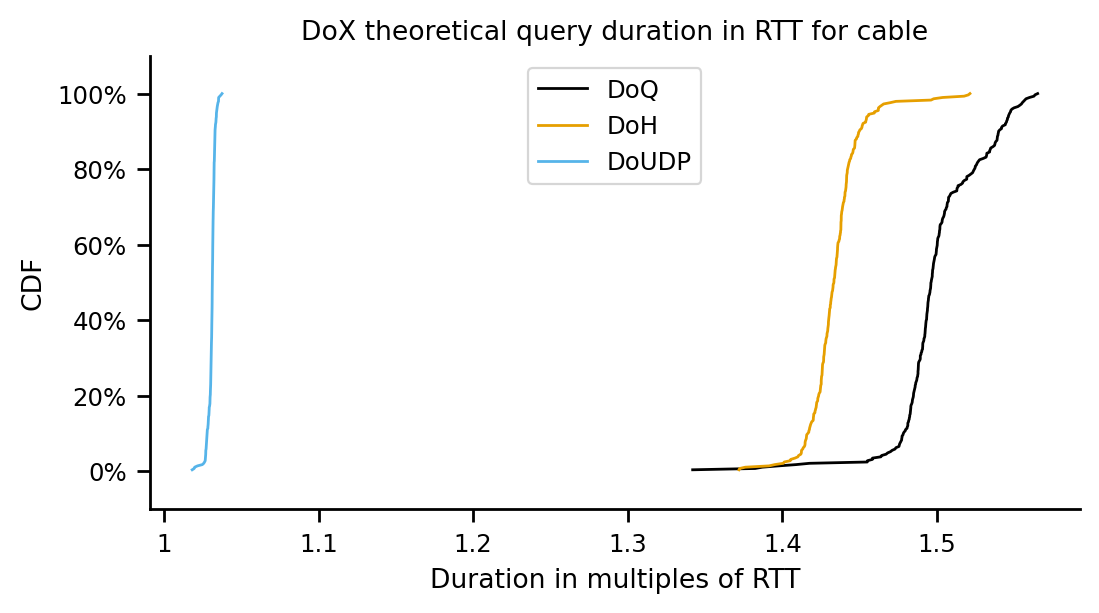

DoQ
count    291.000000
mean       1.937621
std        0.017097
min        1.828531
10%        1.925936
20%        1.929178
25%        1.929913
30%        1.930884
40%        1.932674
50%        1.934585
60%        1.936323
70%        1.940278
75%        1.943016
80%        1.950122
90%        1.960874
100%       1.980782
max        1.980782
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    291.000000
mean       1.508632
std        0.012262
min        1.434134
10%        1.499782
20%        1.503453
25%        1.504373
30%        1.505136
40%        1.506349
50%        1.507587
60%        1.508412
70%        1.509586
75%        1.510286
80%        1.511572
90%        1.519233
100%       1.549738
max        1.549738
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    291.000000
mean       1.041549
std        0.001395
min        1.034310
10%        1.039726
20%        1.040574
25%        1.040947
30%        1.041157
40%        1.041499
50%        1.041696
60%        1

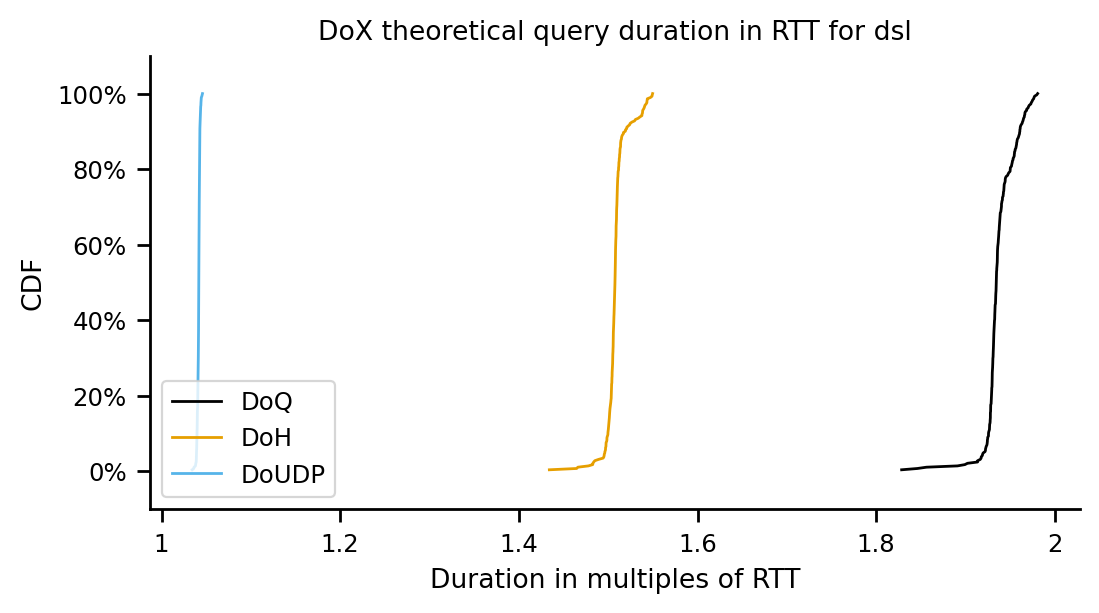

DoQ
count    290.000000
mean       1.134913
std        0.007458
min        1.108462
10%        1.128188
20%        1.129316
25%        1.129802
30%        1.130339
40%        1.131474
50%        1.132774
60%        1.134009
70%        1.138037
75%        1.141305
80%        1.143225
90%        1.145665
100%       1.151543
max        1.151543
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    290.000000
mean       1.124263
std        0.006819
min        1.071857
10%        1.119770
20%        1.121566
25%        1.122039
30%        1.122569
40%        1.123358
50%        1.124026
60%        1.124759
70%        1.125629
75%        1.126273
80%        1.126736
90%        1.129552
100%       1.147049
max        1.147049
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.008348
std        0.000600
min        1.006121
10%        1.007513
20%        1.007907
25%        1.008101
30%        1.008189
40%        1.008301
50%        1.008409
60%        1

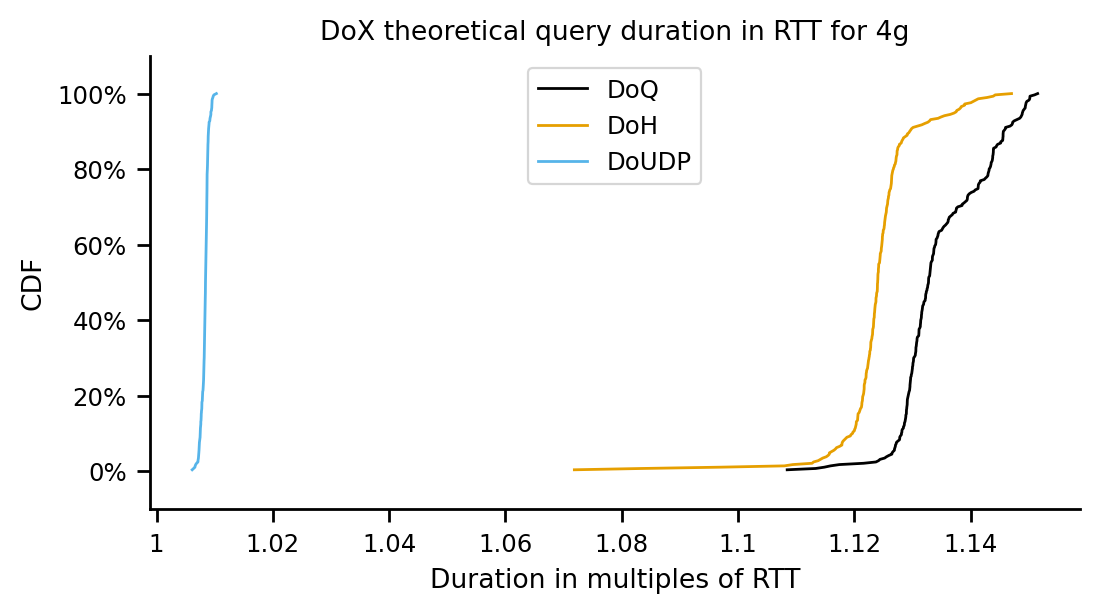

DoQ
count    290.000000
mean       1.157517
std        0.007650
min        1.111028
10%        1.153146
20%        1.154194
25%        1.154596
30%        1.154857
40%        1.155557
50%        1.156117
60%        1.156732
70%        1.158051
75%        1.159779
80%        1.164756
90%        1.167677
100%       1.174591
max        1.174591
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    290.000000
mean       1.124498
std        0.005663
min        1.089129
10%        1.119512
20%        1.122554
25%        1.122873
30%        1.123223
40%        1.123895
50%        1.124516
60%        1.125221
70%        1.125993
75%        1.126445
80%        1.126844
90%        1.129100
100%       1.140991
max        1.140991
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    290.000000
mean       1.009001
std        0.000496
min        1.007137
10%        1.008284
20%        1.008726
25%        1.008804
30%        1.008864
40%        1.008976
50%        1.009057
60%        1

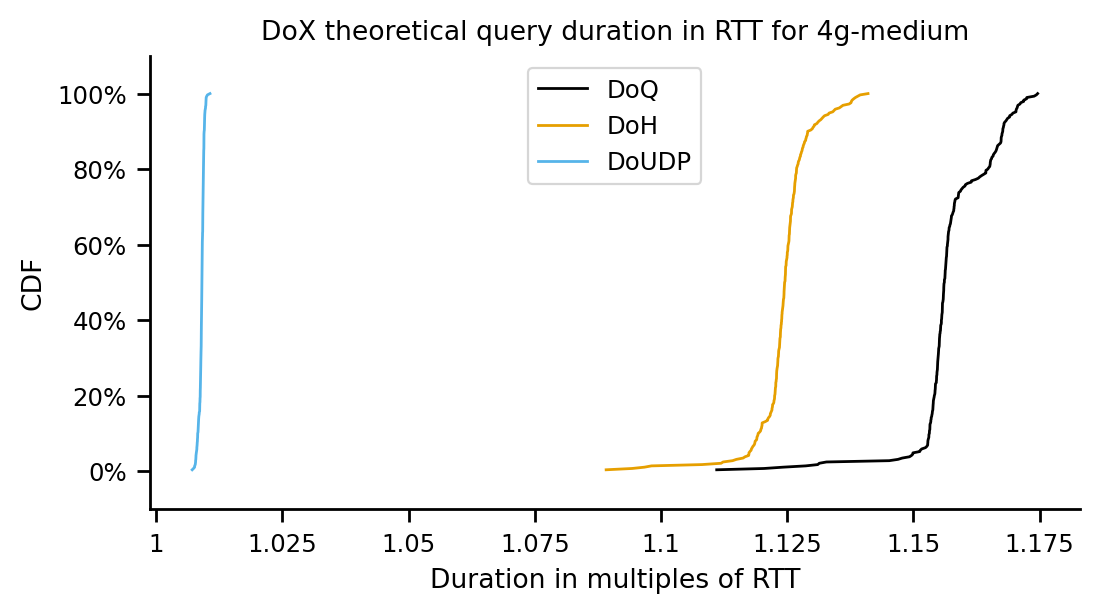

In [87]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    1453.000000
mean       18.517923
std        10.780465
min         6.733380
10%        11.369782
20%        11.867854
25%        12.018651
30%        12.179355
40%        12.452437
50%        12.981037
60%        13.981915
70%        16.314827
75%        16.703125
80%        28.356013
90%        39.588396
100%       41.545721
max        41.545721
Name: theoretical_processing_delay, dtype: float64
DoH
count    1453.000000
mean       13.486062
std         4.158389
min         6.600214
10%        10.439774
20%        10.700967
25%        10.803094
30%        10.910978
40%        11.175233
50%        11.448235
60%        12.433567
70%        13.025244
75%        13.218650
80%        16.927556
90%        21.501101
100%       23.286775
max        23.286775
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1453.000000
mean        0.993395
std         0.394986
min         0.413418
10%         0.704771
20%         0.737676
25%         0.752087
30%         0.762793
40

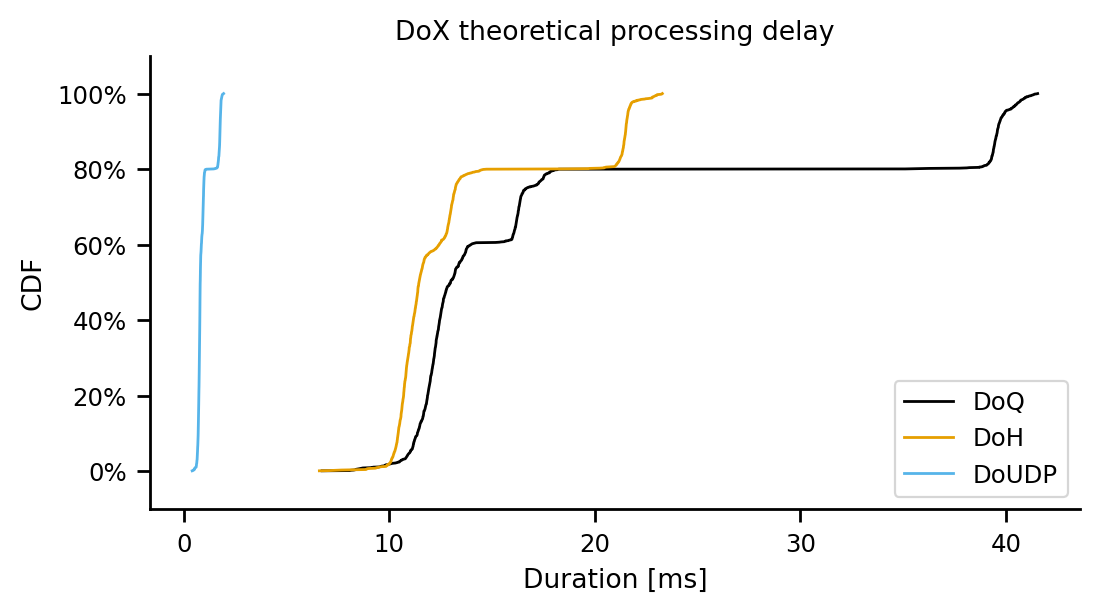

In [90]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)



ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical processing delay')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/processing-delay-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/processing-delay.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    291.000000
mean      11.382428
std        0.949875
min        6.733380
10%       10.526192
20%       10.993907
25%       11.116278
30%       11.166747
40%       11.273635
50%       11.424911
60%       11.596885
70%       11.756928
75%       11.867186
80%       11.995125
90%       12.493927
100%      13.229456
max       13.229456
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      10.524900
std        0.549345
min        7.107689
10%       10.105022
20%       10.273673
25%       10.333761
30%       10.380686
40%       10.442853
50%       10.530026
60%       10.613159
70%       10.697117
75%       10.735813
80%       10.799327
90%       10.923396
100%      12.482863
max       12.482863
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       0.719835
std        0.058406
min        0.413418
10%        0.645790
20%        0.690944
25%        0.704287
30%        0.708690
40%        0.723259
50%        0.728840
60% 

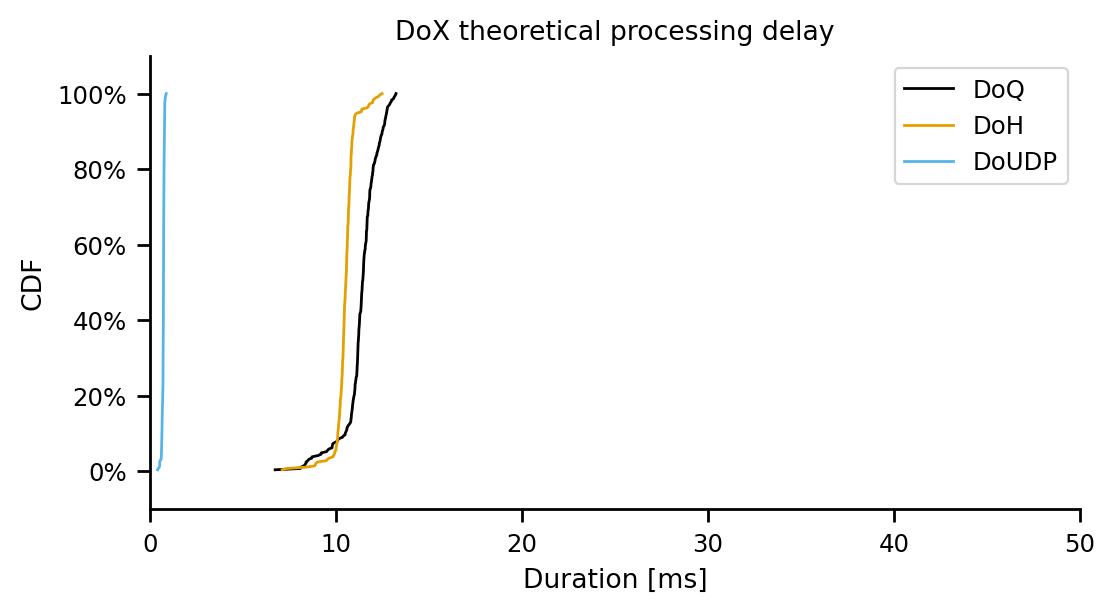

DoQ
count    291.000000
mean      12.608468
std        0.710348
min        8.609212
10%       12.051411
20%       12.205682
25%       12.273790
30%       12.316656
40%       12.419391
50%       12.494568
60%       12.592672
70%       12.751361
75%       12.922646
80%       13.200627
90%       13.591626
100%      14.227674
max       14.227674
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      10.926735
std        0.444774
min        9.363620
10%       10.500704
20%       10.663273
25%       10.712222
30%       10.743218
40%       10.824138
50%       10.910148
60%       10.973479
70%       11.051572
75%       11.105299
80%       11.133456
90%       11.323596
100%      13.125104
max       13.125104
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       0.778797
std        0.058360
min        0.458272
10%        0.703231
20%        0.753538
25%        0.761328
30%        0.766285
40%        0.778152
50%        0.786379
60% 

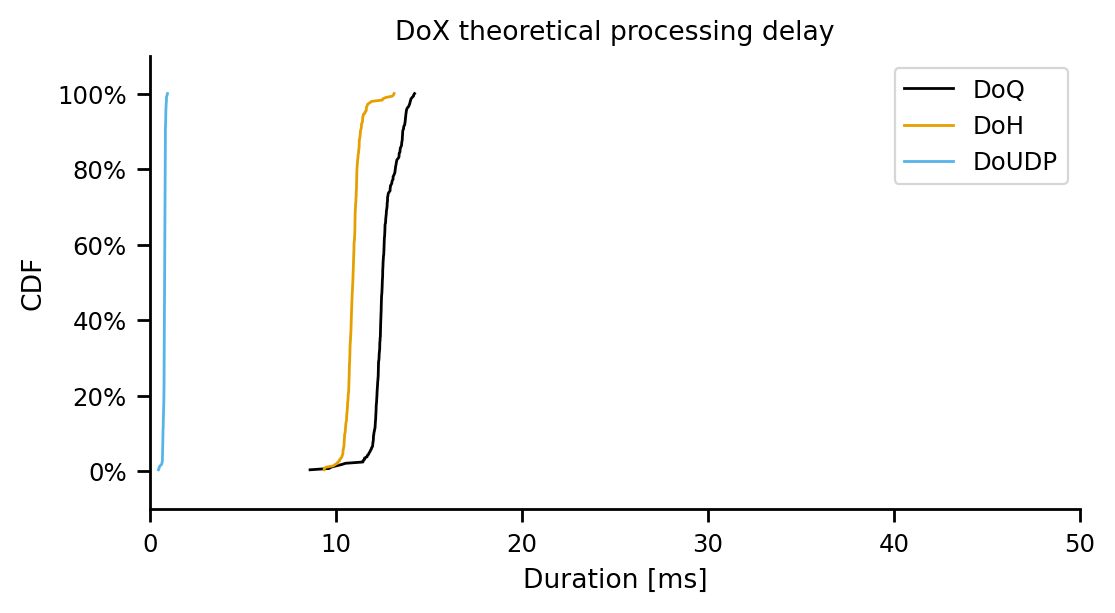

DoQ
count    291.000000
mean      39.717415
std        0.724225
min       35.096401
10%       39.222473
20%       39.359772
25%       39.390917
30%       39.432054
40%       39.507875
50%       39.588809
60%       39.662459
70%       39.829965
75%       39.945966
80%       40.246976
90%       40.702439
100%      41.545721
max       41.545721
Name: theoretical_processing_delay, dtype: float64
DoH
count    291.000000
mean      21.545543
std        0.519410
min       18.389824
10%       21.170674
20%       21.326151
25%       21.365140
30%       21.397437
40%       21.448837
50%       21.501285
60%       21.536232
70%       21.585972
75%       21.615615
80%       21.670078
90%       21.994619
100%      23.286775
max       23.286775
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    291.000000
mean       1.759988
std        0.059074
min        1.453372
10%        1.682786
20%        1.718702
25%        1.734500
30%        1.743420
40%        1.757880
50%        1.766219
60% 

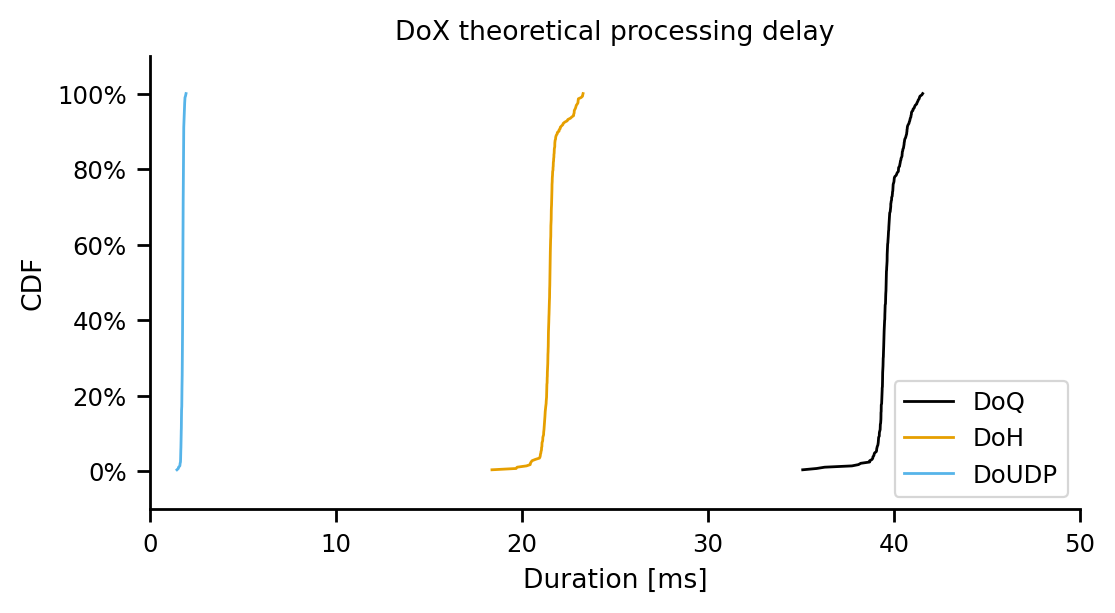

DoQ
count    290.000000
mean      12.392056
std        0.685032
min        9.962494
10%       11.774341
20%       11.877974
25%       11.922602
30%       11.971975
40%       12.076236
50%       12.195579
60%       12.309021
70%       12.679004
75%       12.979173
80%       13.155537
90%       13.379653
100%      13.919591
max       13.919591
Name: theoretical_processing_delay, dtype: float64
DoH
count    290.000000
mean      11.413837
std        0.626325
min        6.600214
10%       11.001189
20%       11.166143
25%       11.209558
30%       11.258247
40%       11.330684
50%       11.392046
60%       11.459385
70%       11.539356
75%       11.598424
80%       11.641010
90%       11.899648
100%      13.506827
max       13.506827
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    290.000000
mean       0.766780
std        0.055077
min        0.562268
10%        0.690058
20%        0.726304
25%        0.744112
30%        0.752191
40%        0.762477
50%        0.772425
60% 

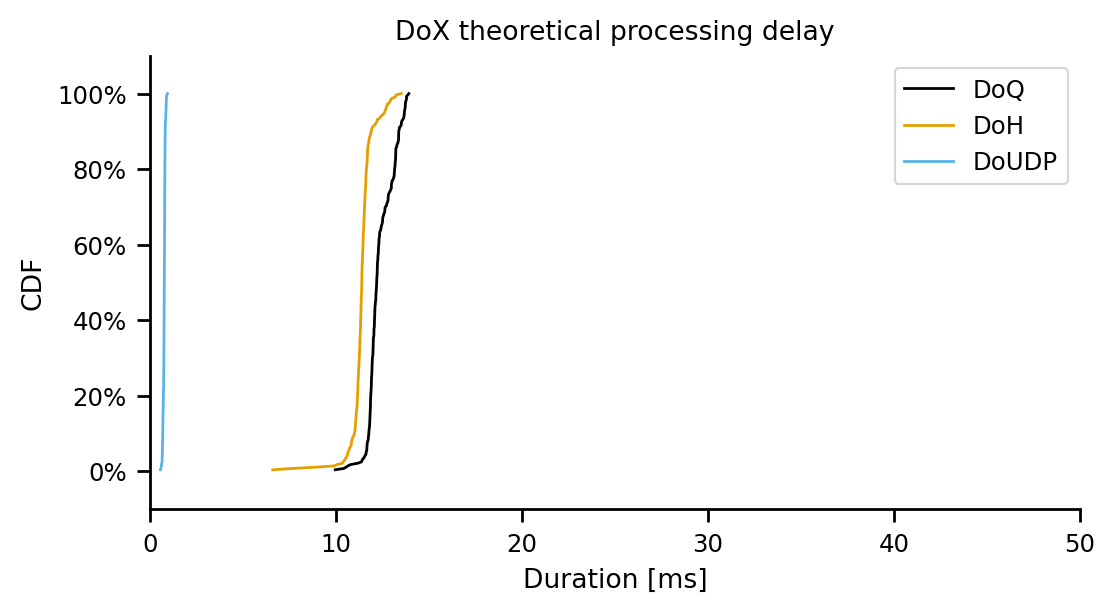

DoQ
count    290.000000
mean      16.461129
std        0.799411
min       11.602853
10%       16.004340
20%       16.113924
25%       16.155890
30%       16.183196
40%       16.256338
50%       16.314899
60%       16.379164
70%       16.516972
75%       16.697544
80%       17.217727
90%       17.522942
100%      18.245432
max       18.245432
Name: theoretical_processing_delay, dtype: float64
DoH
count    290.000000
mean      13.010537
std        0.591789
min        9.314348
10%       12.489546
20%       12.807430
25%       12.840777
30%       12.877287
40%       12.947586
50%       13.012485
60%       13.086079
70%       13.166793
75%       13.214068
80%       13.255730
90%       13.491453
100%      14.734153
max       14.734153
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    290.000000
mean       0.940614
std        0.051863
min        0.745875
10%        0.865703
20%        0.911941
25%        0.920077
30%        0.926375
40%        0.938027
50%        0.946453
60% 

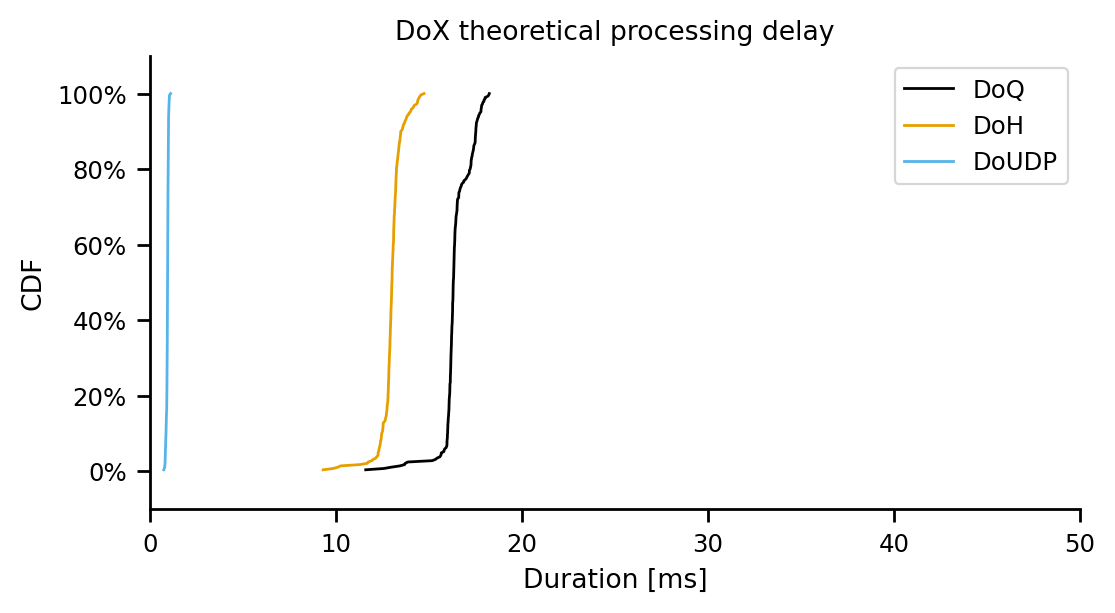

In [92]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical processing delay')

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 50)
    ax.legend()


    if log:
        fig.savefig('figures/processing-delay-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/processing-delay-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()